In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy as sp
def figsize(width, ratio):
    width /= 25.4
    height = width / ratio
    return (width, height)

fig16by9 = figsize(200, 16/9)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = ['Times New Roman', 'Helvetica', 'serif']

plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize'] = fig16by9
plt.rcParams['figure.dpi'] = 350

plt.rcParams['lines.linewidth'] = .9

In [2]:
def g_(a, t1, t2):
    return lambda t: np.piecewise(t,
    [t > t2, t <= t2, t < t1],
    [0, a, 0]                    
    )

g = g_(1, 2, 3)

def xi(t):
    return np.random.uniform(-1, 1, size=t.size)

def wave(t, d):
    return np.sin(d*t)

def noisy_signal(t, b, c, d):
    return g(t) + b*xi(t) + c*wave(t, d)

## 1.1

In [3]:
N = 2**10 * 4
t = np.linspace(0.5, 4.5, N)
signal = noisy_signal(t, 1, 0, 1)
clean_signal = g(t)

In [4]:
W_tf = lambda num, den: (num, den)
W1_tf = lambda T: W_tf([1], [T, 1])

# передаточная функция от произвольного аргумента
def W_poly(W):
    return lambda p: sum(p**i*coef for i, coef in enumerate(reversed(W[0]))) / sum(p**i*coef for i, coef in enumerate(reversed(W[1])))

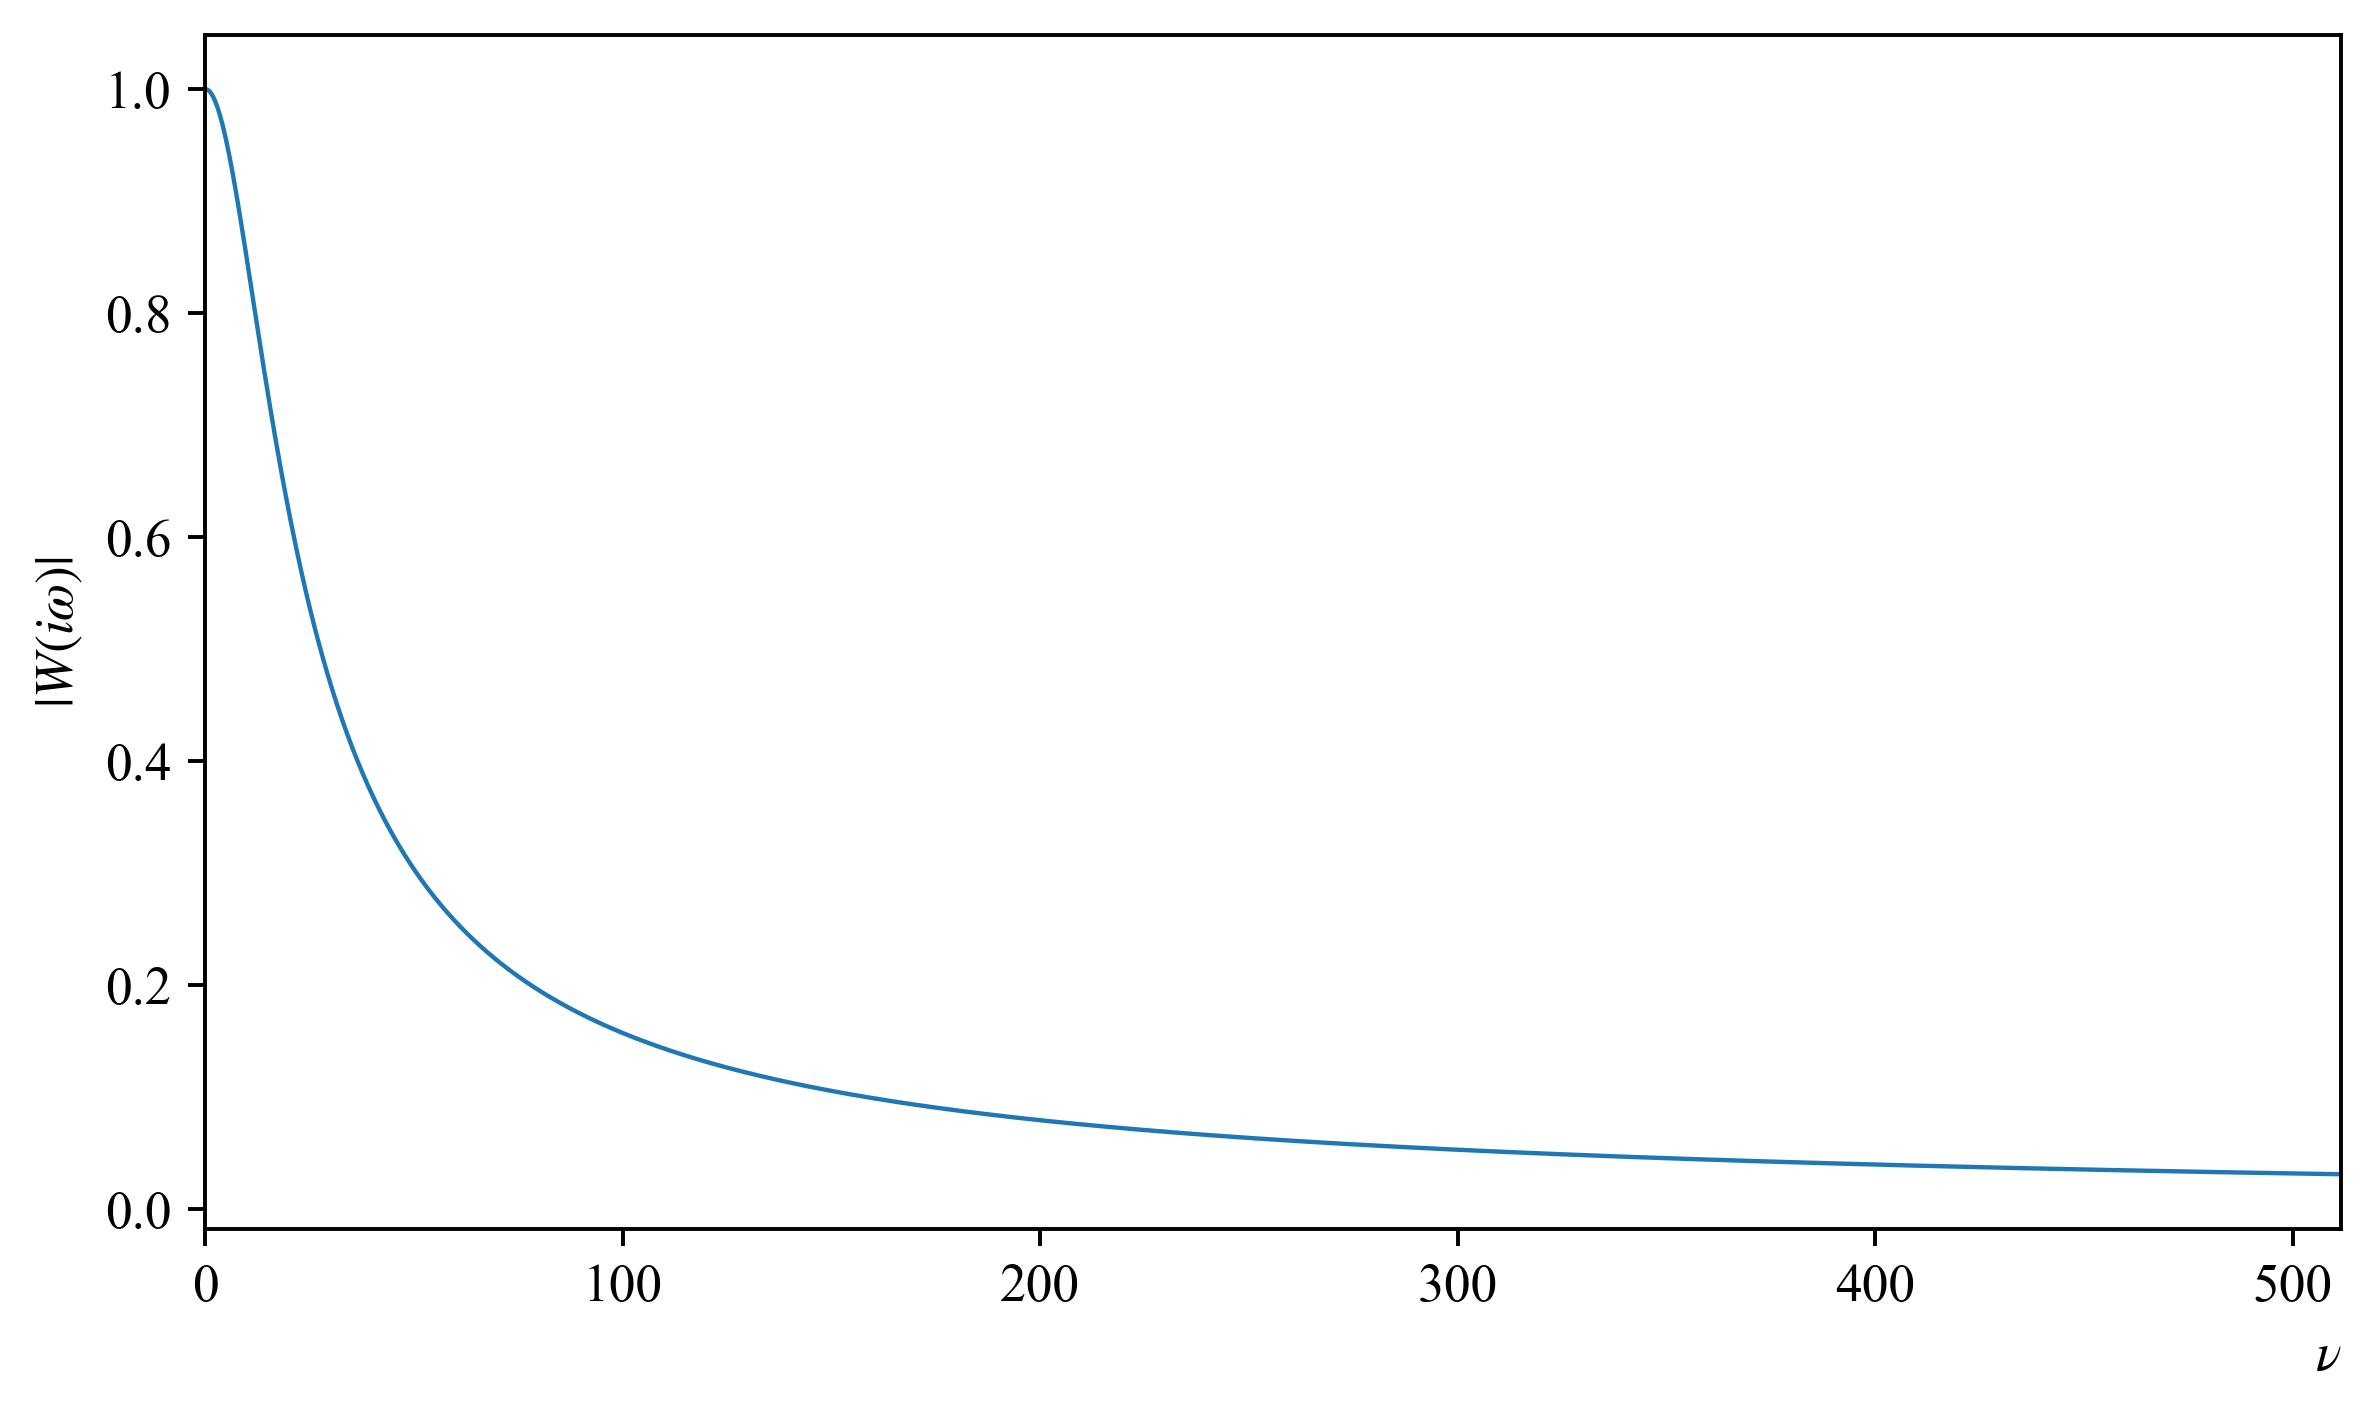

In [5]:
# АЧХ
def freq_response(W, t):
    poly = W_poly(W)

    sr = t[1] - t[0]
    N = t.size

    fr = np.fft.fftfreq(N, sr)
    fr = np.fft.fftshift(fr)

    return fr, np.abs(poly(1j*np.pi*2*fr))


#график АЧХ
def plot_freq_response(W, ax, t):  
    fr, response = freq_response(W, t)

    ax.set_xlabel('$\\nu$', loc='right')
    ax.set_ylabel('$|W(i\\omega)|$')
    ax.plot(fr, response)

    ax.set_xlim(left=0, right=fr[-1])

plot_freq_response(W1_tf(.01), plt.axes(), t)

In [6]:
# фильтрация через произведение перед. функции на образ
def apply_W_nondynamic(t, signal, W, dt=None):
    if dt is None:
        dt = t[1] - t[0]

    fr = np.fft.fftfreq(signal.size, dt)
    fft = np.fft.fft(signal)

    return np.real(np.fft.ifft( W_poly(W)(1j*2*np.pi*fr)*fft ))

# честная динамическая фильтрация дискретного сигнала
def apply_W_dynamic(t, signal, W, dt=None):
    if dt is None:
        dt = t[1] - t[0]

    b, a = sp.signal.bilinear(W[0], W[1], 1/dt)
    y_out = sp.signal.lfilter(b, a, signal)

    return y_out



## Вариация параметра T

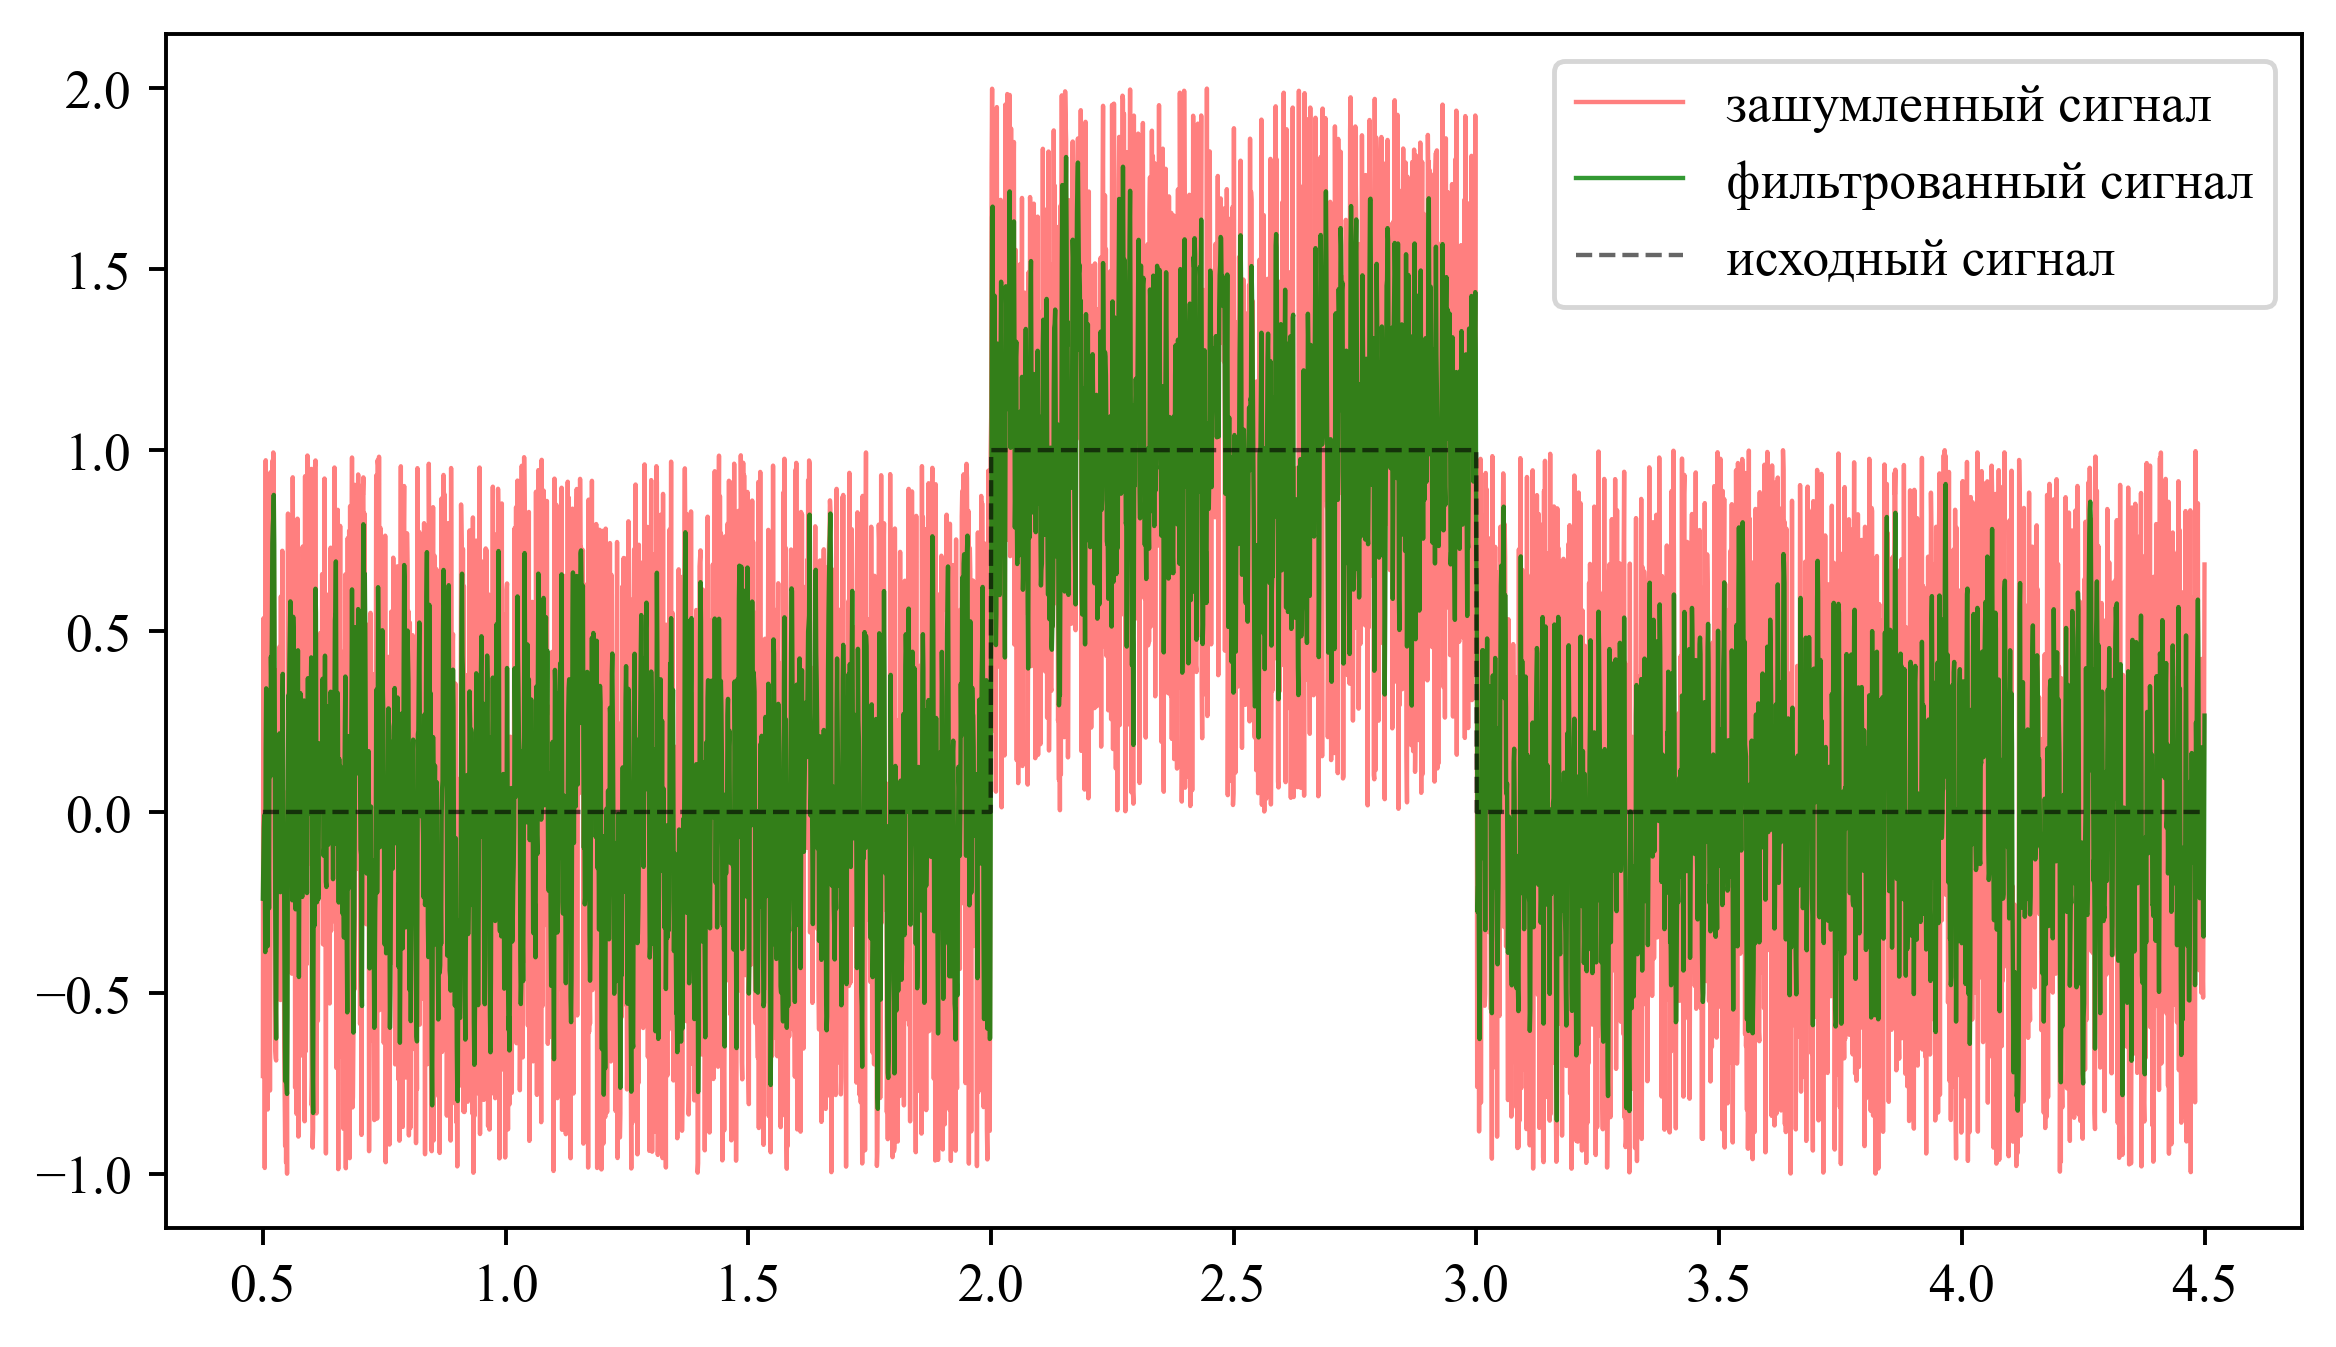

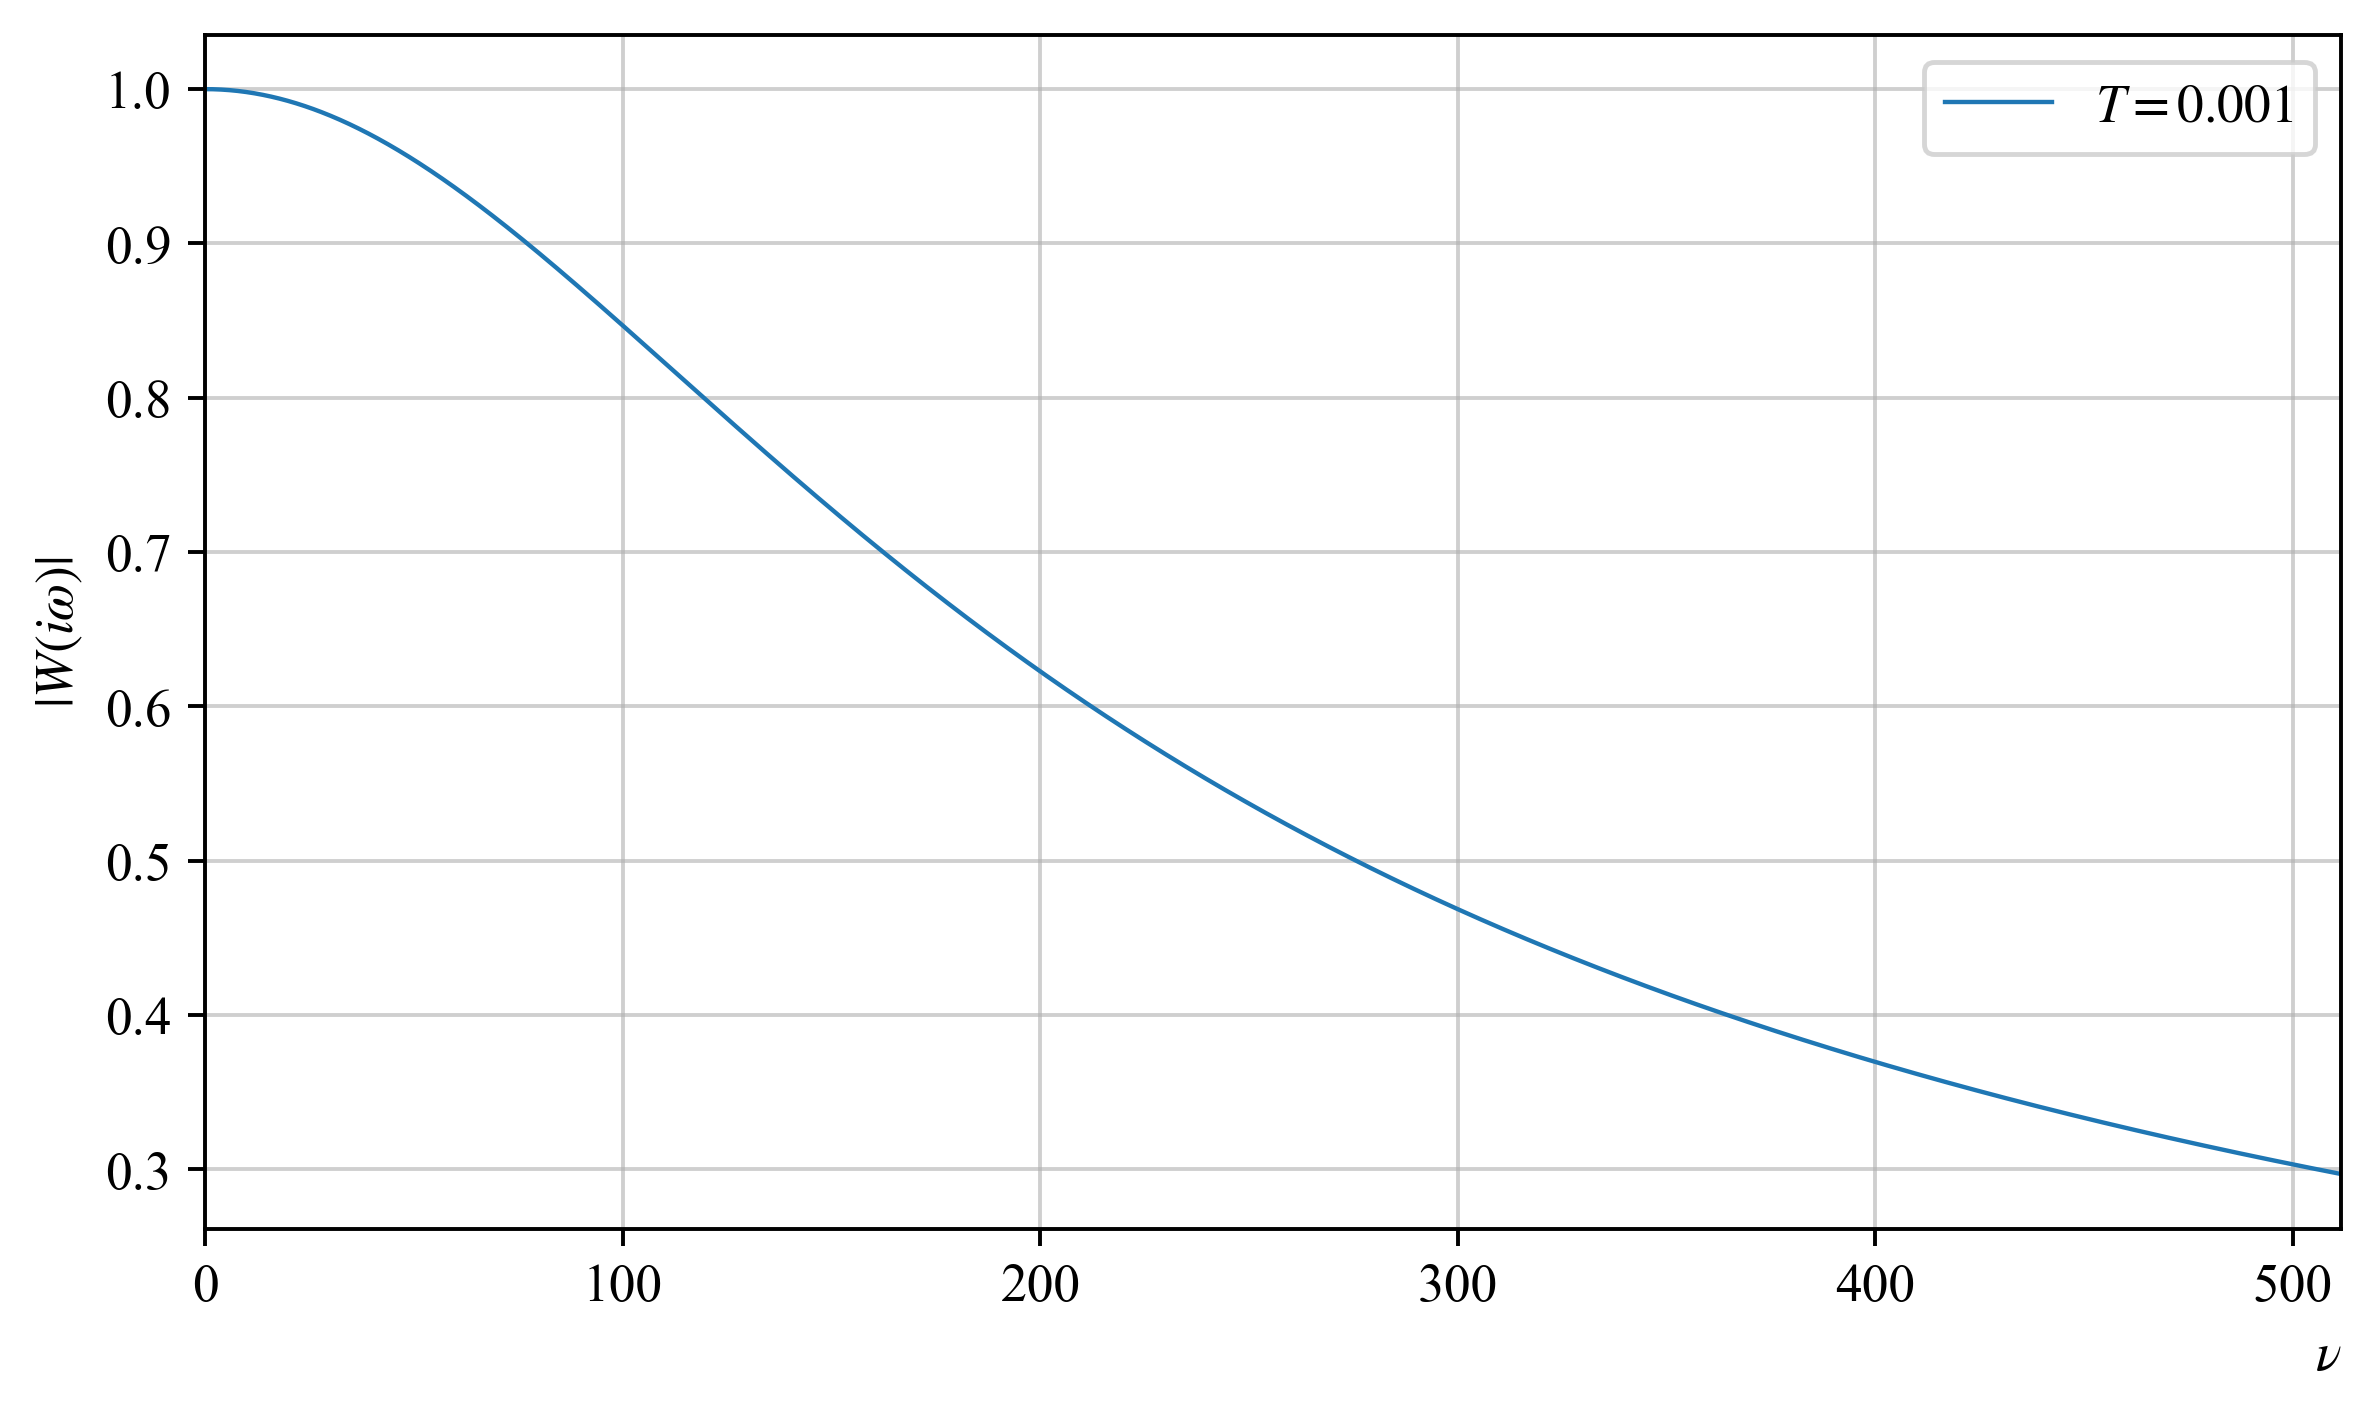

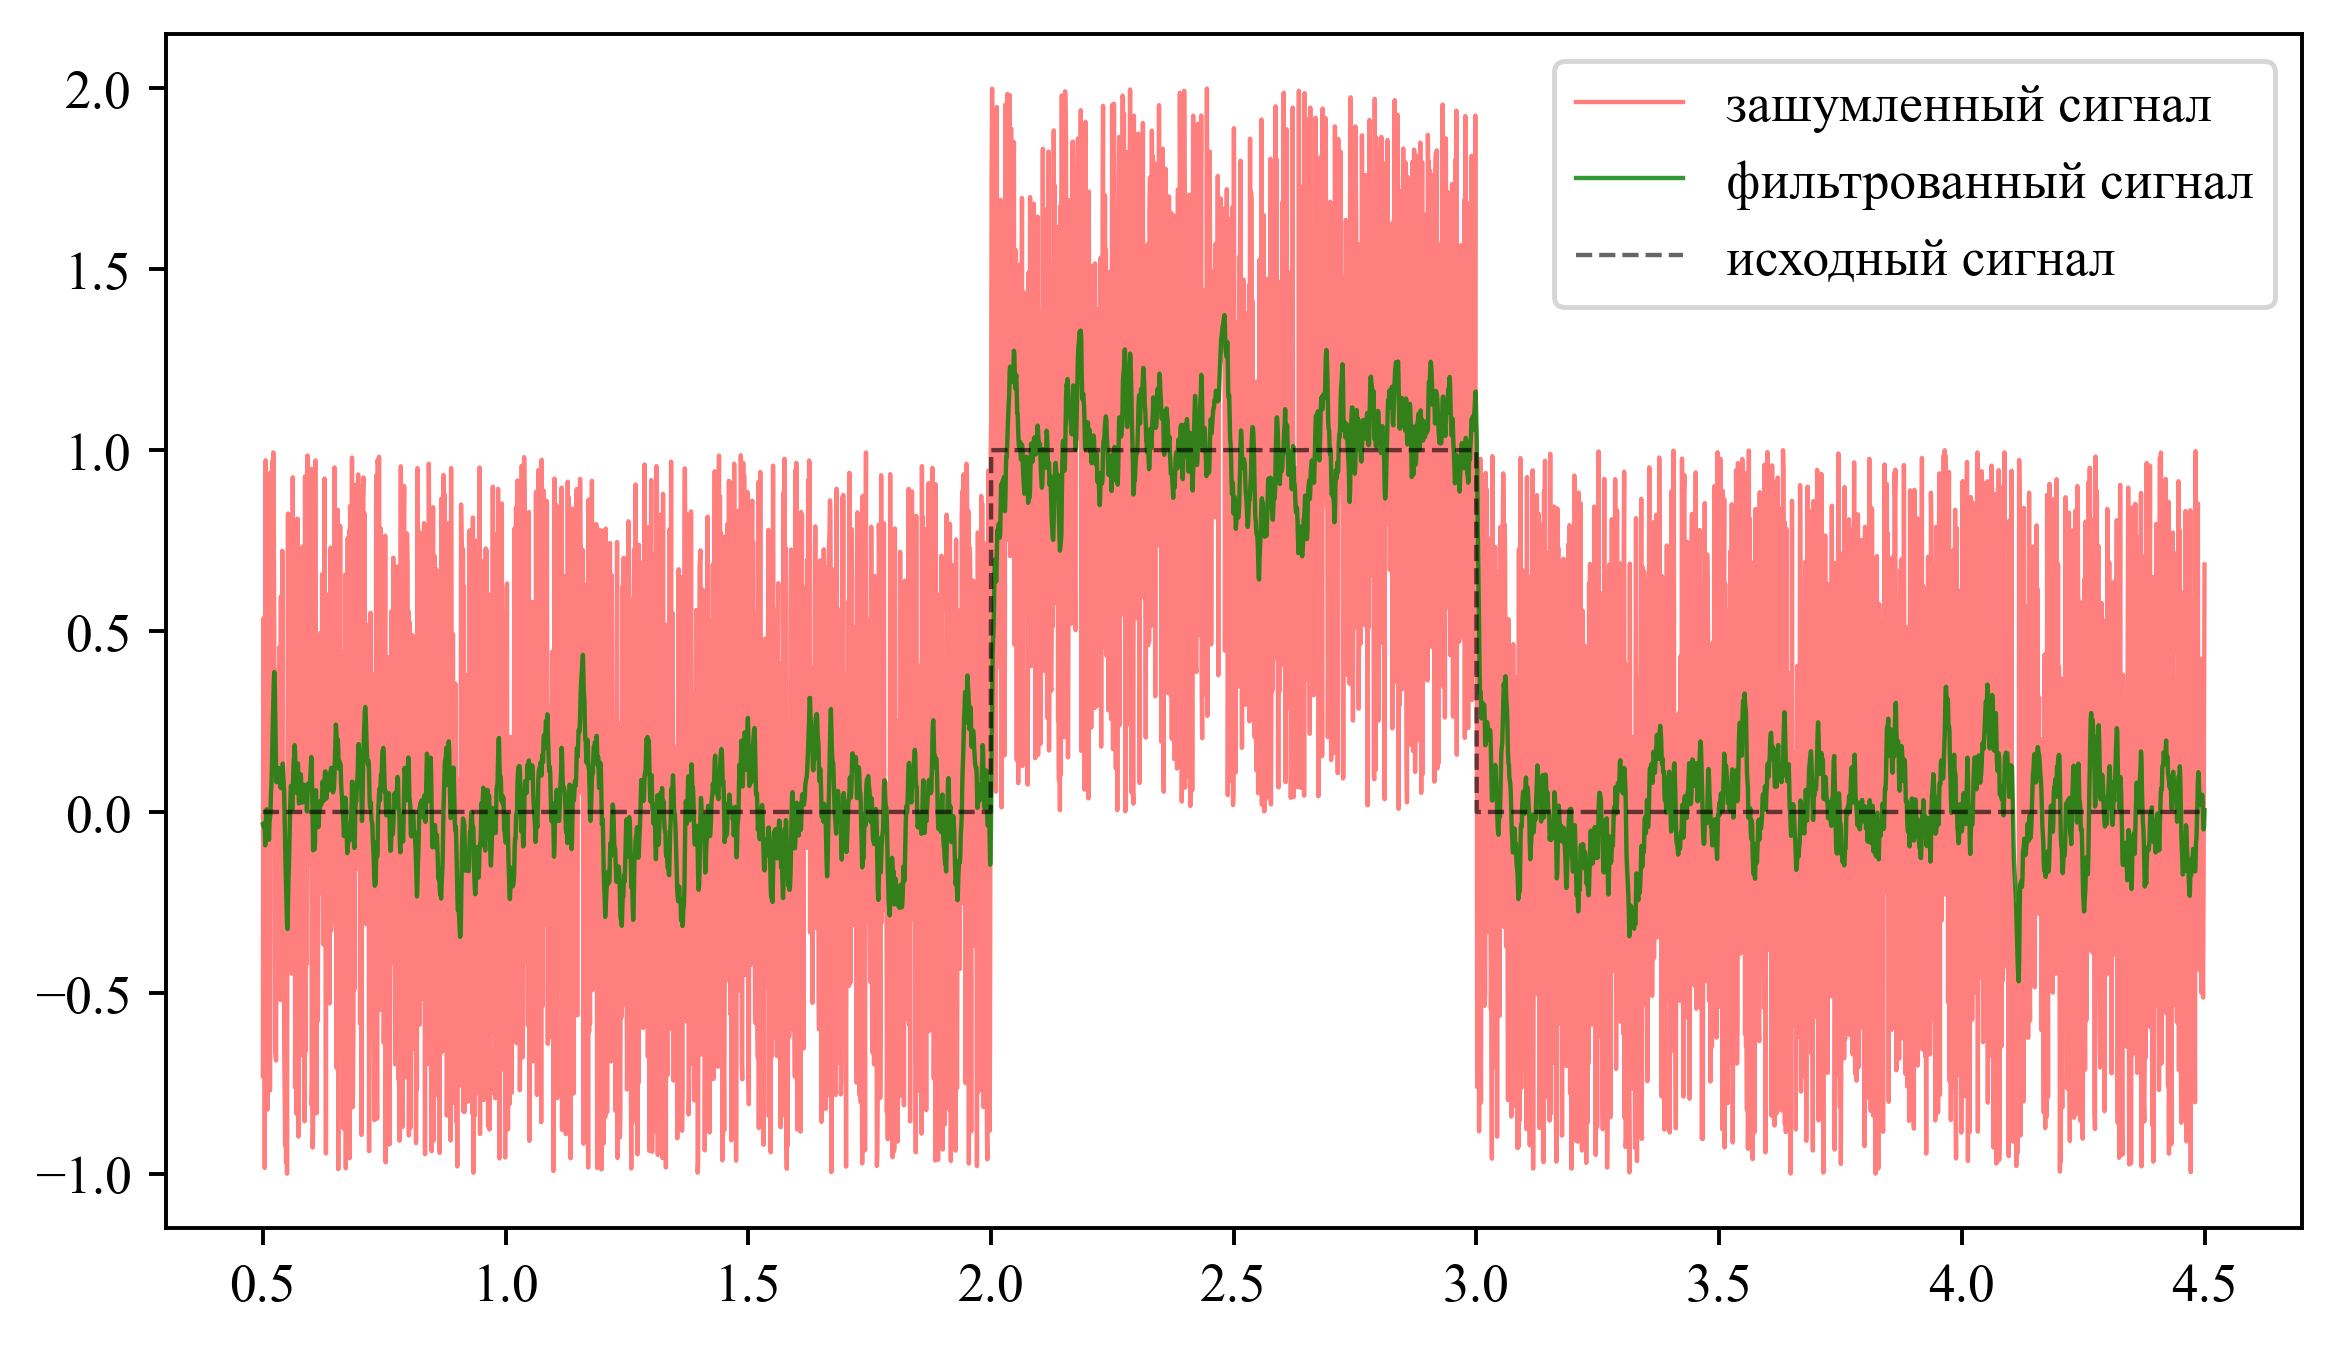

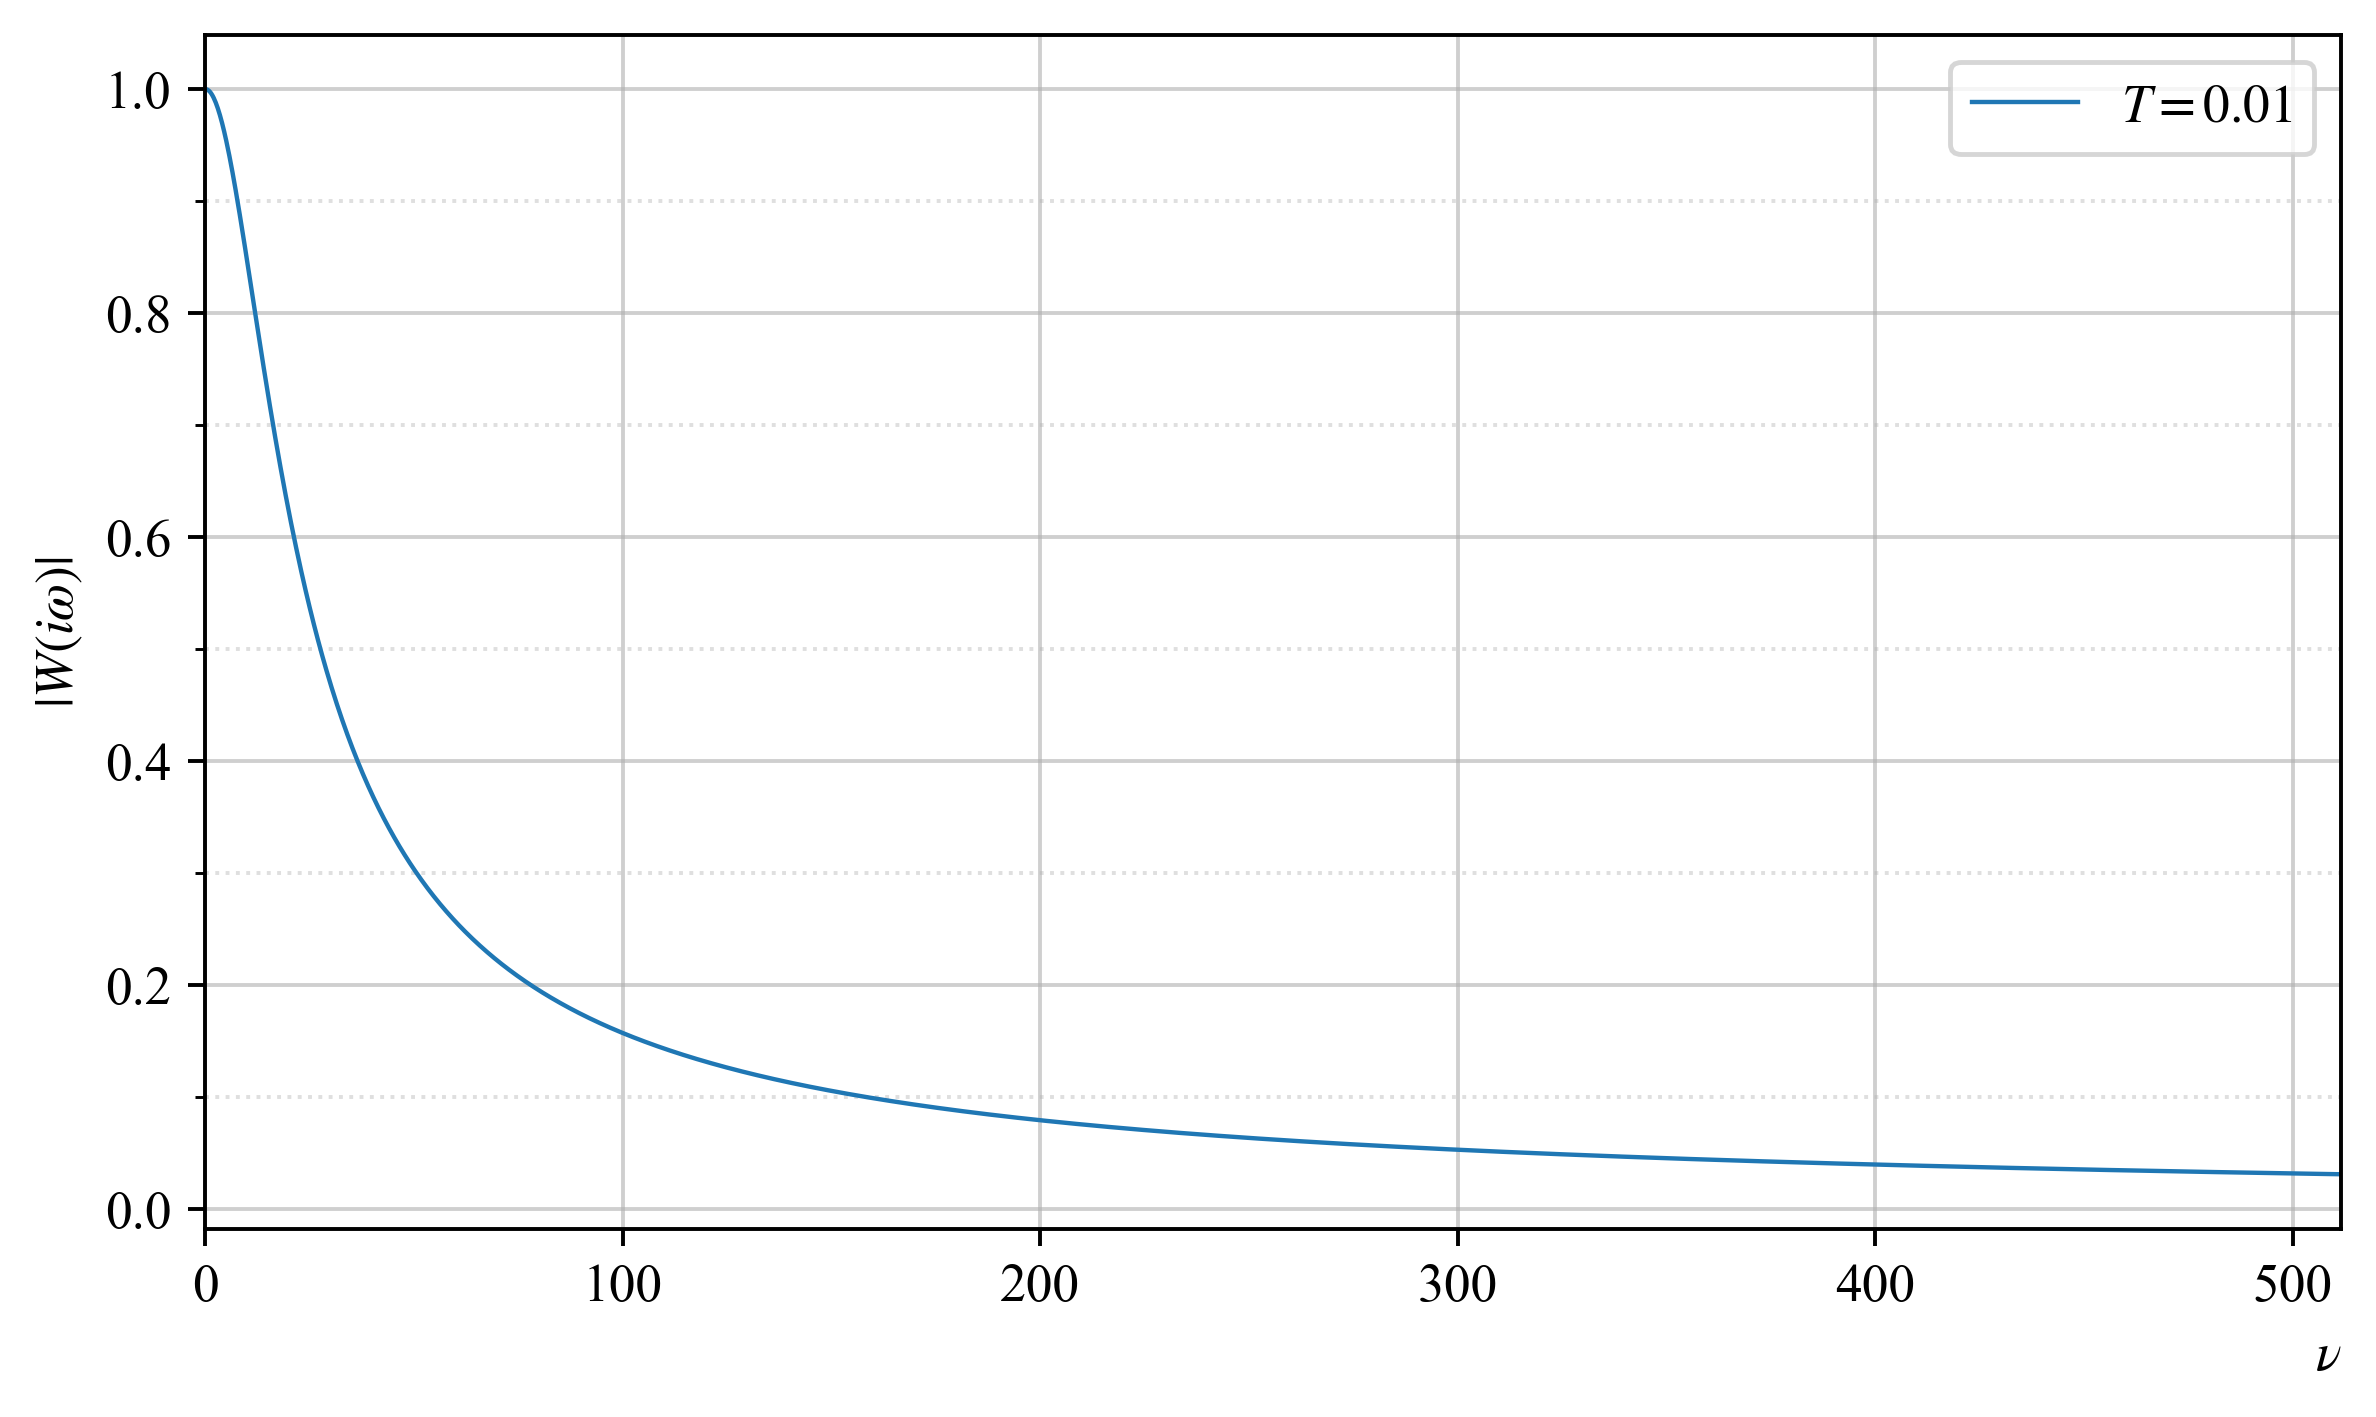

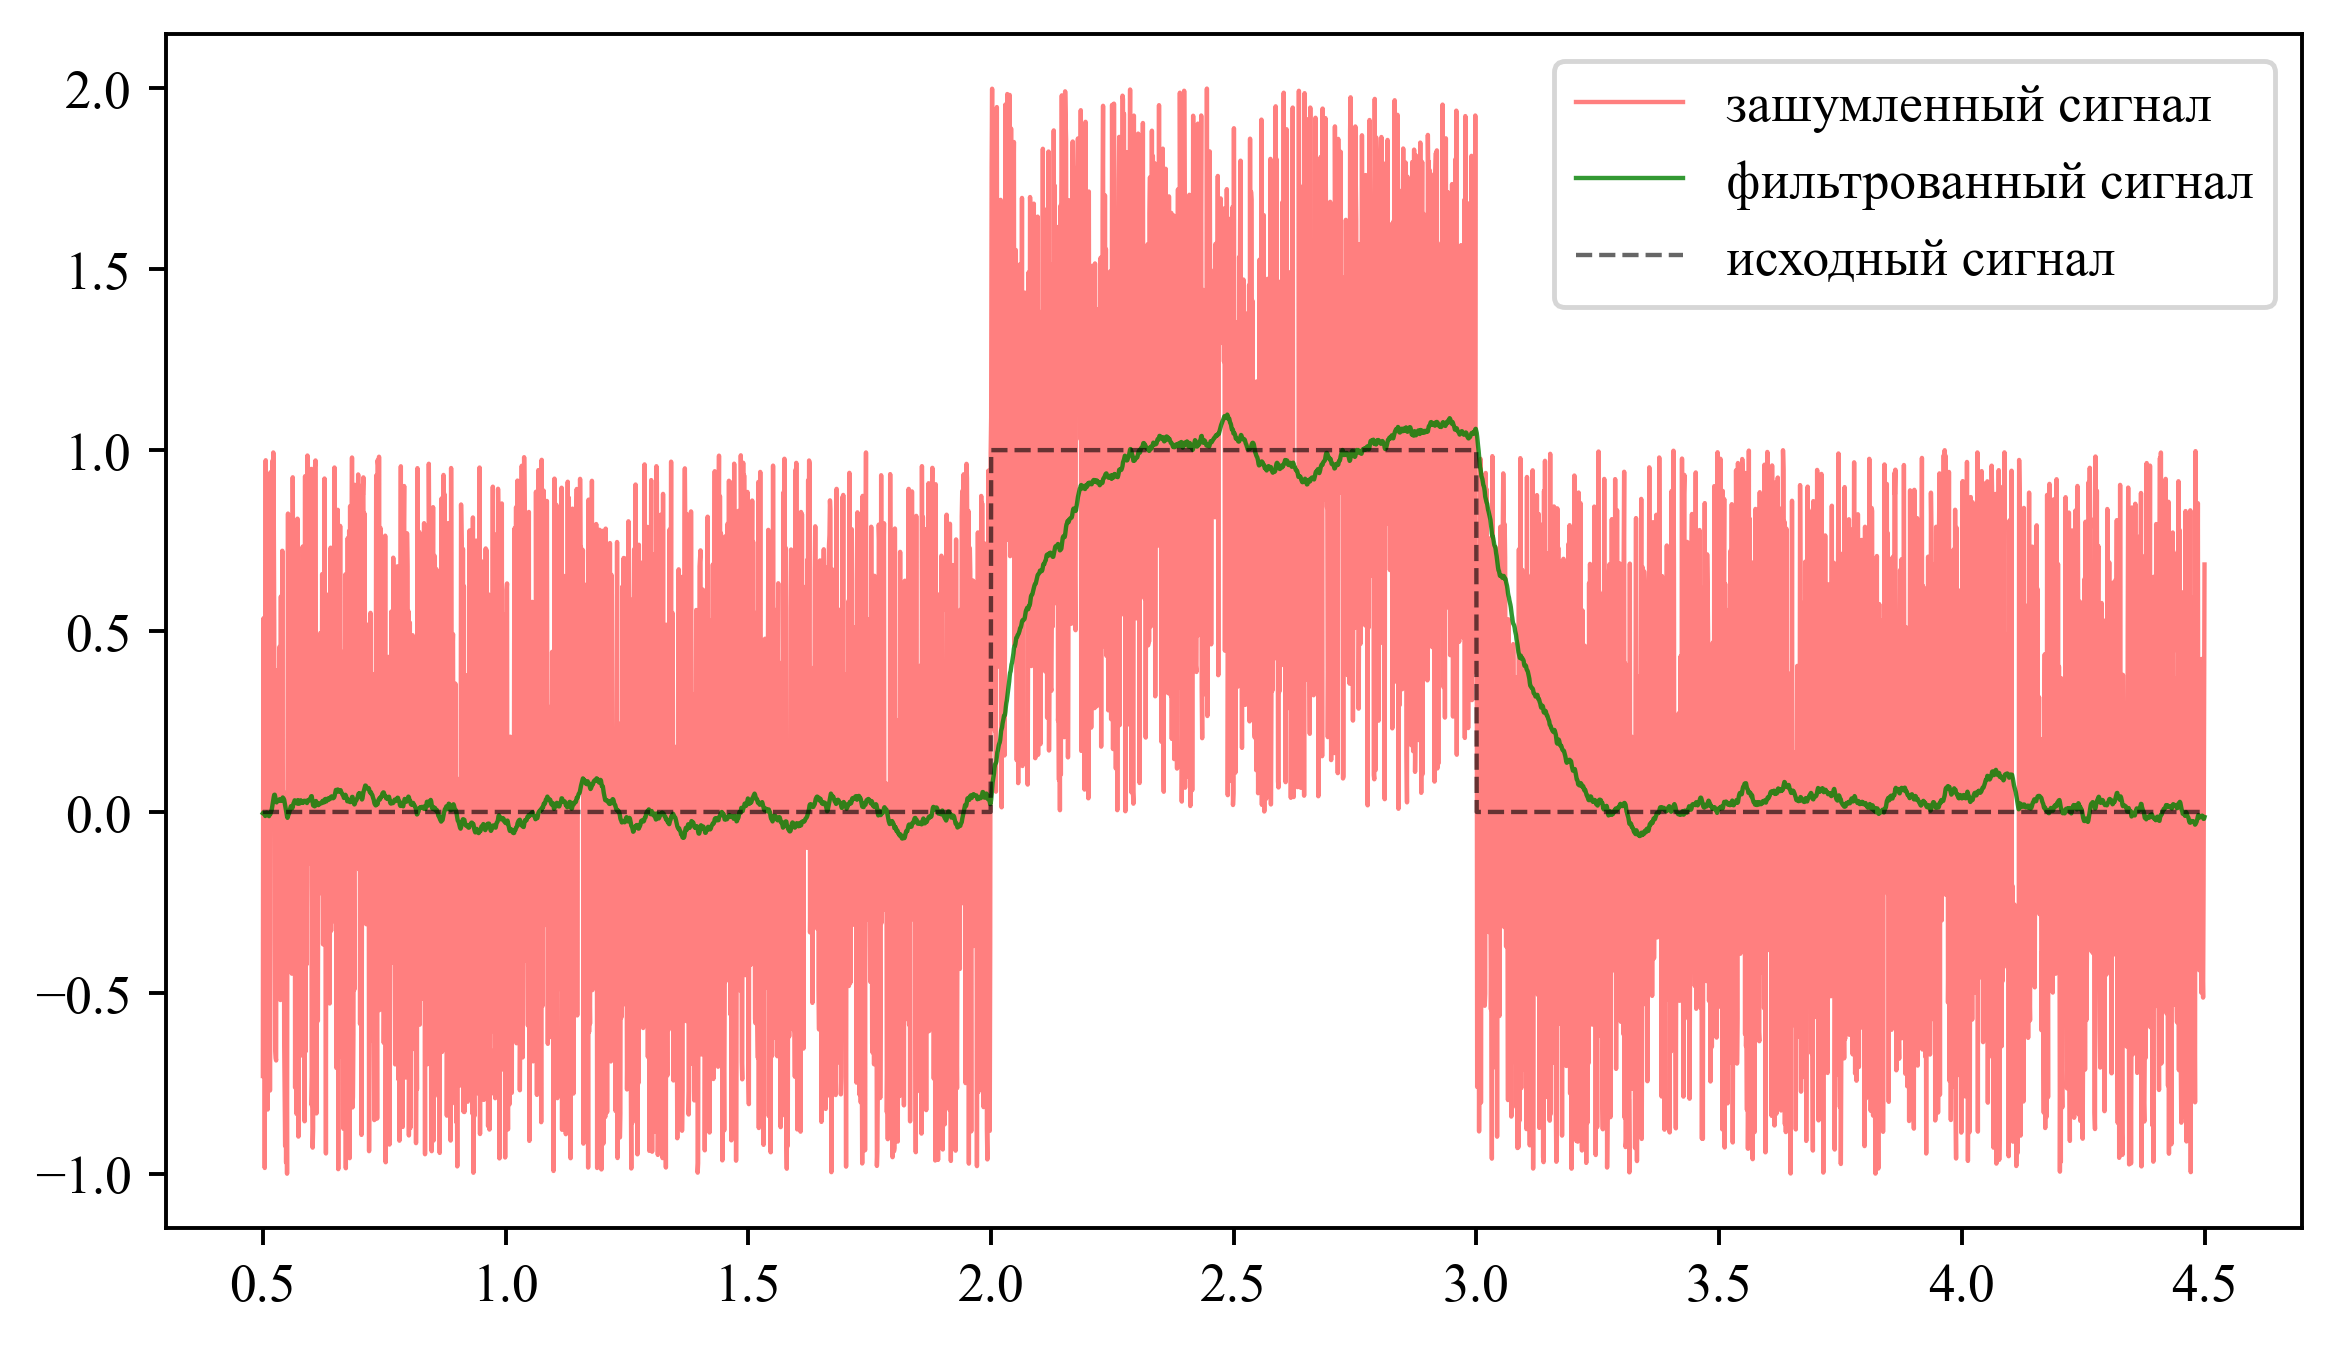

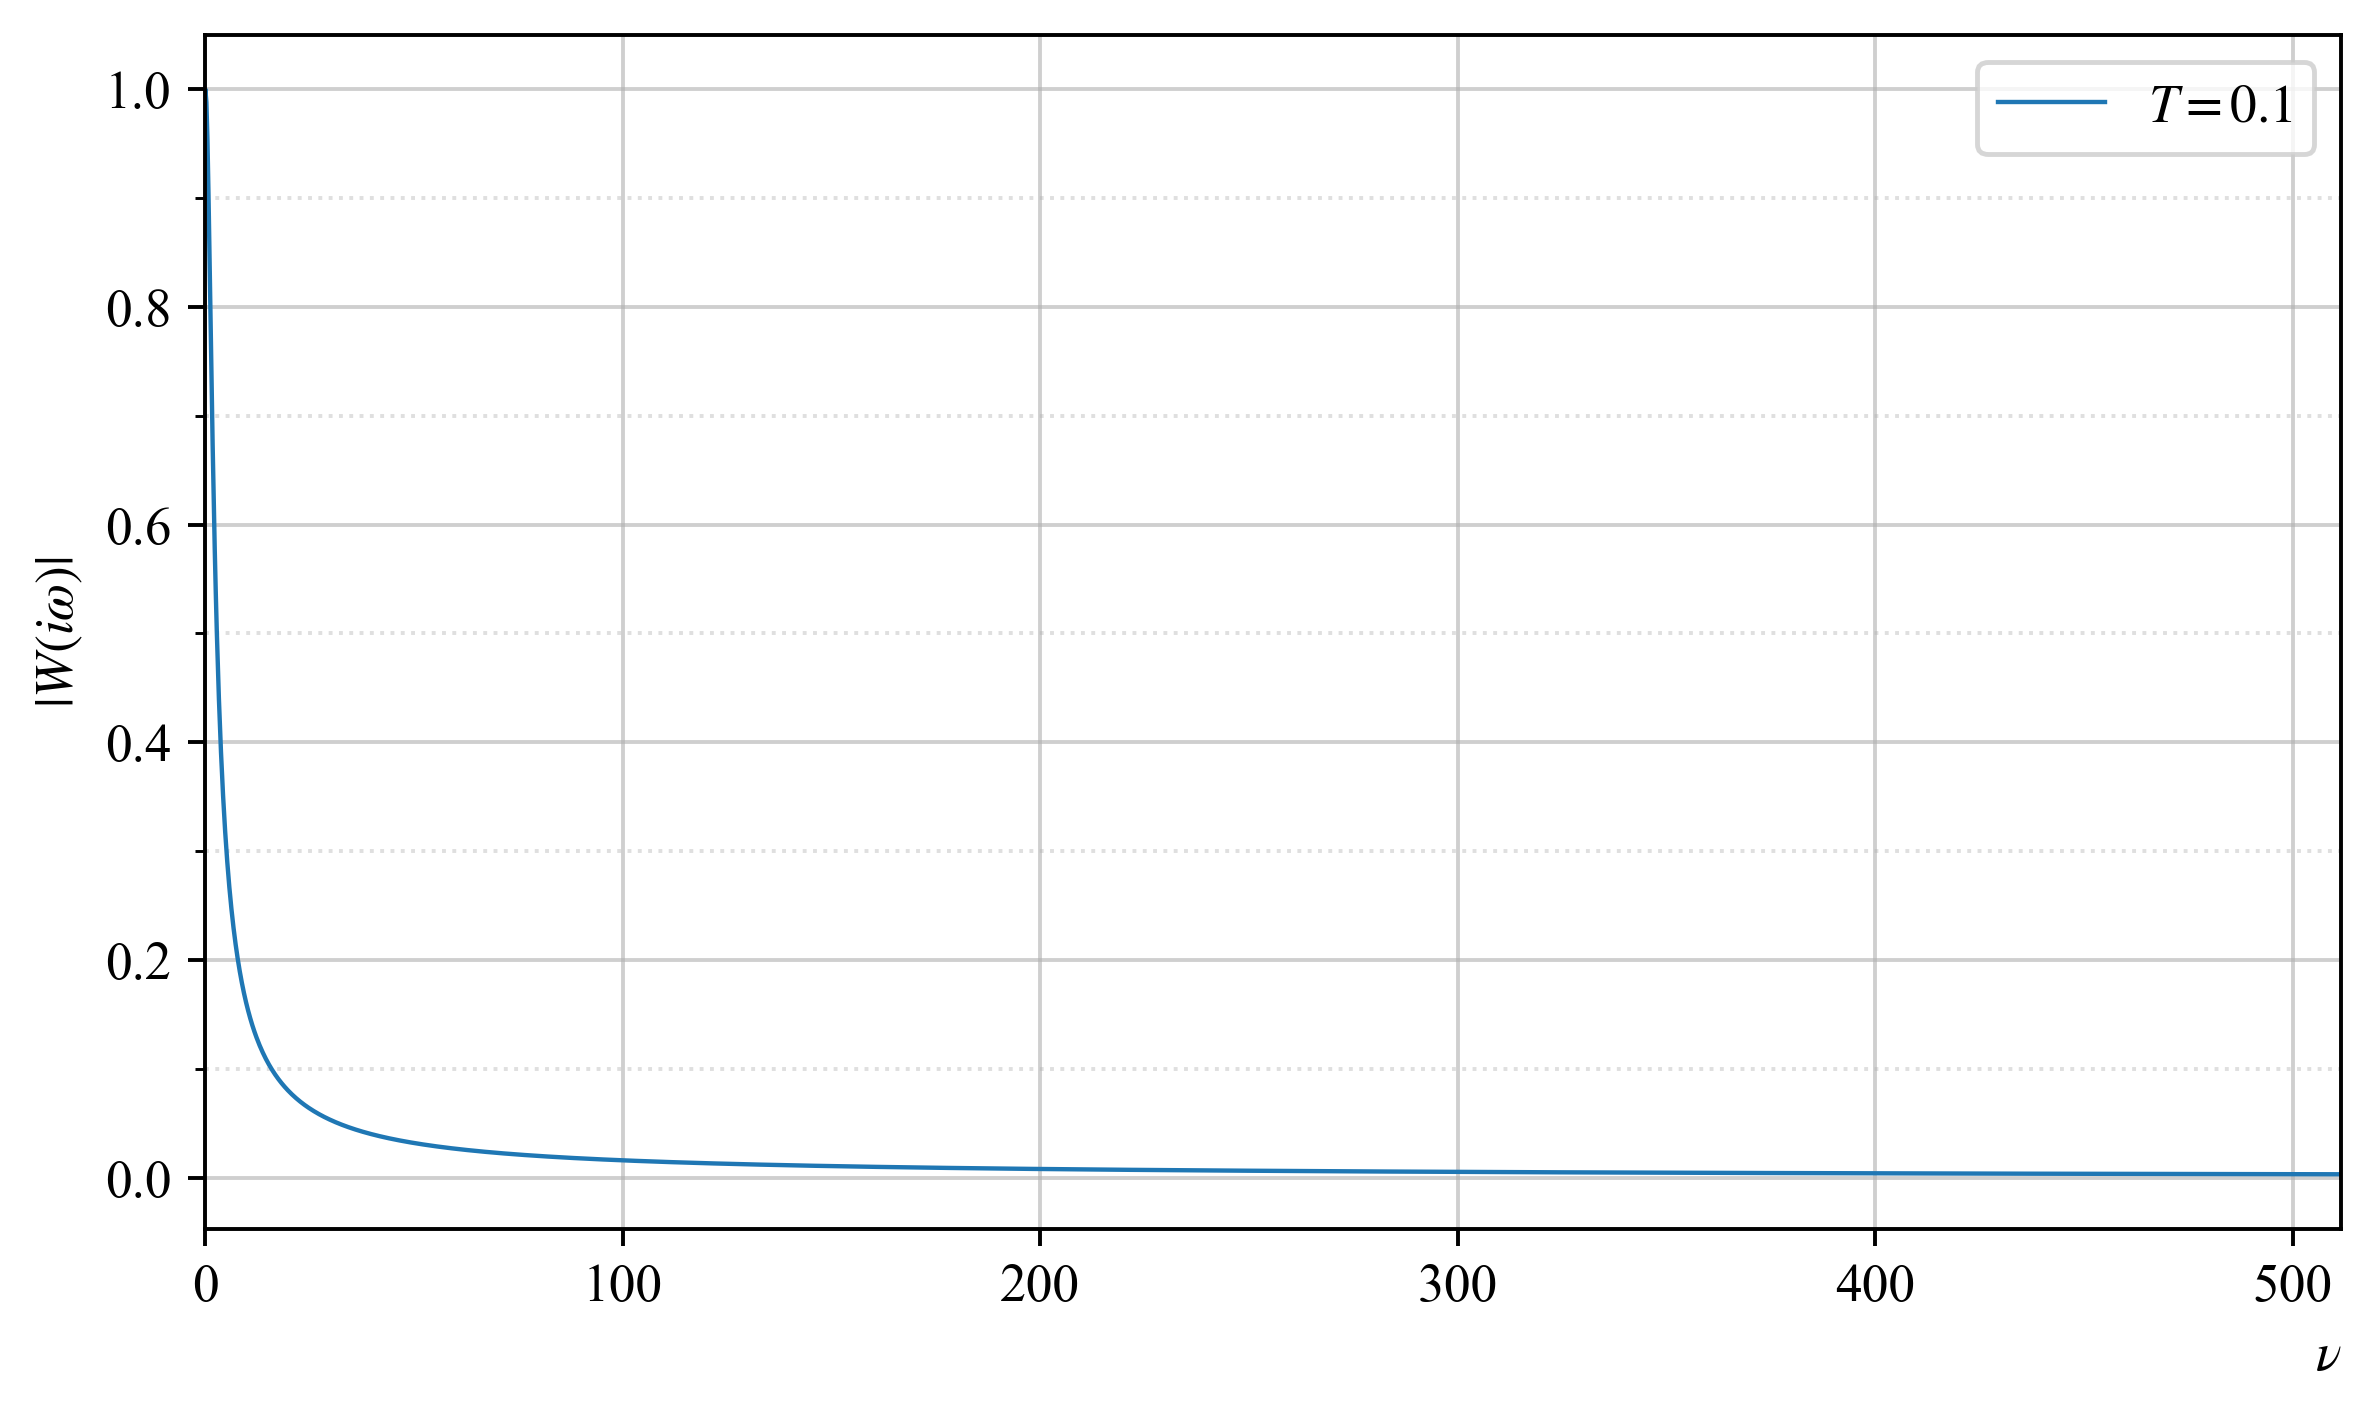

In [7]:
%mkdir -p ../fig/1/1/T/func
%mkdir -p ../fig/1/1/T/fr

for i, N in enumerate((1e-3, 1e-2, 1e-1)):
    plt.figure()

    filtered_signal = apply_W_dynamic(t, signal, W1_tf(N))

    plt.plot(t, signal, 'r-', alpha=.5, linewidth=.9, label='зашумленный сигнал')
    plt.plot(t, filtered_signal, 'g-', alpha=.8, linewidth=.9, label='фильтрованный сигнал')
    plt.plot(t, clean_signal, 'k--', alpha=.6, linewidth=.9, label='исходный сигнал')
    plt.legend()

    plt.savefig(f"../fig/1/1/T/func/{i}.png")

    plt.figure()

    plot_freq_response(W1_tf(N), plt.gca(), t)

    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(100))
    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.grid(which='minor', linestyle=':', alpha=0.4)
    plt.grid(which='major', linestyle='-', alpha=0.6)

    plt.legend([f'$T={N}$'])

    plt.savefig(f"../fig/1/1/T/fr/{i}.png")

## Вариация параметра a

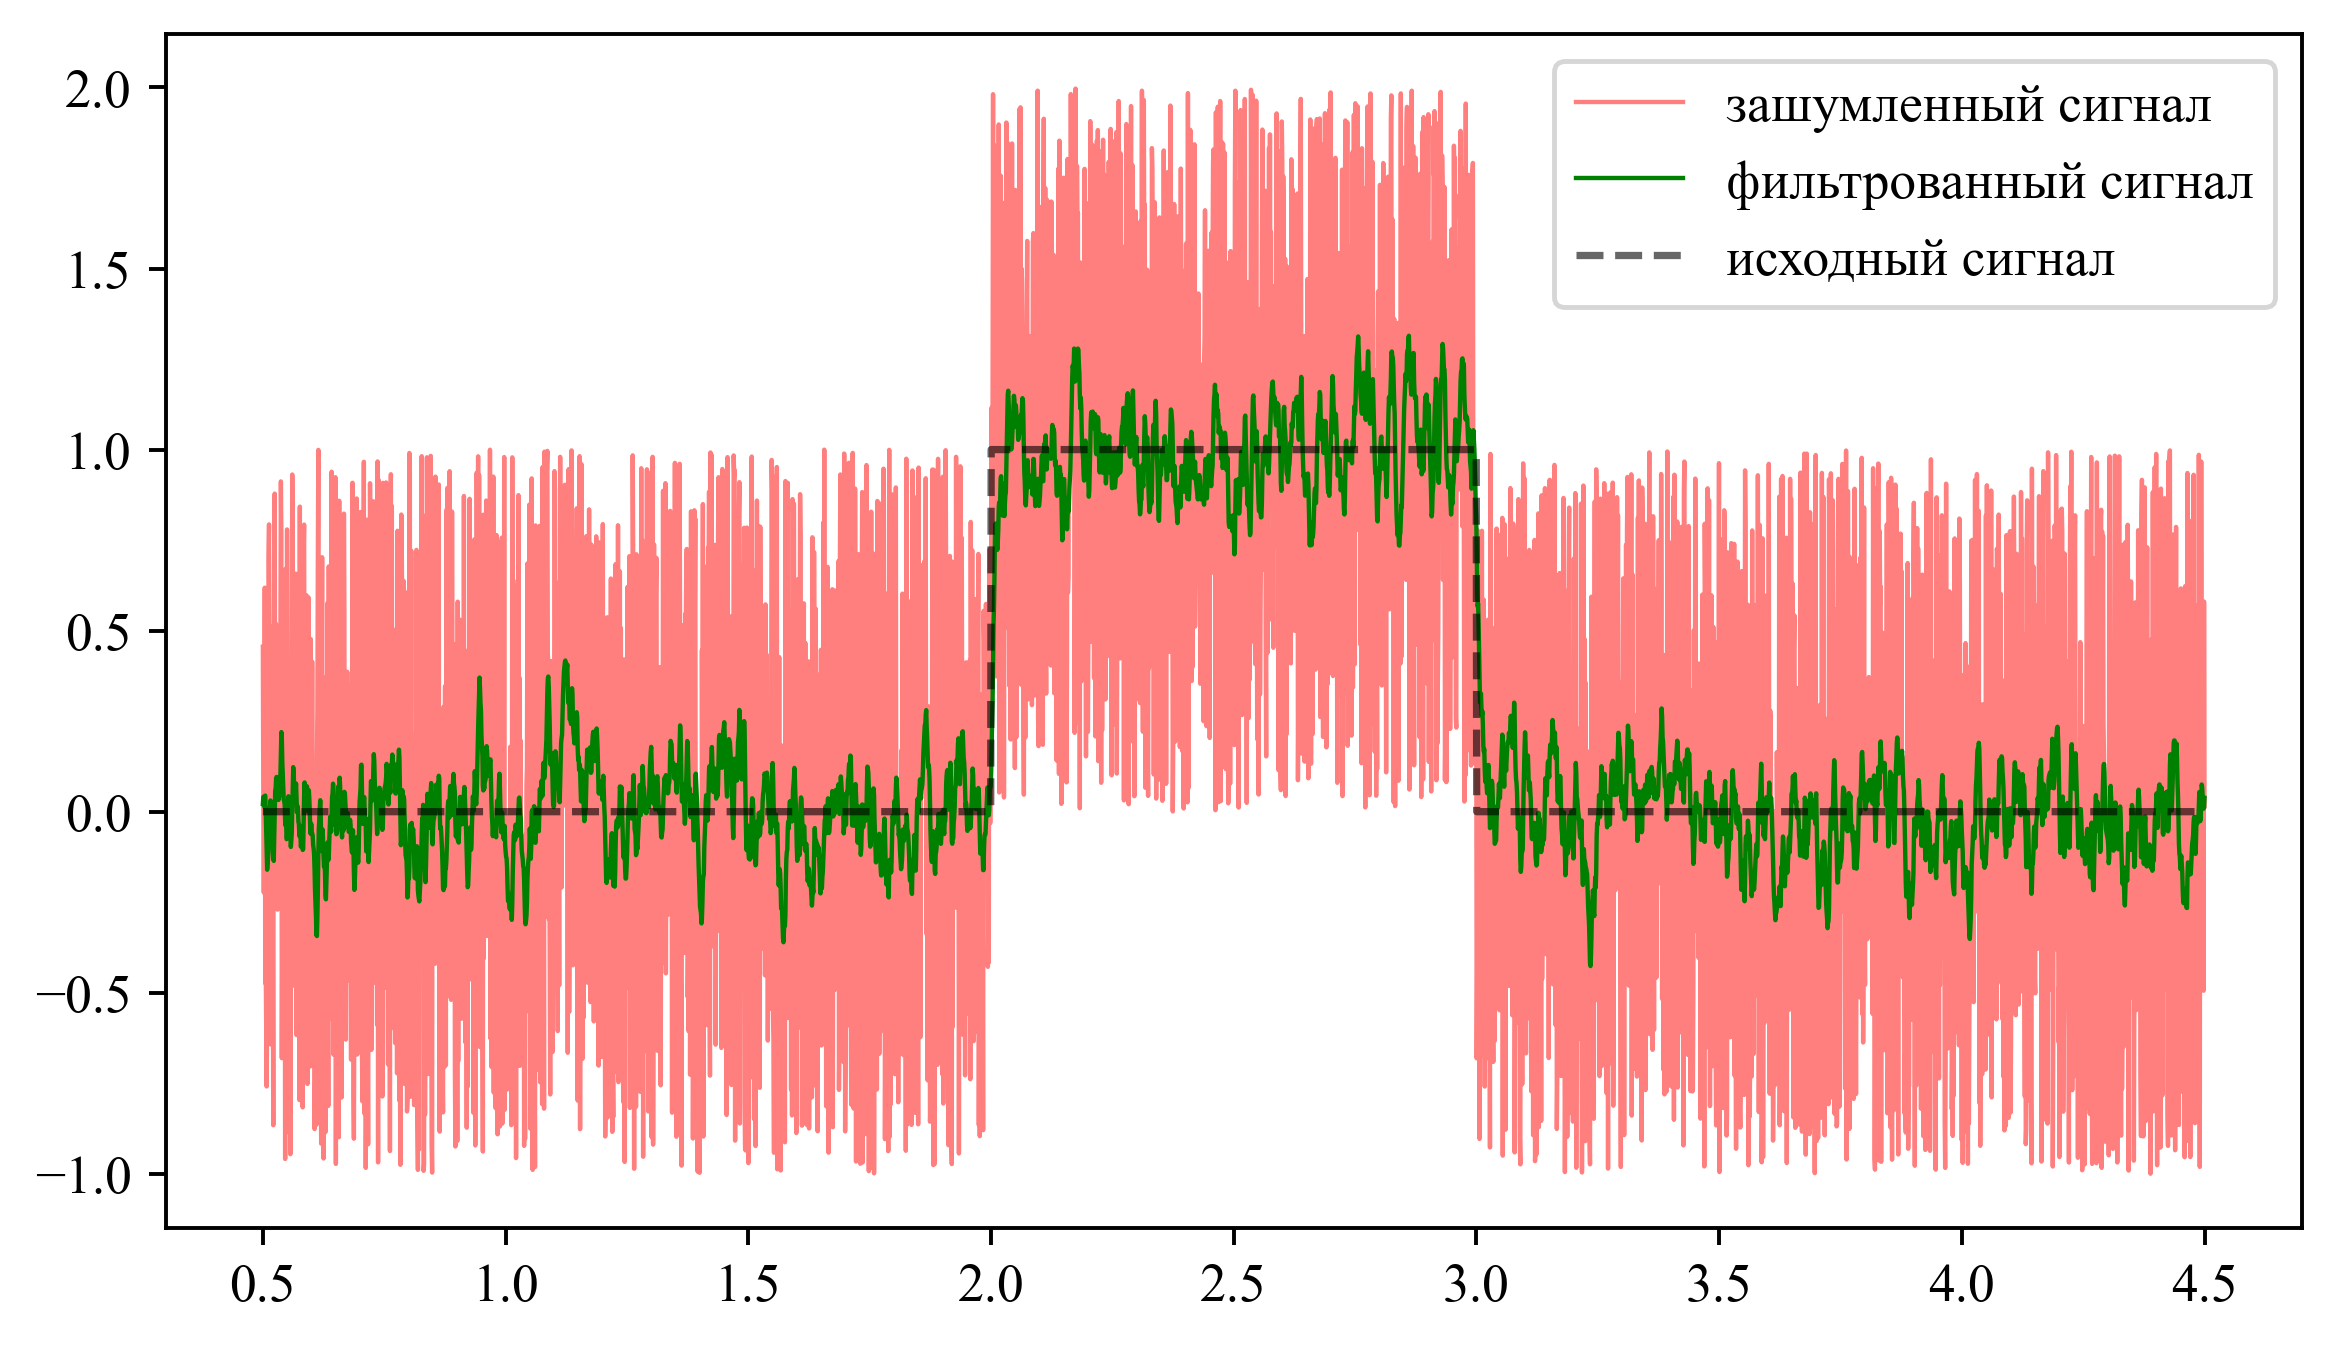

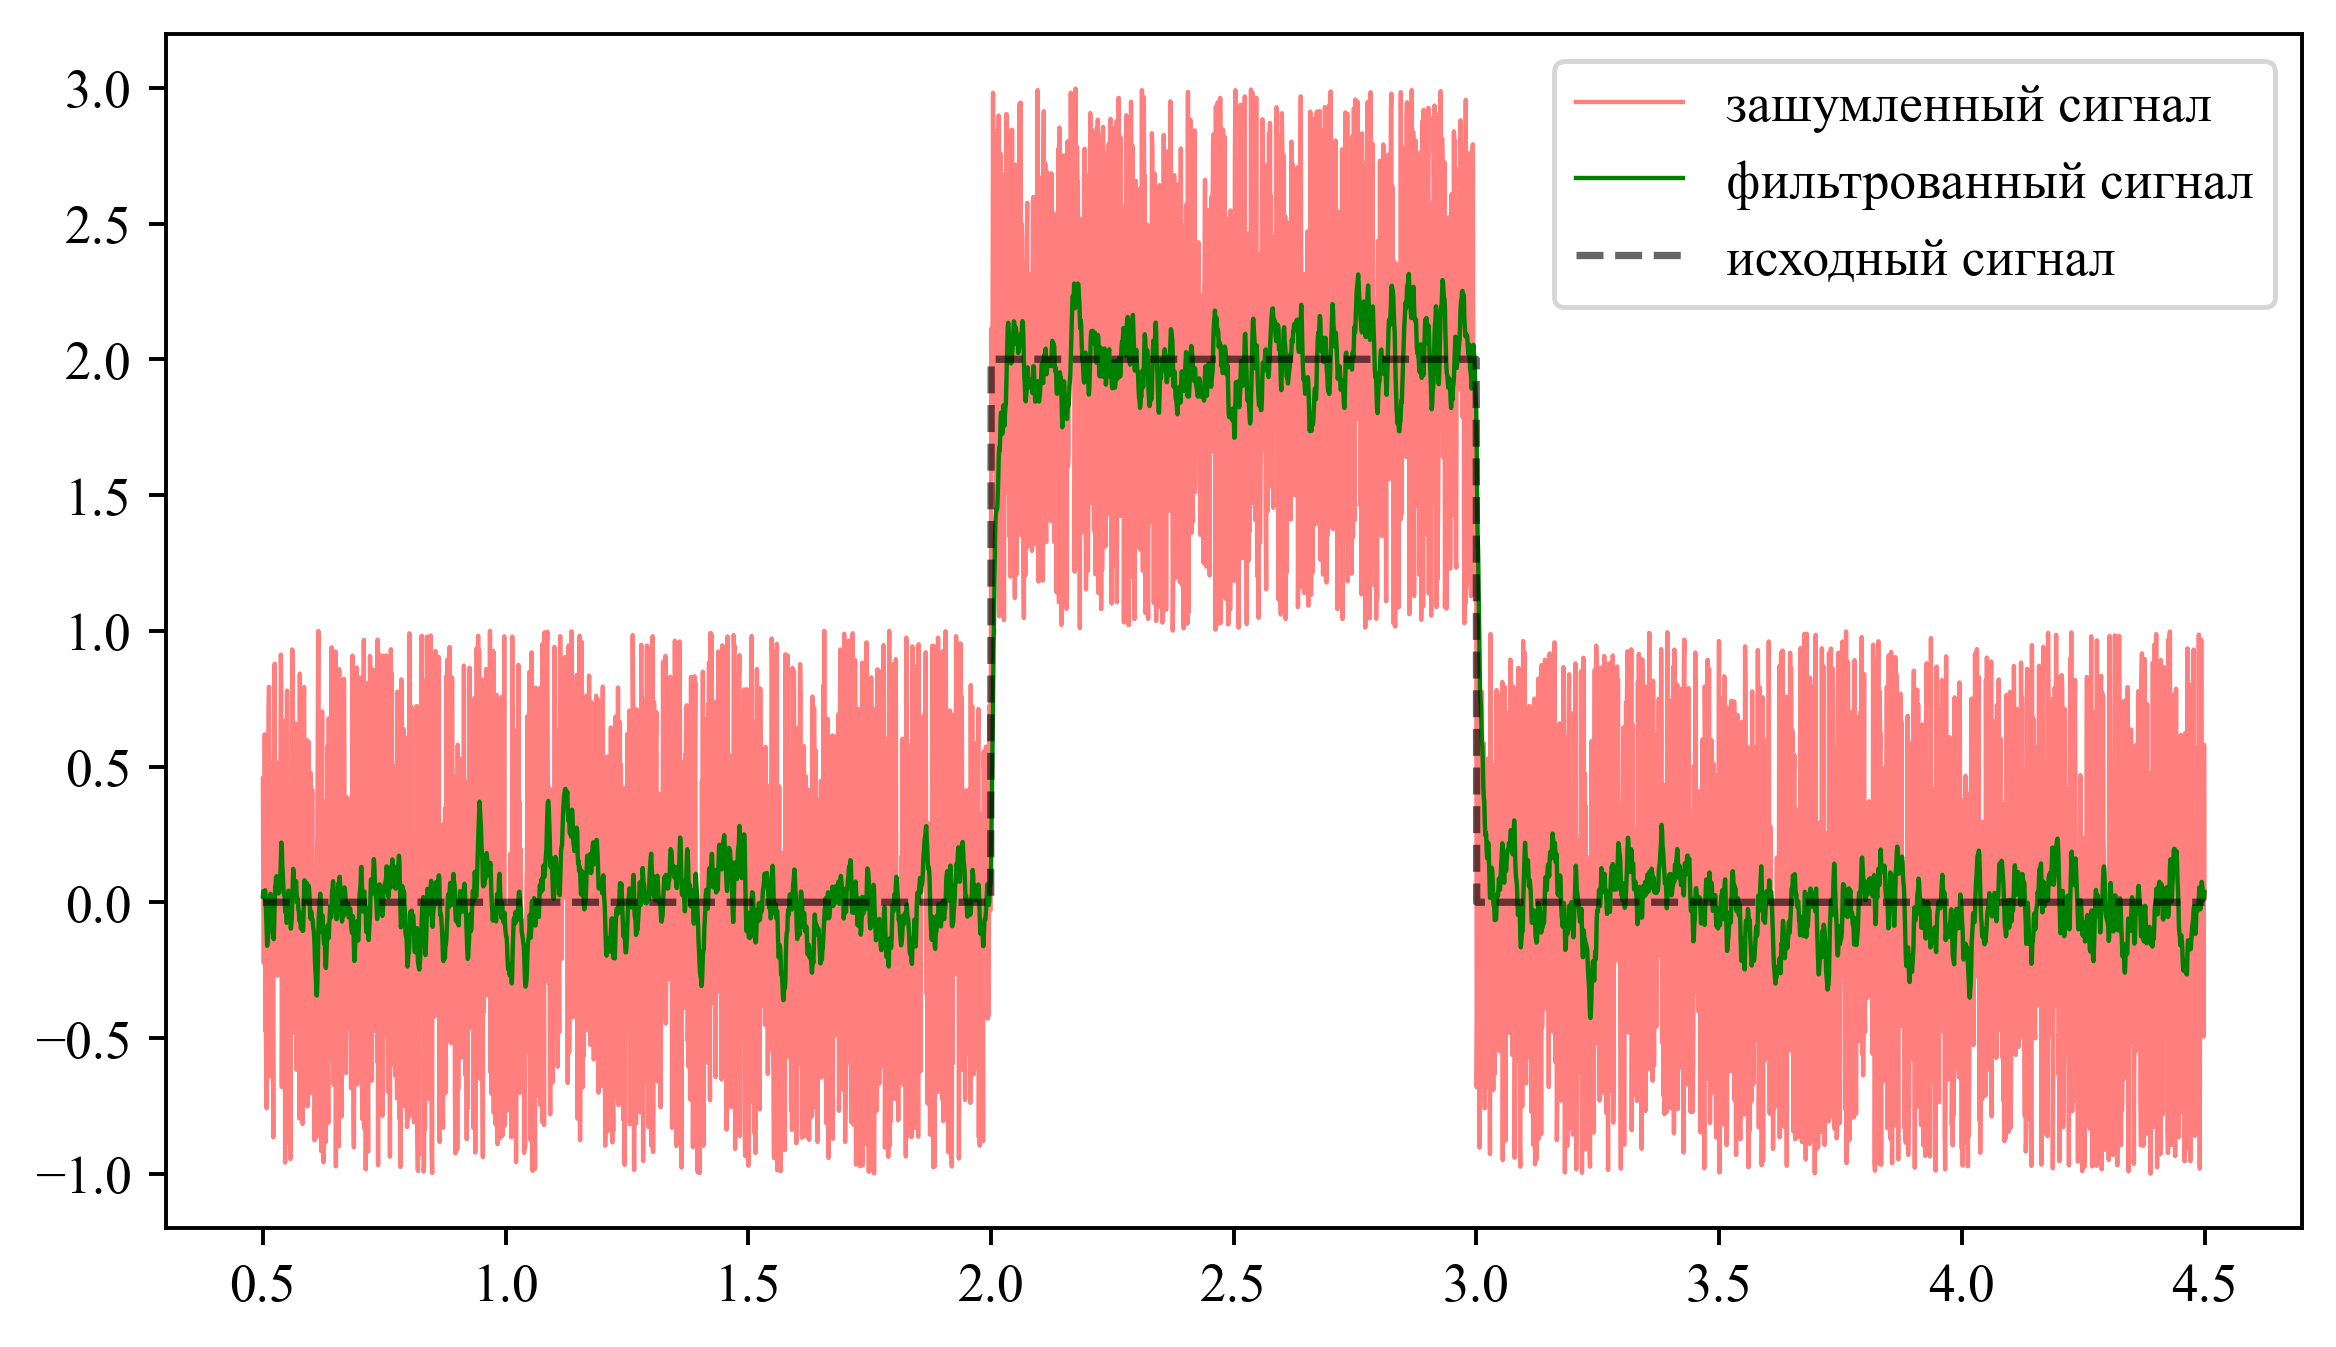

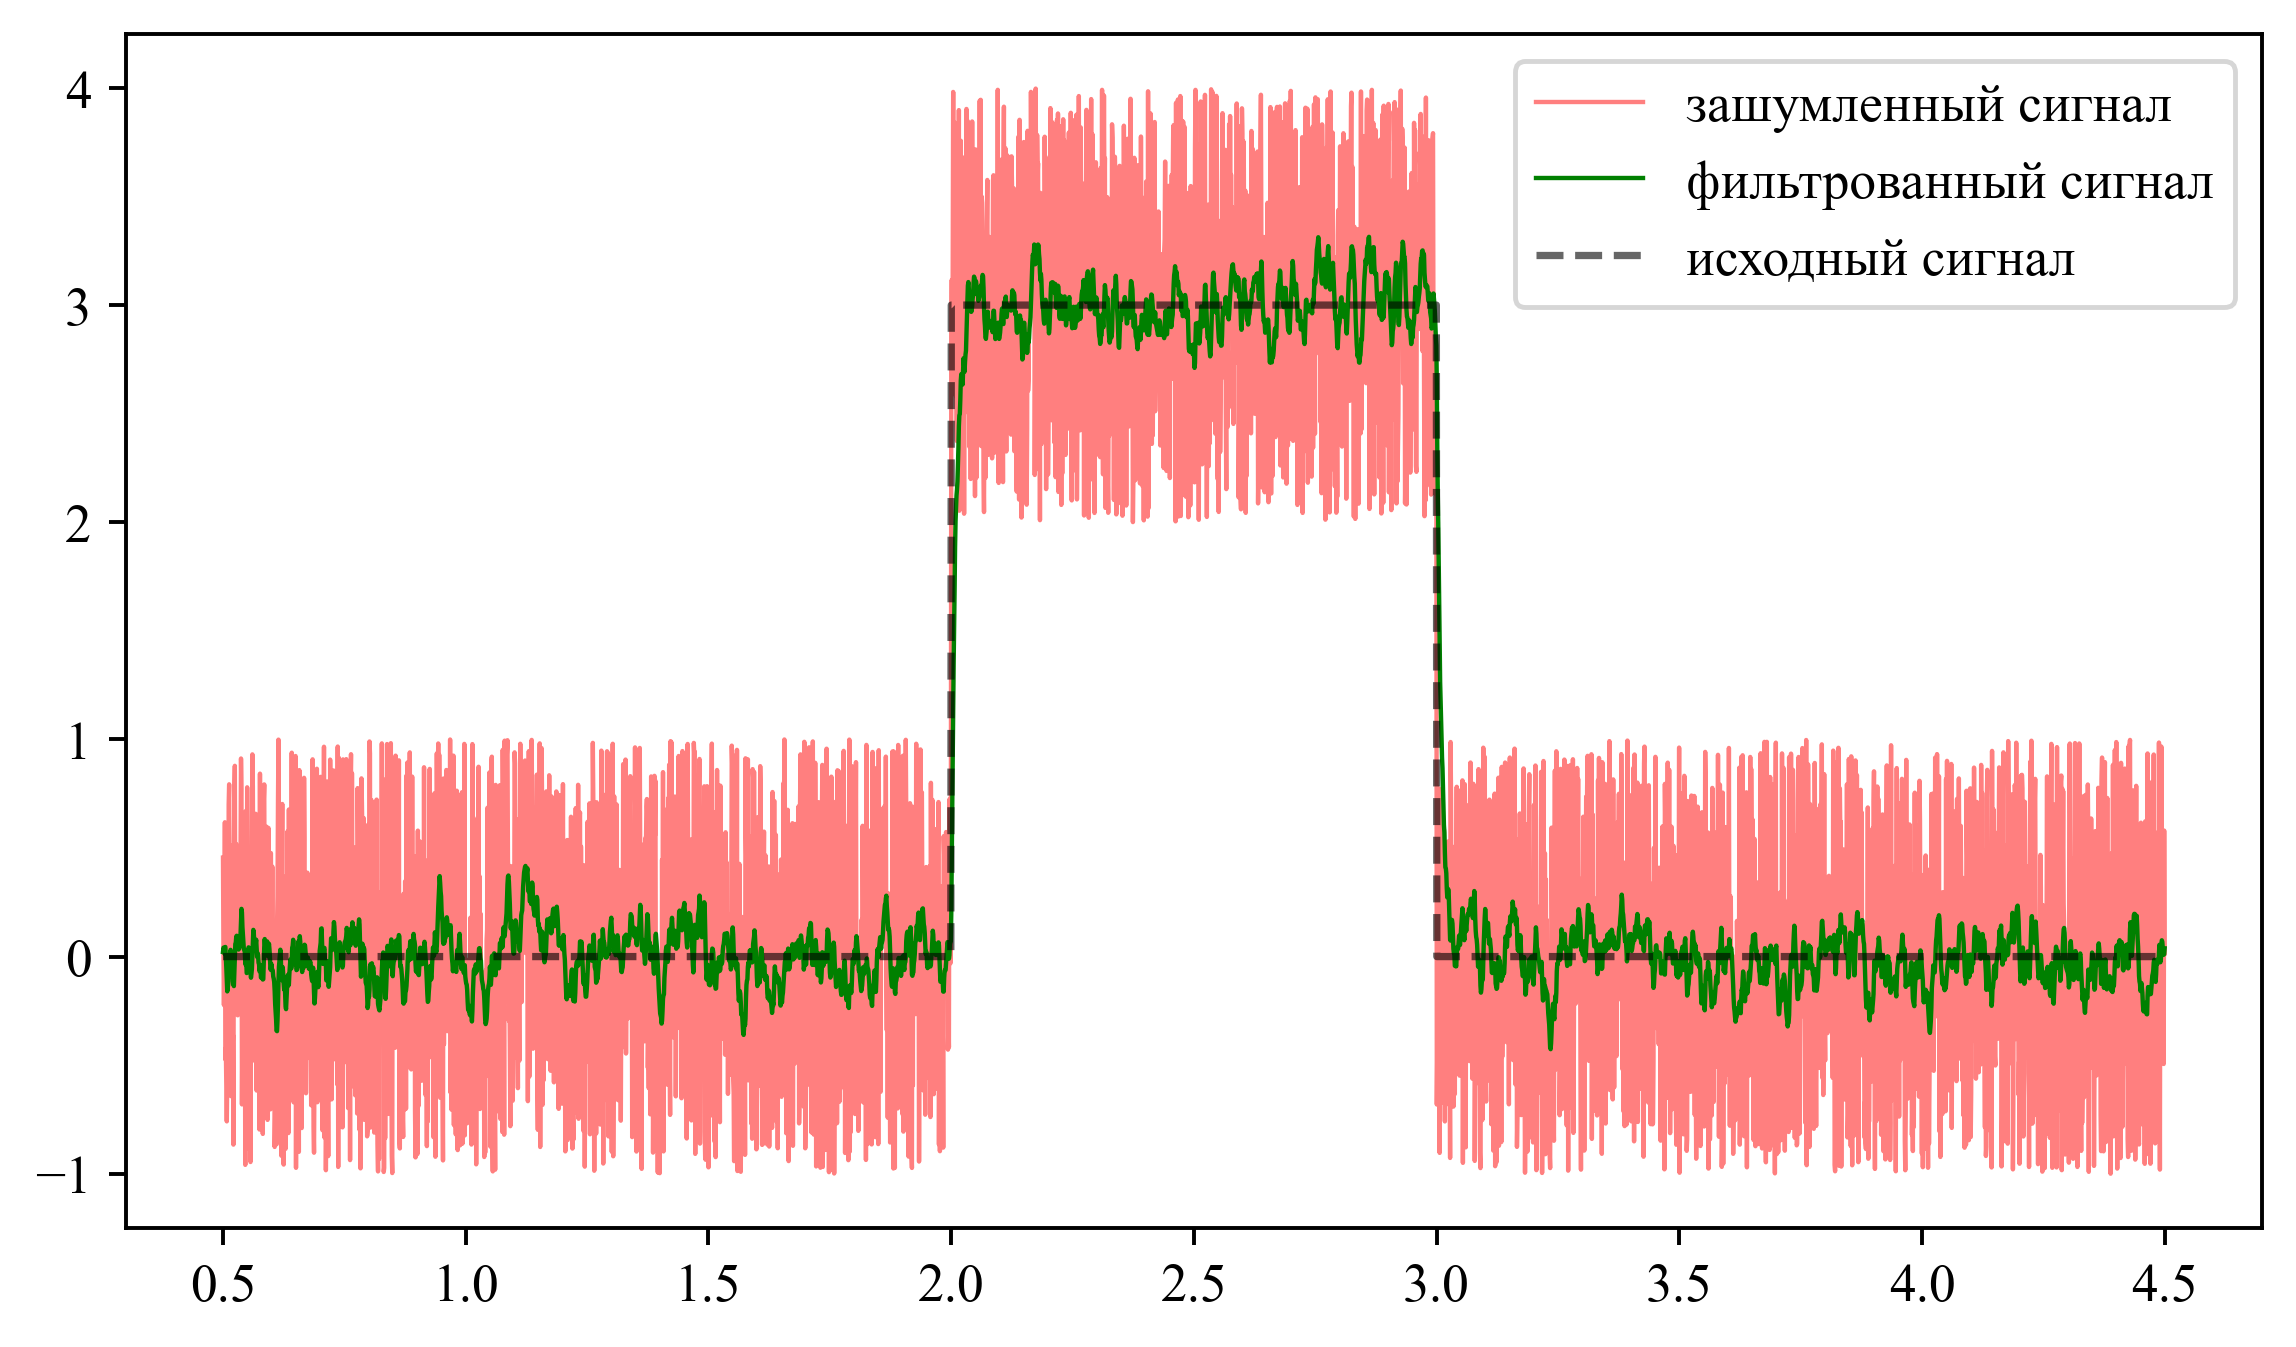

In [8]:
%mkdir -p ../fig/1/1/a

noise = xi(t)
w = W1_tf(.01)

for i, a in enumerate((1,2,3), start=3):

    clean_signal1 = g_(a, 2, 3)(t)
    noisy_signal1 = clean_signal1 + noise

    filtered_signal = apply_W_dynamic(t, noisy_signal1, w)

    plt.figure(num=i)
    plt.plot(t, noisy_signal1, 'r-', alpha=.5, label='зашумленный сигнал')
    plt.plot(t, filtered_signal, 'g-', label='фильтрованный сигнал')
    plt.plot(t, clean_signal1, 'k--', linewidth=1.5, alpha=.6, label='исходный сигнал')
    plt.legend()

    plt.savefig(f"../fig/1/1/a/{i}.png")

## Сравнение фильтрованного и произведения

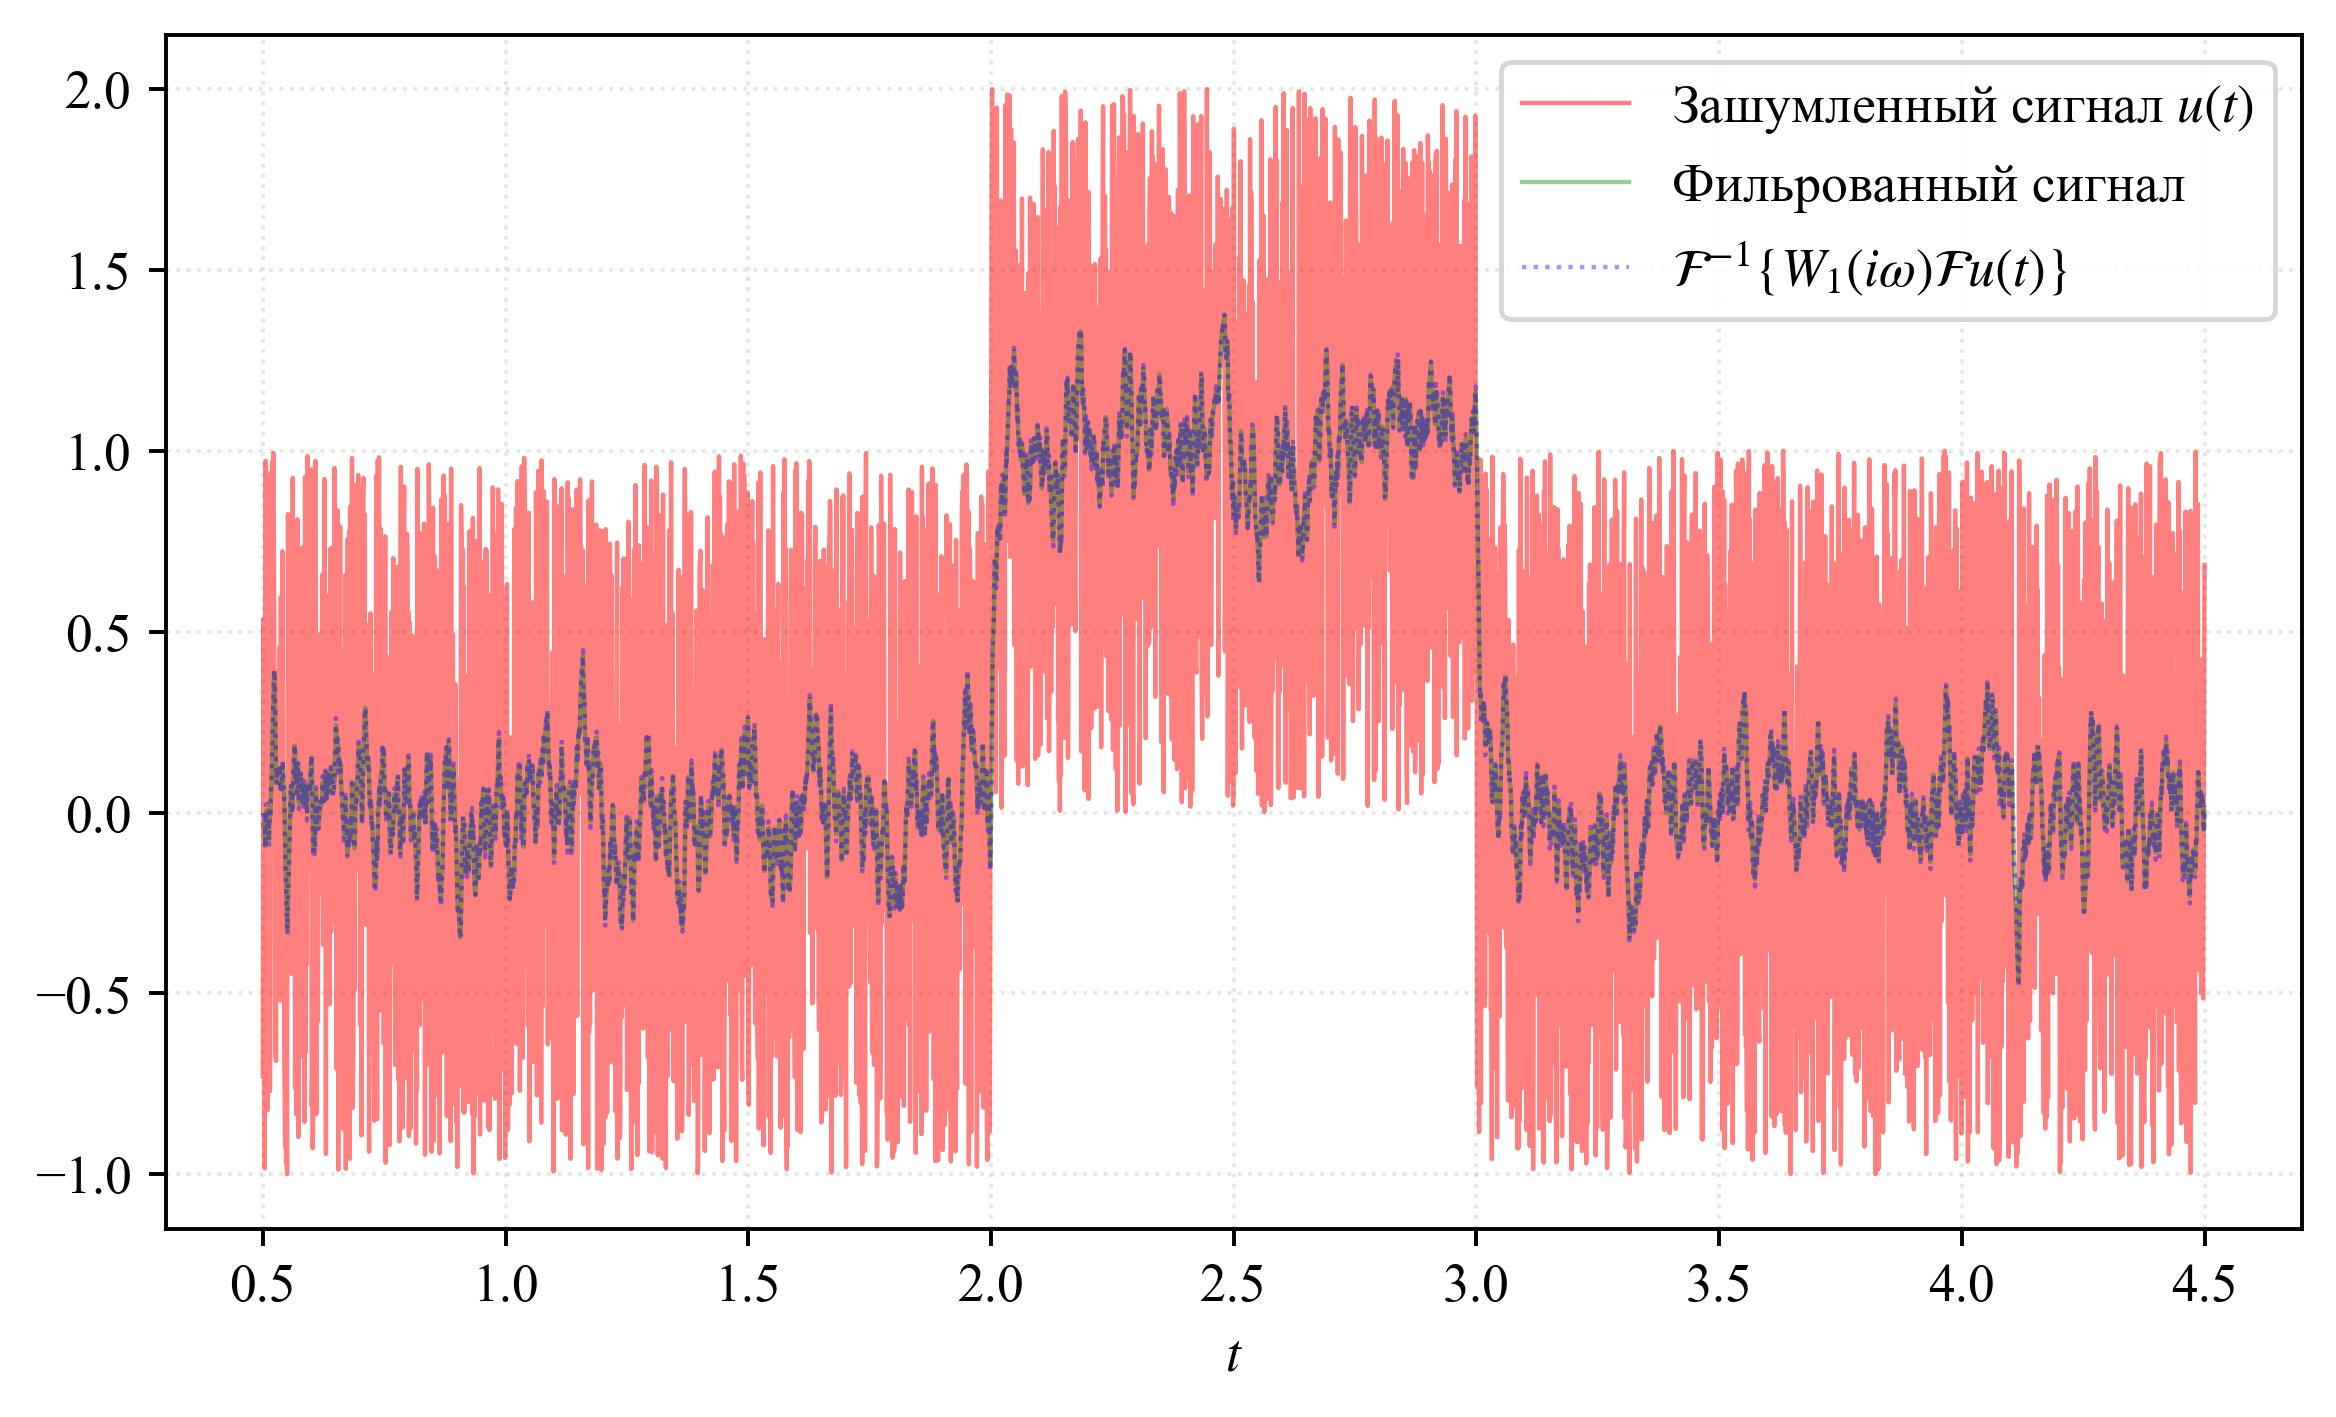

In [9]:
%mkdir -p ../fig/1/1/comp

plt.figure()

y_out = apply_W_dynamic(t, signal, W1_tf(.01))
out2 = apply_W_nondynamic(t, signal, W1_tf(.01))


plt.plot(t, signal, 'r-', alpha=0.5, label='Зашумленный сигнал $u(t)$')
plt.plot(t, y_out, 'g-', alpha=.4, label='Фильрованный сигнал')
plt.plot(t, out2, 'b:', alpha=.4, label="$\\mathcal{F}^{-1}\\{W_{1}(i \\omega)\\mathcal{F}u(t)\\}$")

plt.xlabel('$t$')
plt.grid(which='major', linestyle=':', alpha=.3)
plt.legend()

plt.savefig("../fig/1/1/comp/1.png")


## Сравнение Фурье-образов

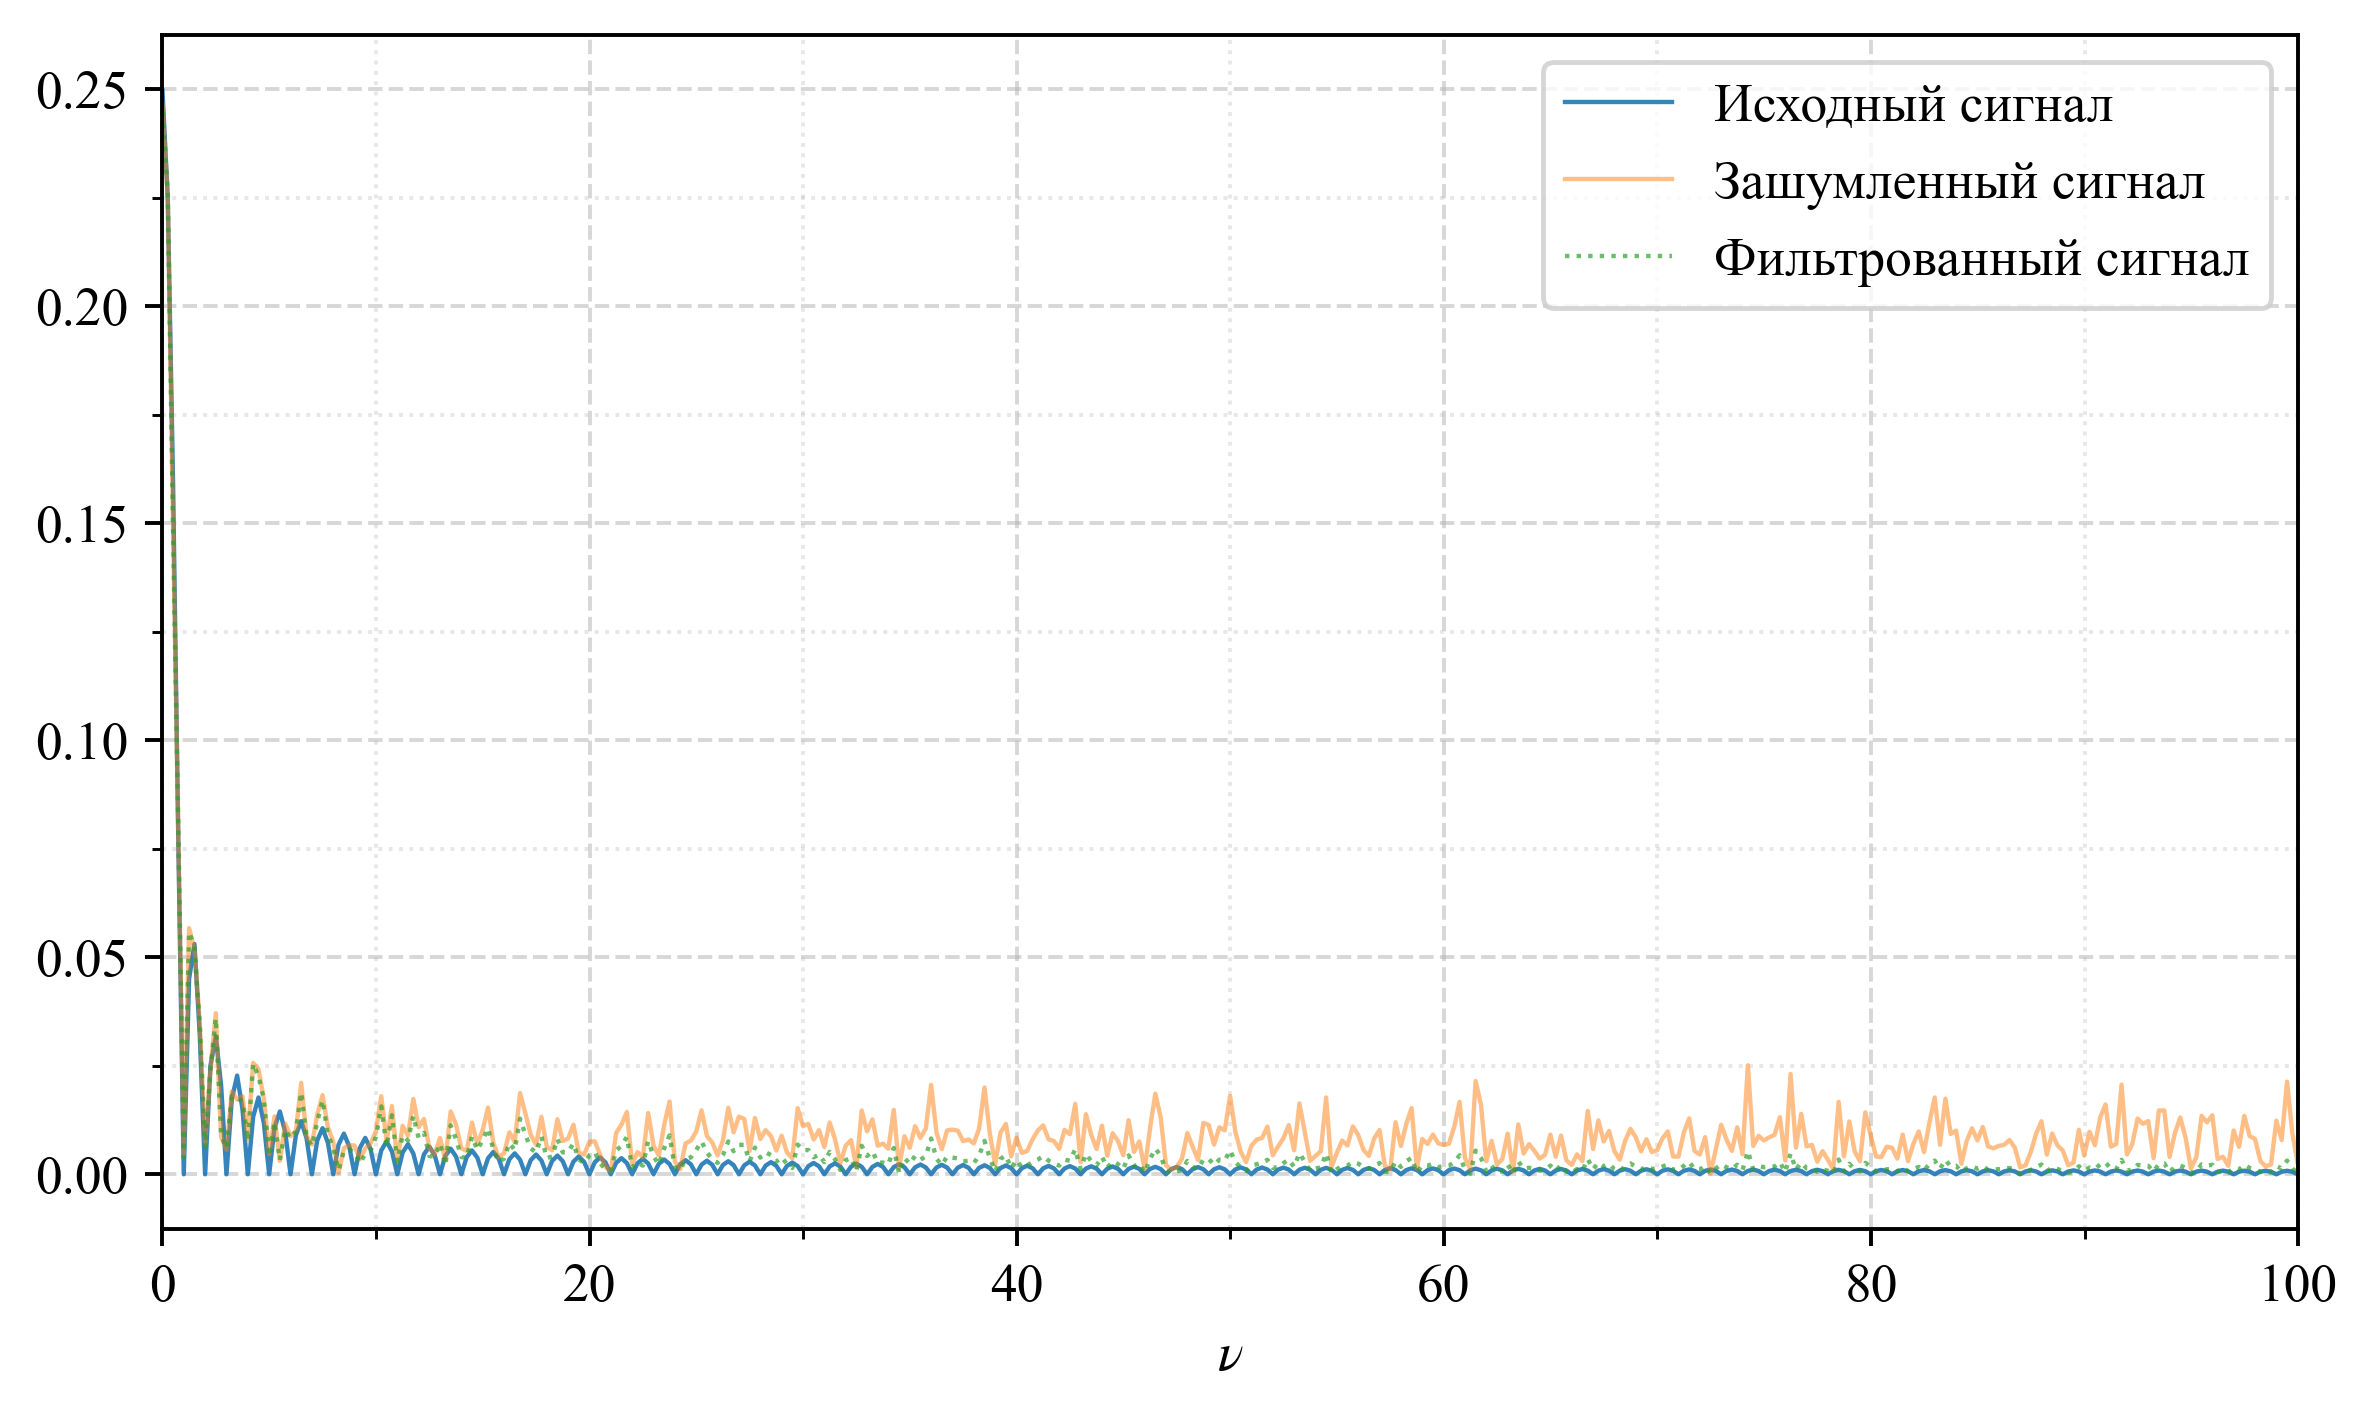

In [10]:
plt.figure()

clean_signal = g(t)
noisy_signal1 = g(t) + xi(t)
filtered_signal = apply_W_dynamic(t, noisy_signal1, W1_tf(0.01))

fr = np.fft.fftfreq(t.size, d=t[1]-t[0])
fr = np.fft.fftshift(fr)

clean_fft = np.abs(np.fft.fft(clean_signal))/t.size
clean_fft = np.fft.fftshift(clean_fft)

noisy_fft = np.abs(np.fft.fft(noisy_signal1))/t.size
noisy_fft = np.fft.fftshift(noisy_fft)

filtered_fft = np.abs(np.fft.fft(filtered_signal))/t.size
filtered_fft = np.fft.fftshift(filtered_fft)

plt.xlim(0, 100)

plt.plot(fr, clean_fft, alpha=.9)
plt.plot(fr, noisy_fft, alpha=.5)
plt.plot(fr, filtered_fft, alpha=.7, linestyle=':')

plt.xlabel('$\\nu$')
plt.legend(['Исходный сигнал', 'Зашумленный сигнал', 'Фильтрованный сигнал'])


plt.gca().get_xaxis().set_major_locator(plt.MultipleLocator(20))
plt.gca().get_xaxis().set_minor_locator(plt.MultipleLocator(10))
plt.gca().get_yaxis().set_major_locator(plt.MultipleLocator(.05))
plt.gca().get_yaxis().set_minor_locator(plt.MultipleLocator(.025))

plt.grid(which='major', linestyle='--', alpha=.5)
plt.grid(which='minor', linestyle=':', alpha=.3)

plt.savefig("../fig/1/1/comp/2.png")


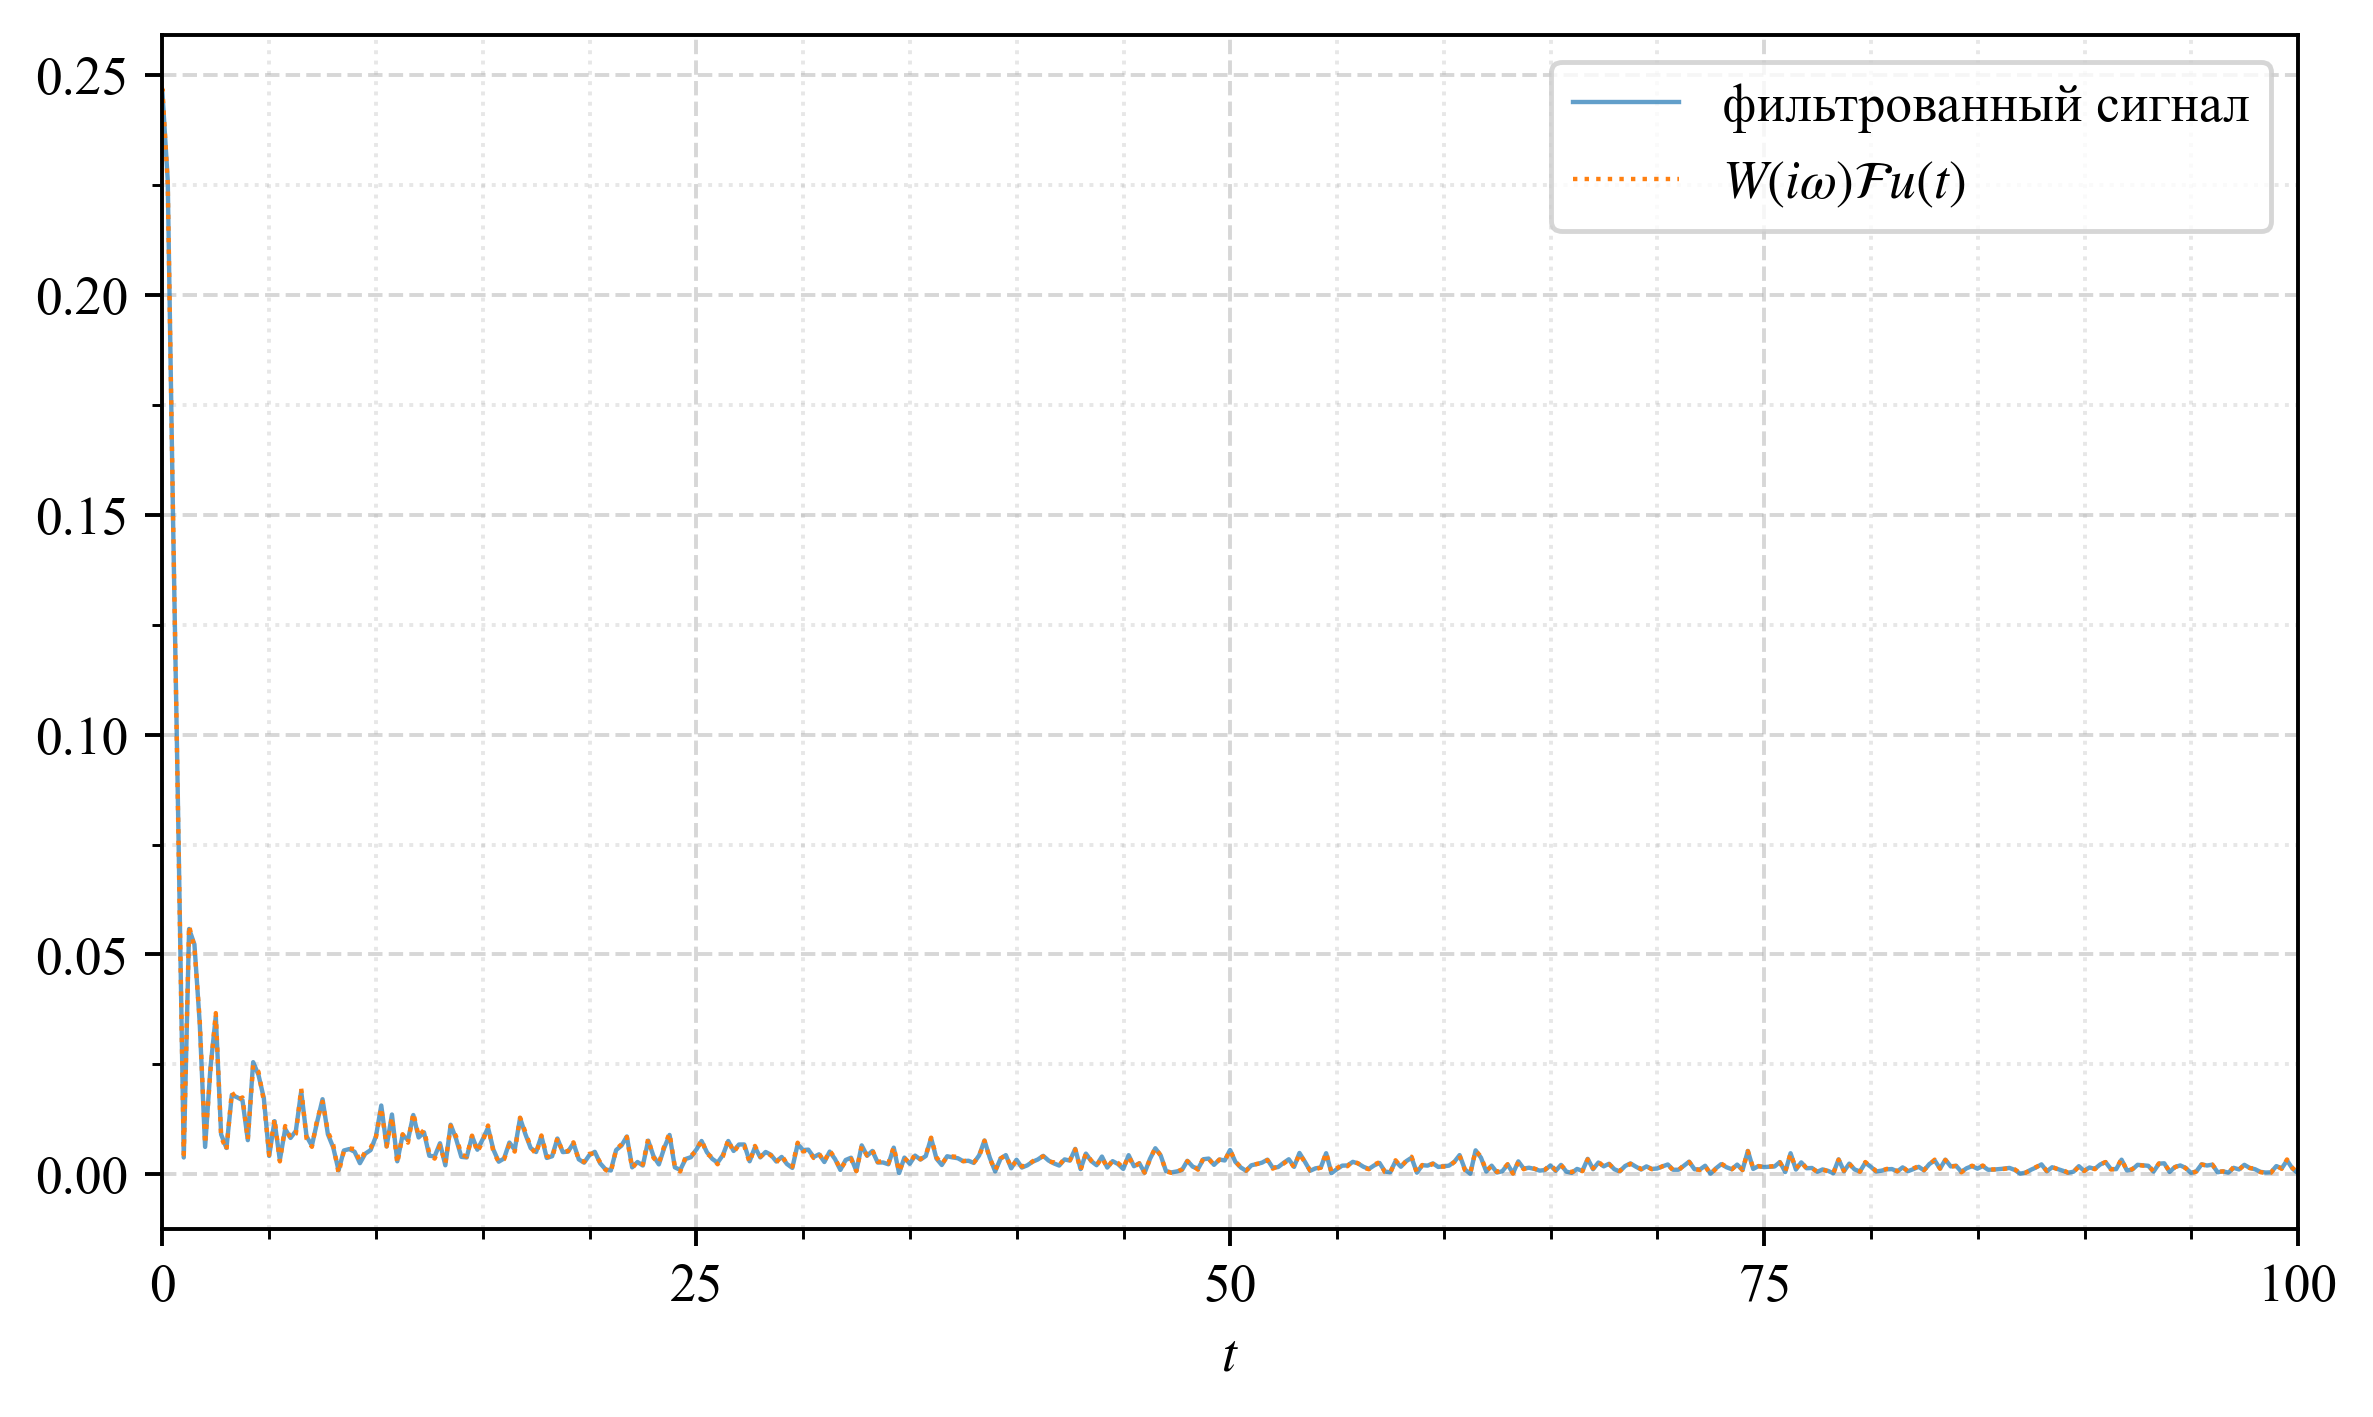

In [11]:
fr = np.fft.fftfreq(t.size, t[1]-t[0])
fr = np.fft.fftshift(fr)

noisy_fft = np.abs(np.fft.fft(noisy_signal1))
noisy_fft = np.fft.fftshift(noisy_fft)

filtered_fft = np.abs(np.fft.fft(apply_W_dynamic(t, noisy_signal1, W1_tf(.01))))
filtered_fft = np.fft.fftshift(filtered_fft)

product_fft = W_poly(W1_tf(.01))(1j * 2*np.pi * fr) * noisy_fft
product_fft = np.abs(product_fft)

plt.figure()

plt.xlim(0, 100)
plt.xlabel("$t$")

plt.gca().get_xaxis().set_major_locator(plt.MultipleLocator(25))
plt.gca().get_xaxis().set_minor_locator(plt.MultipleLocator(5))
plt.gca().get_yaxis().set_major_locator(plt.MultipleLocator(.05))
plt.gca().get_yaxis().set_minor_locator(plt.MultipleLocator(.025))

plt.grid(which='major', linestyle='--', alpha=.5)
plt.grid(which='minor', linestyle=':', alpha=.3)

plt.plot(fr, filtered_fft/fr.size, alpha=.7, label='фильтрованный сигнал')
plt.plot(fr, product_fft/ fr.size, alpha=.99, linestyle=':', label='$W(i\\omega)\\mathcal{F}u(t)$')

plt.legend()
plt.savefig("../fig/1/1/comp/3.png")

# 1.2

In [ ]:
%mkdir -p ../fig/1/2/

noisy_signal1 = noisy_signal(t, 0, 1, 2*np.pi * 20)


In [ ]:

def check_roots(b, c):
    D = np.complex128(b**2 - 4*c)
    roots = np.real((-b + np.sqrt(D))/2), np.real((-b - np.sqrt(D))/2)
    return all(map(lambda x: x < 0, roots)), roots

def W2_tf(a1, a2, b1, b2):
    assert check_roots(b1, b2), "Фильтр неустойчивый"

    return W_tf([1, a1, a2], [1, b1, b2])

def W2(a1, a2, b1, b2):
    roots = check_roots(b1, b2)
    assert roots[0], ("Фильтр неустойчивый", roots[1])

    return lambda p: (p**2 + a1*p + a2)/(p**2 + b1*p + b2)


## Влияние b1 на АЧХ

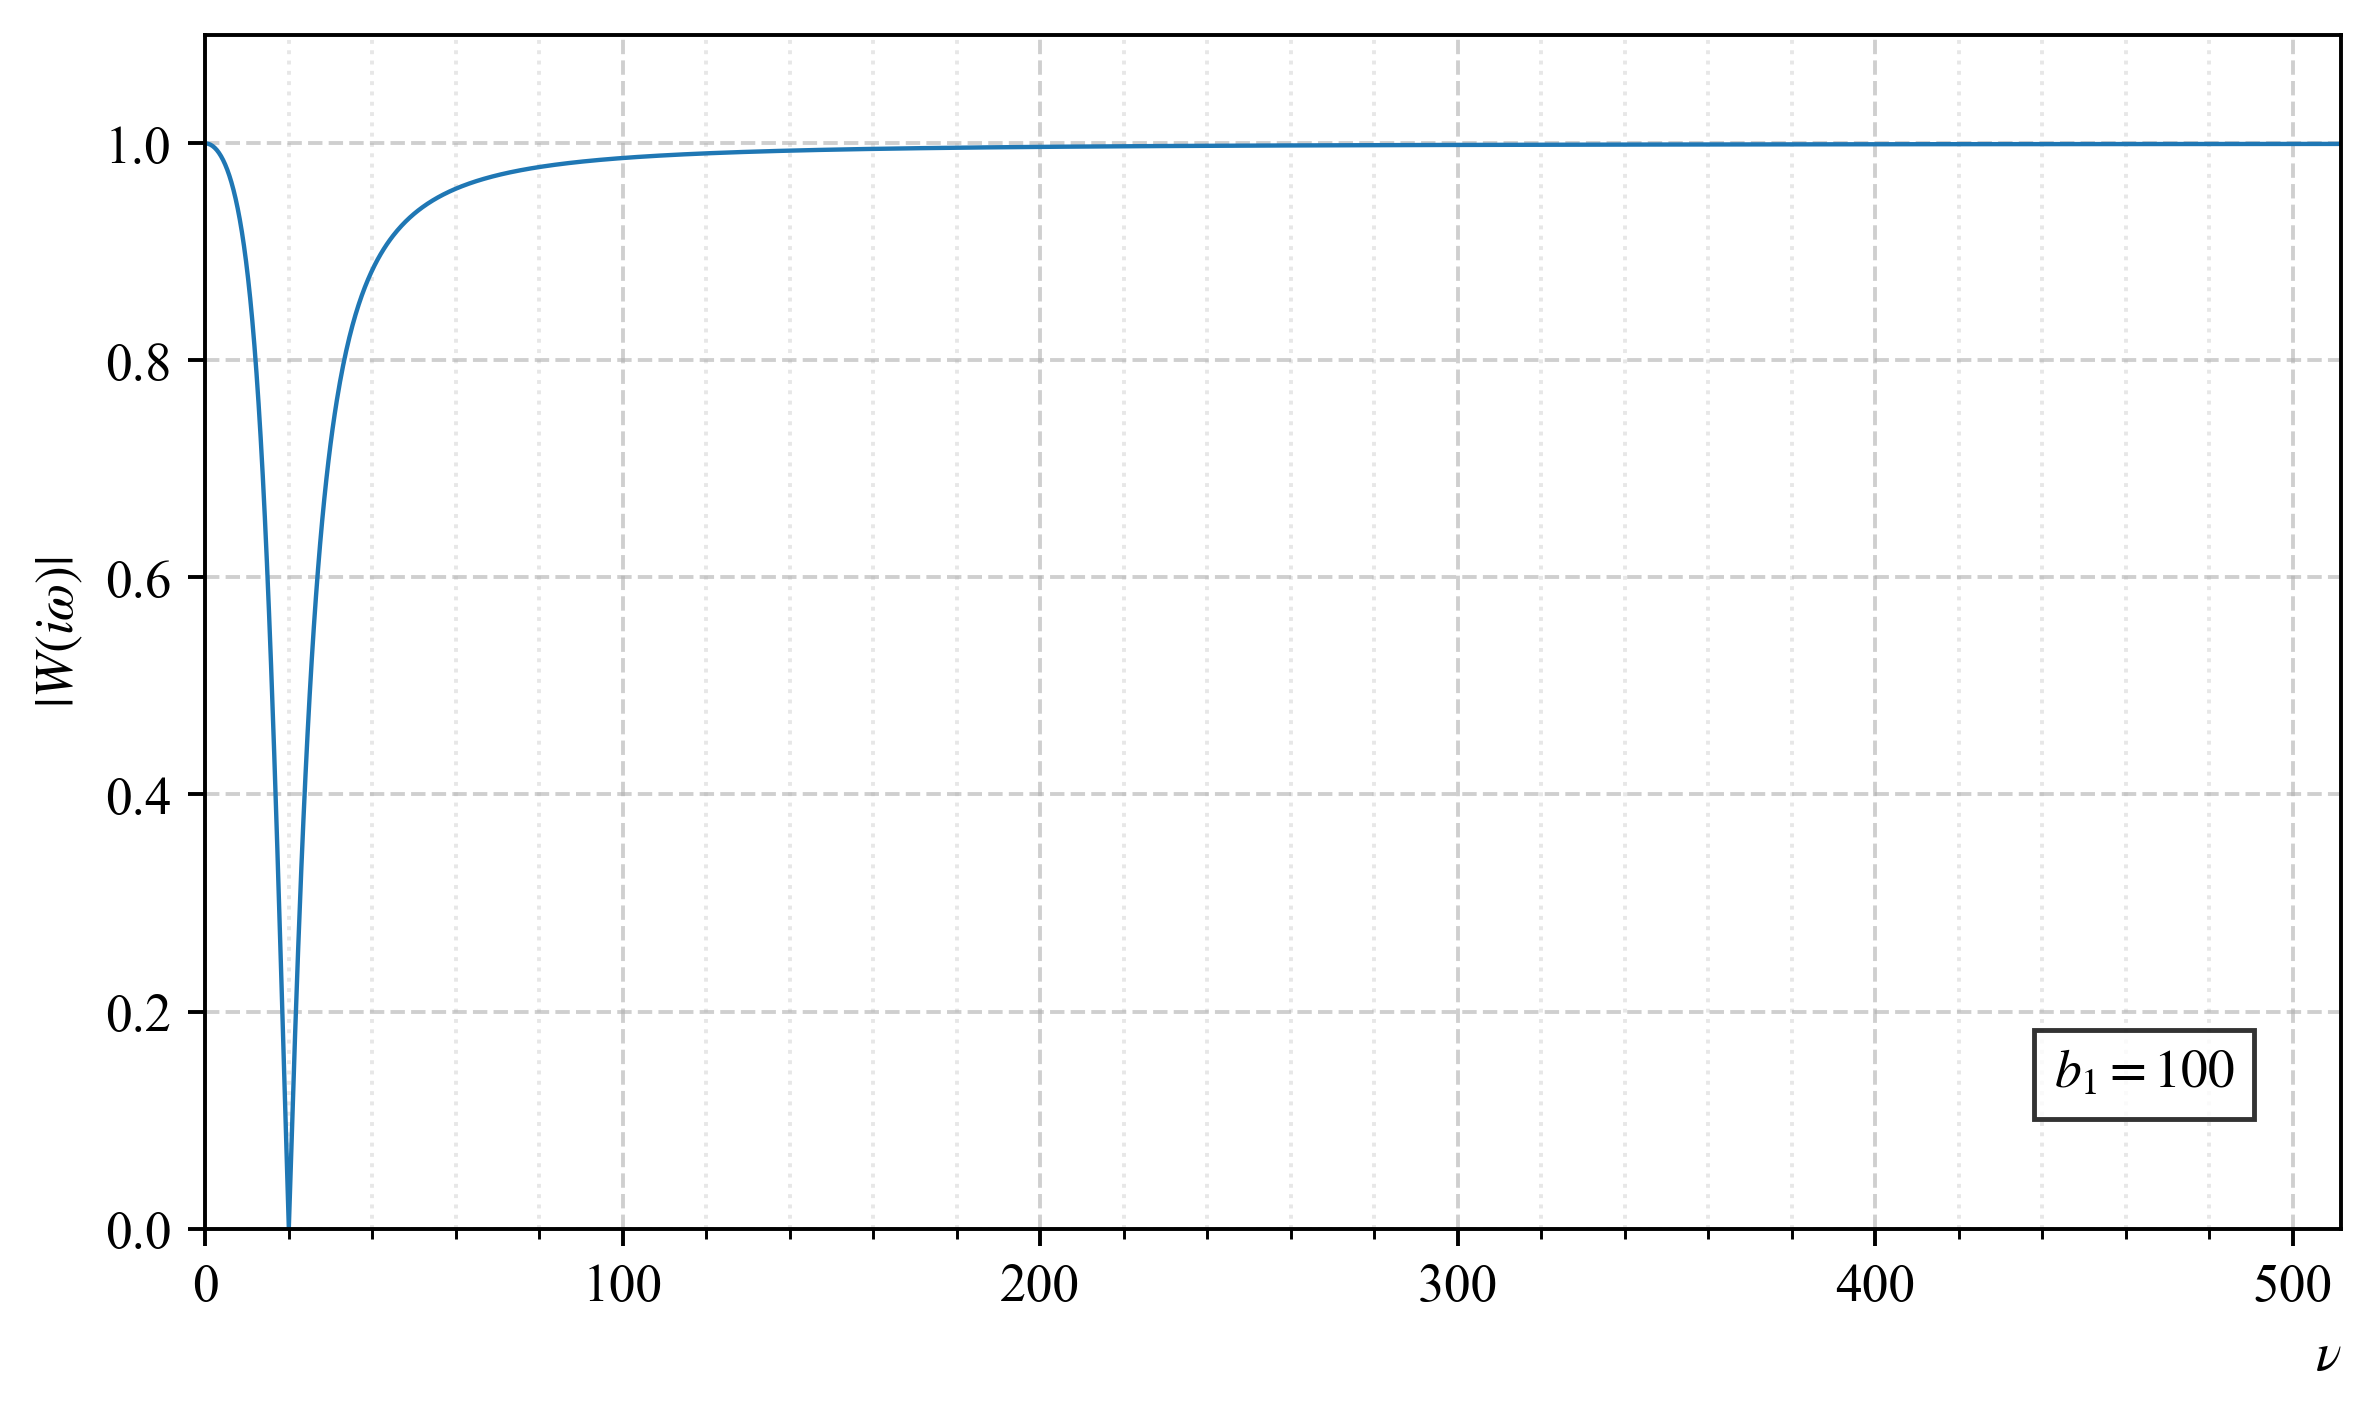

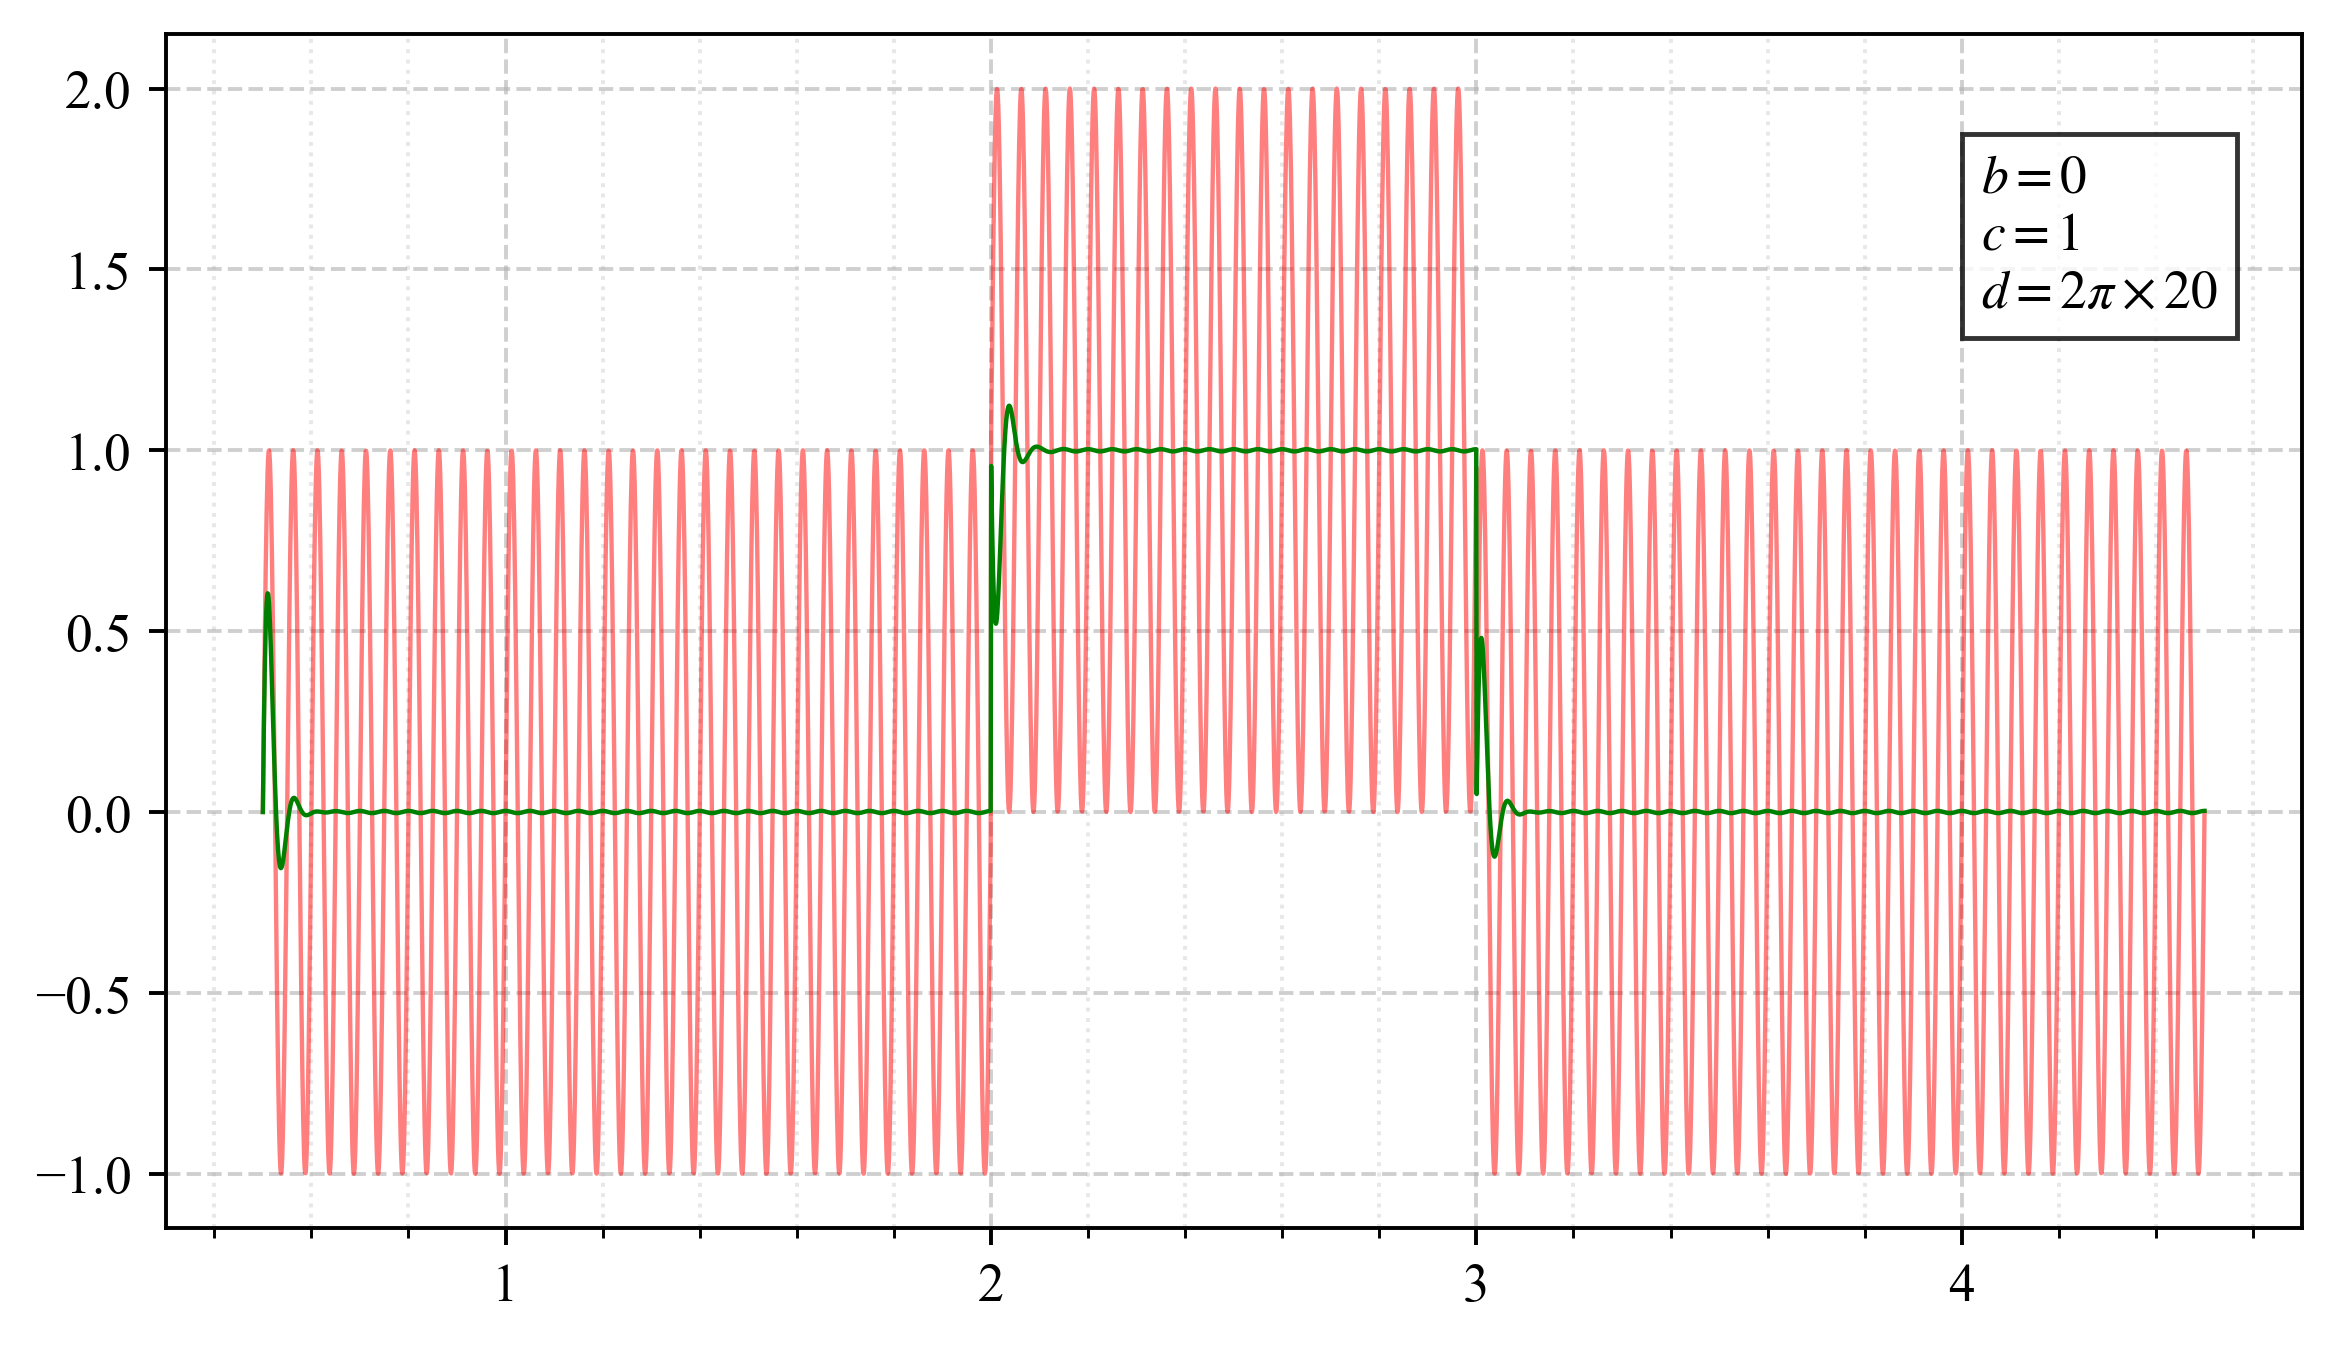

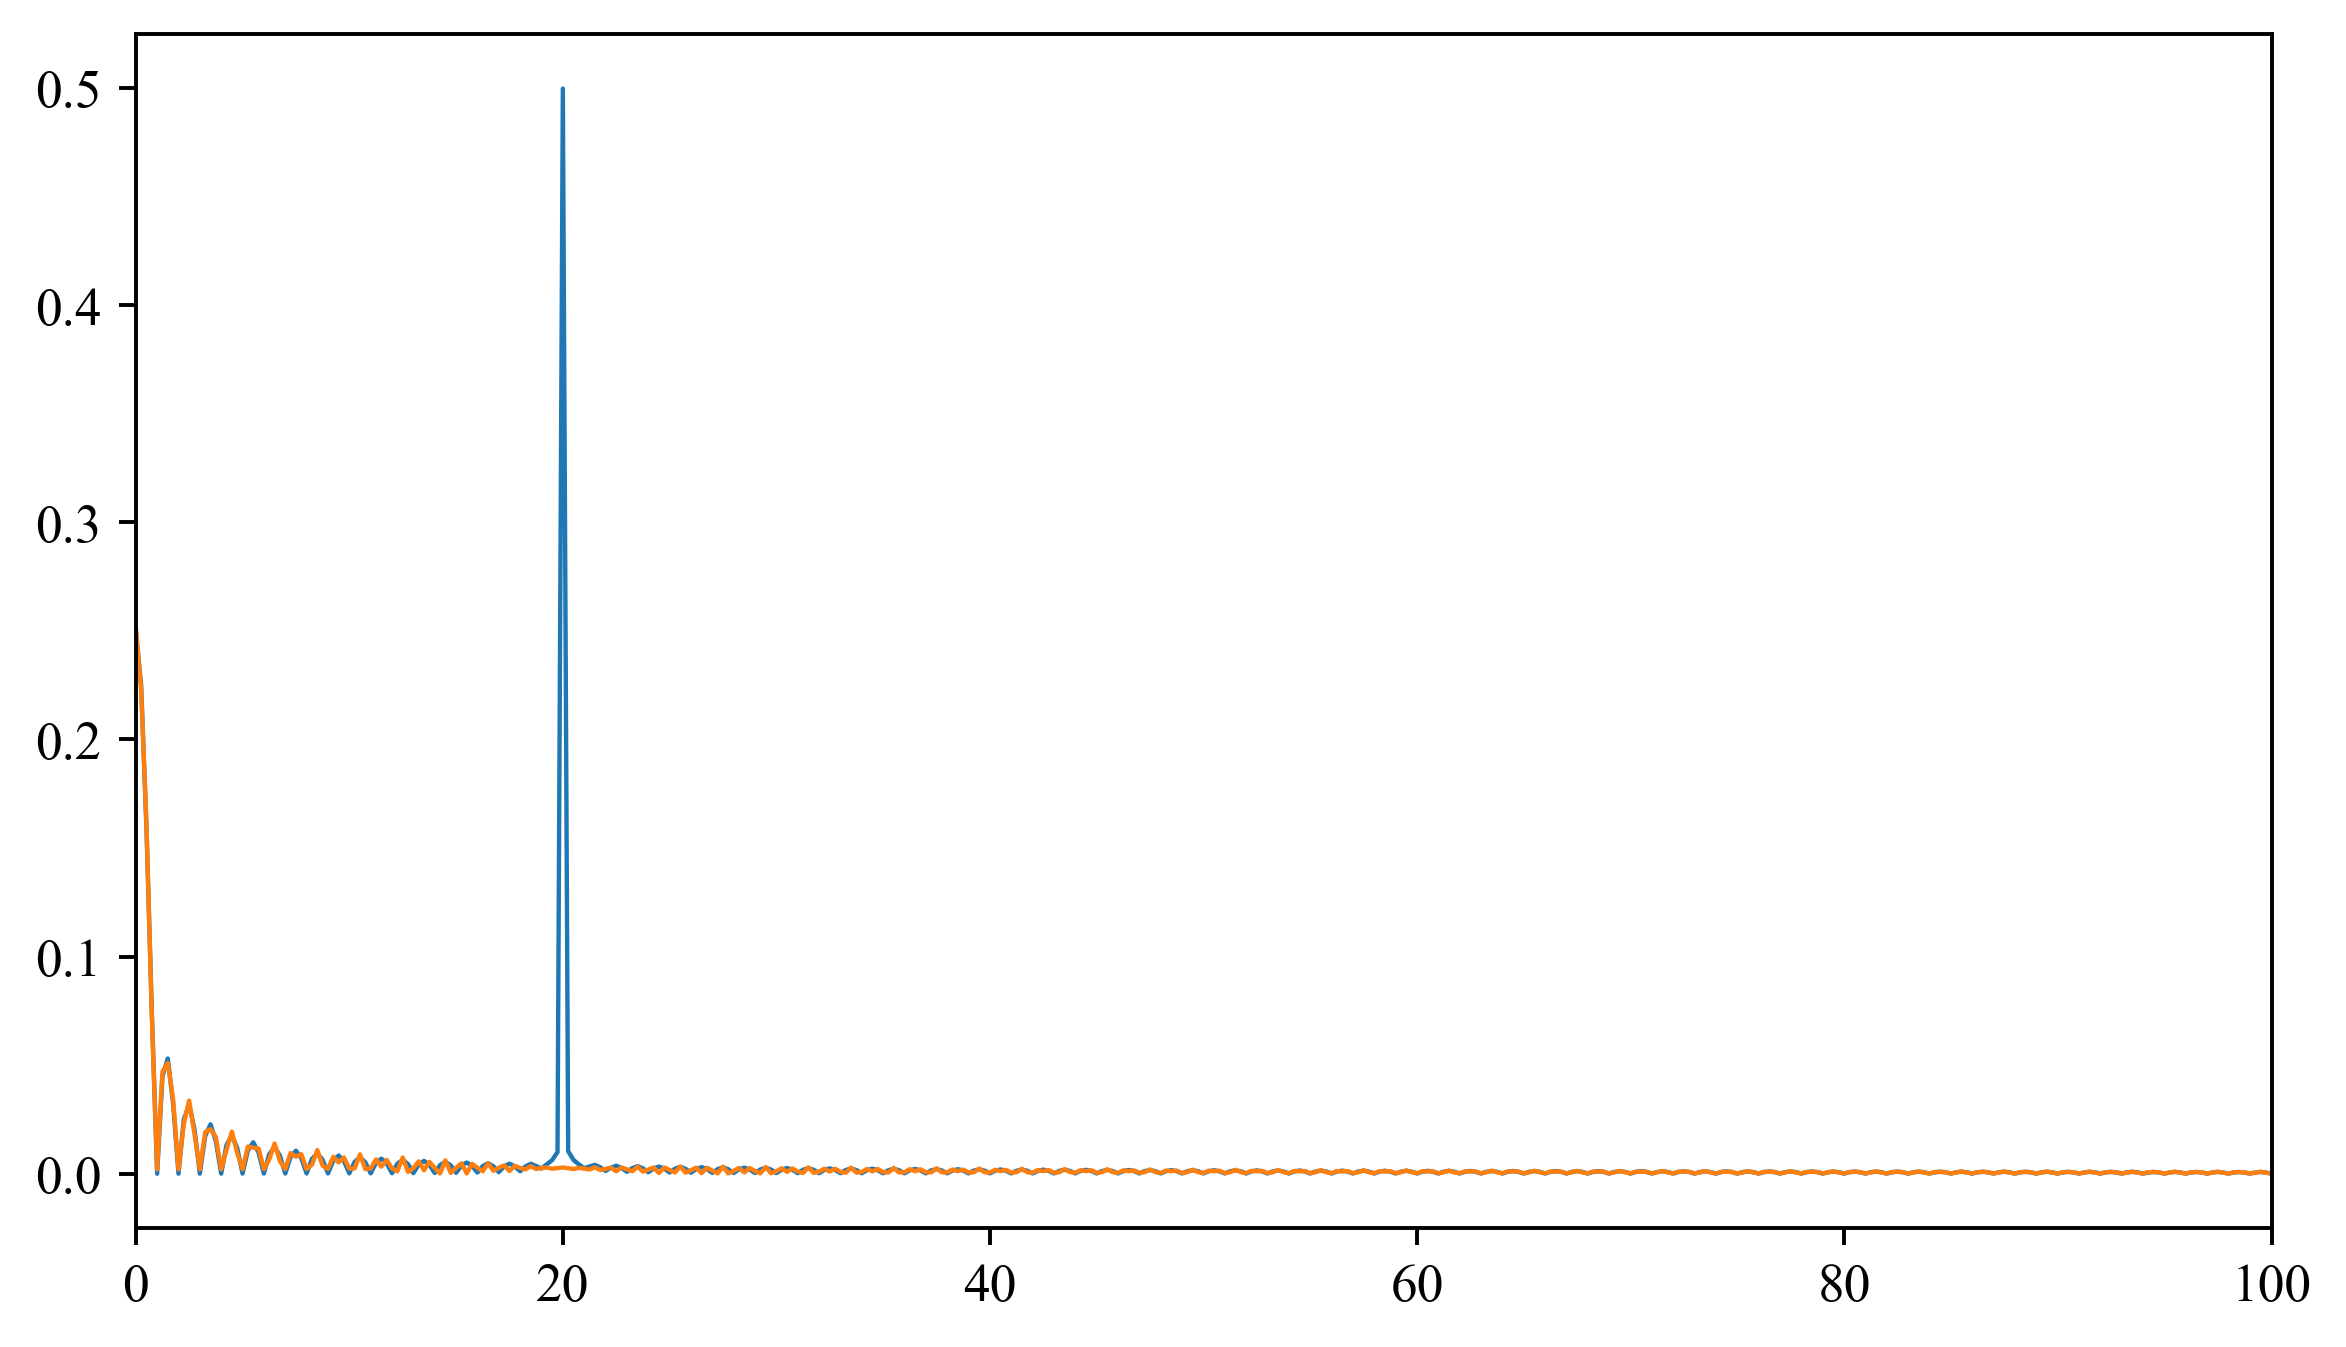

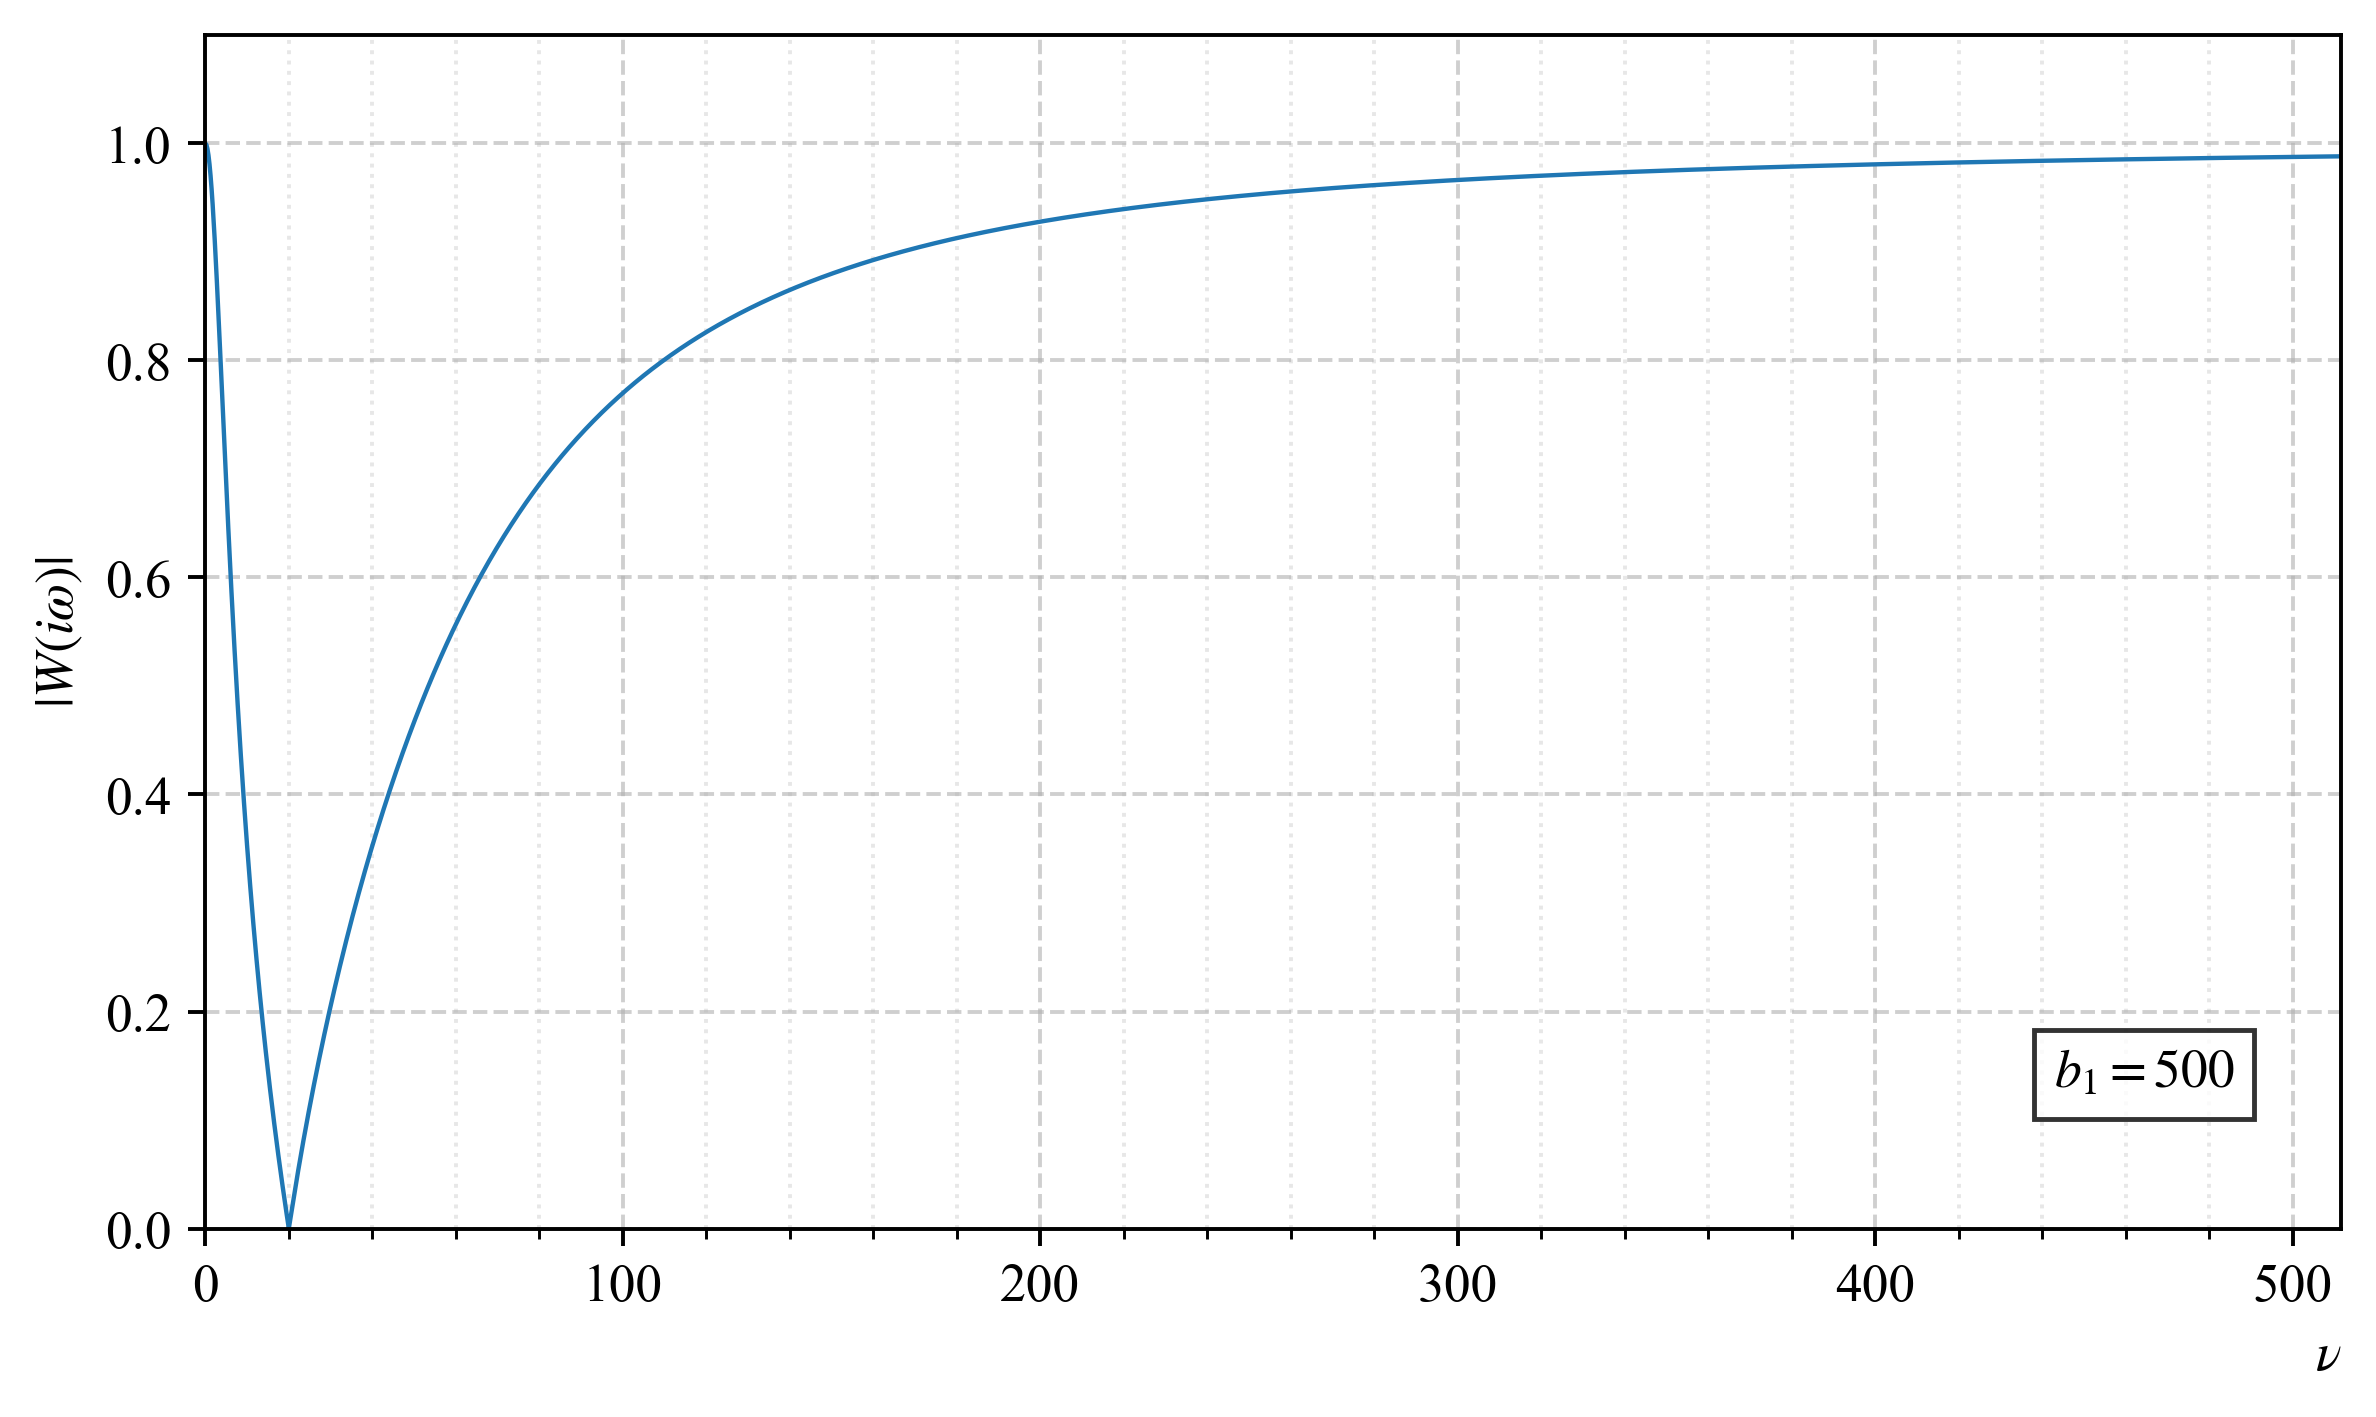

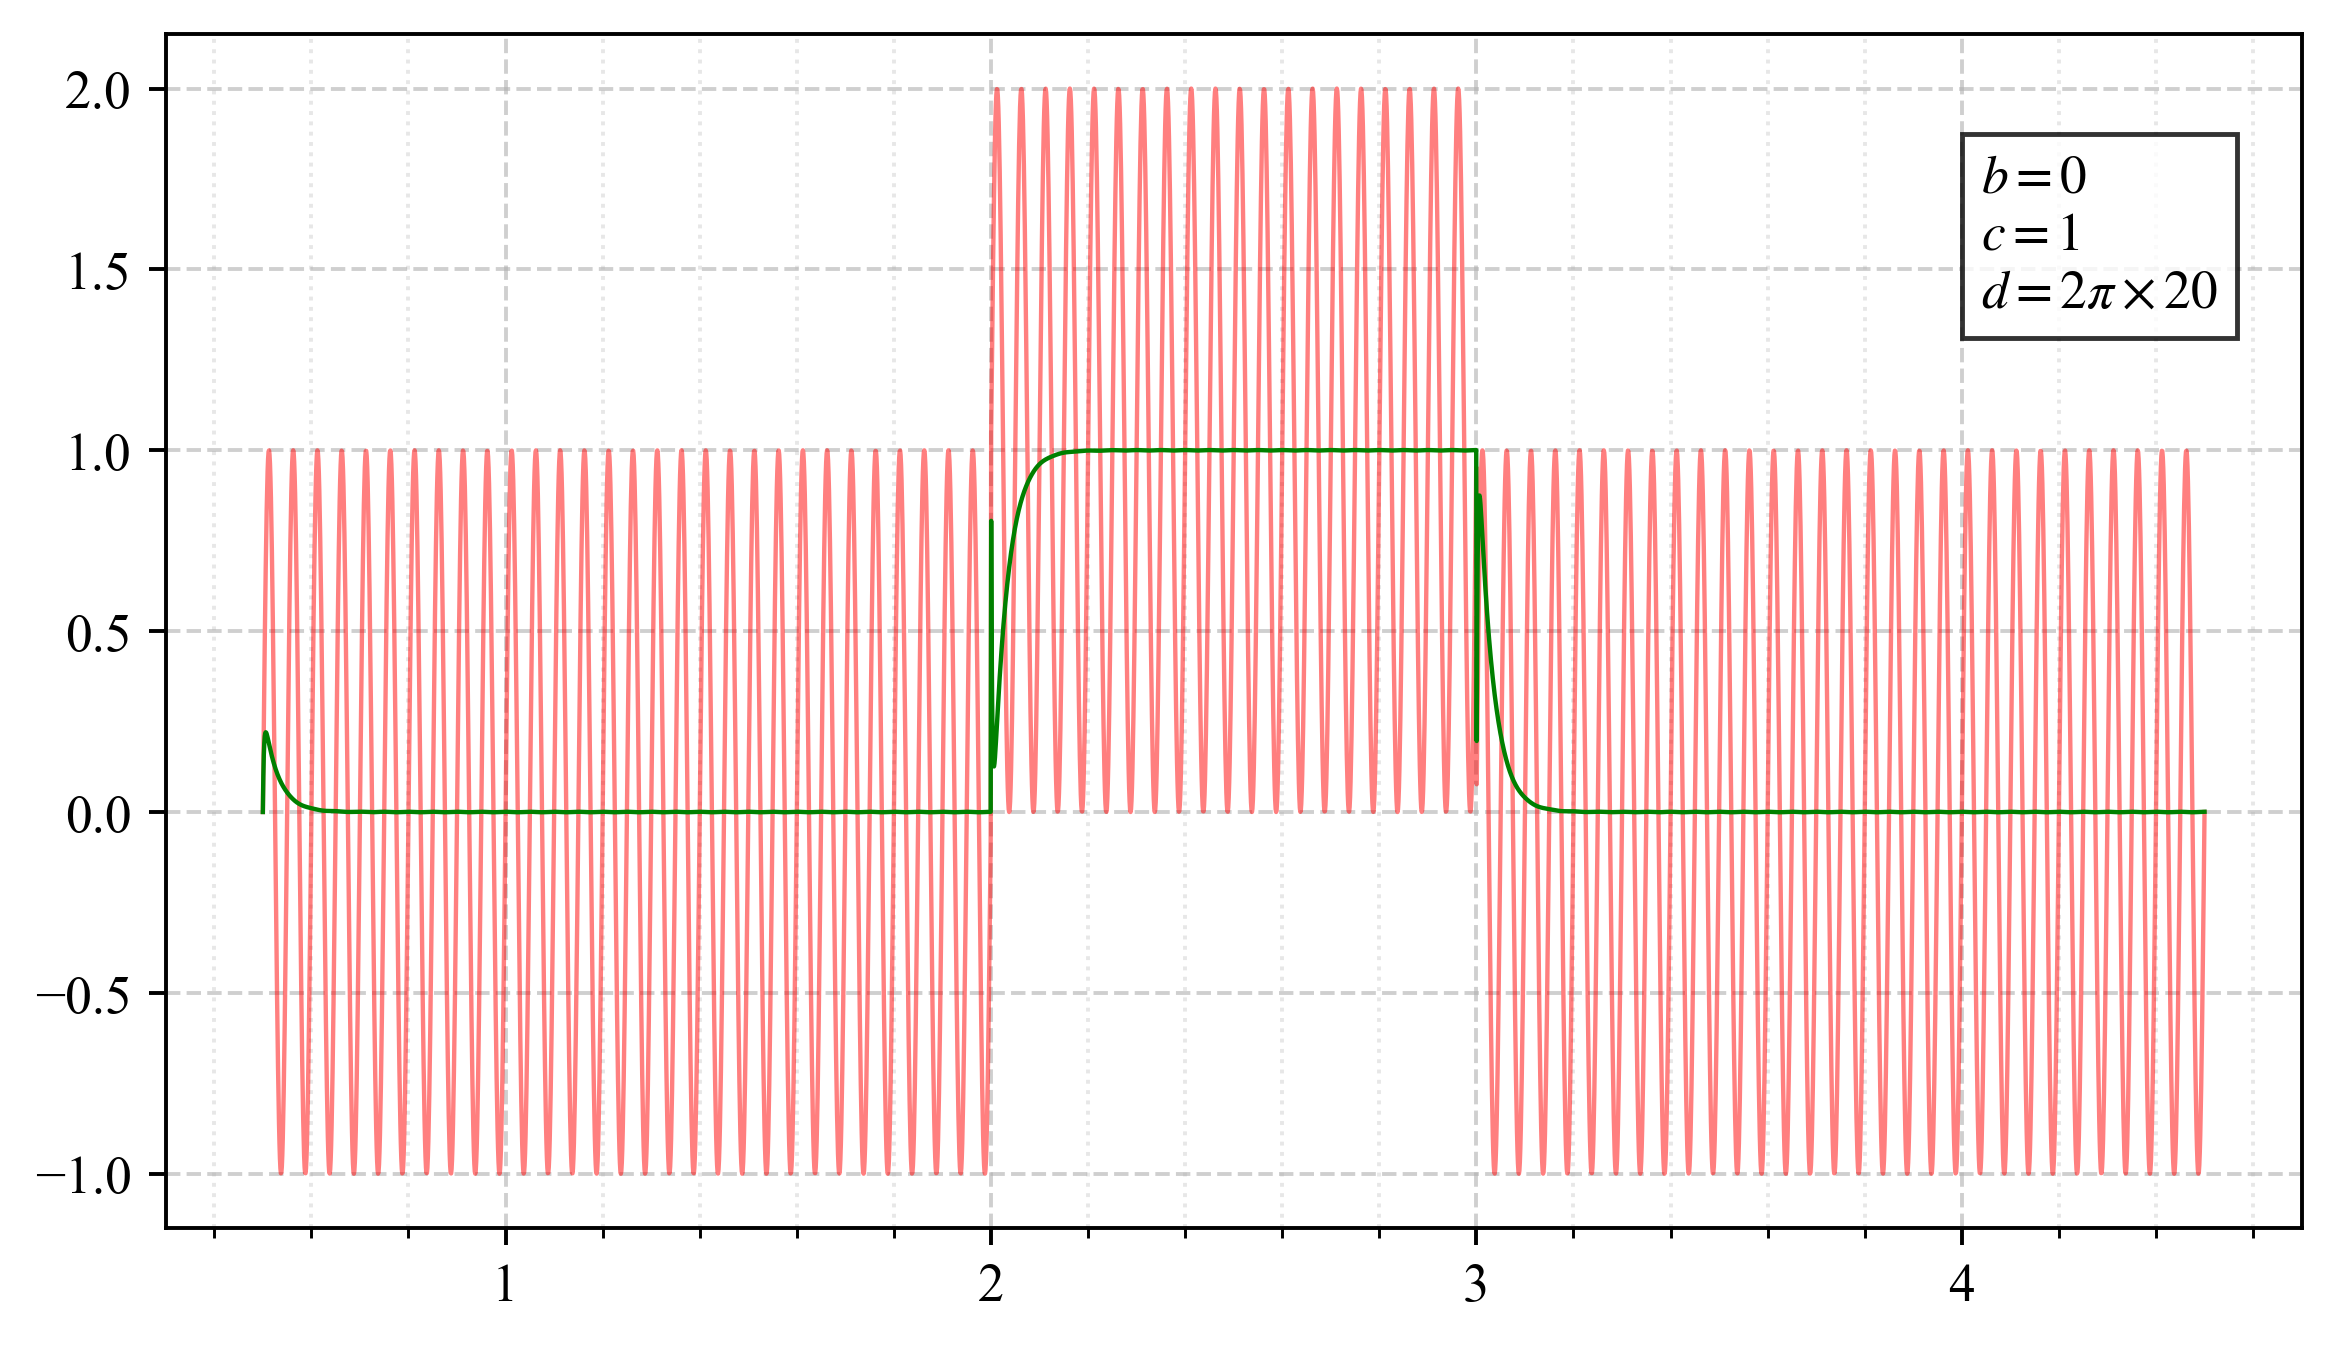

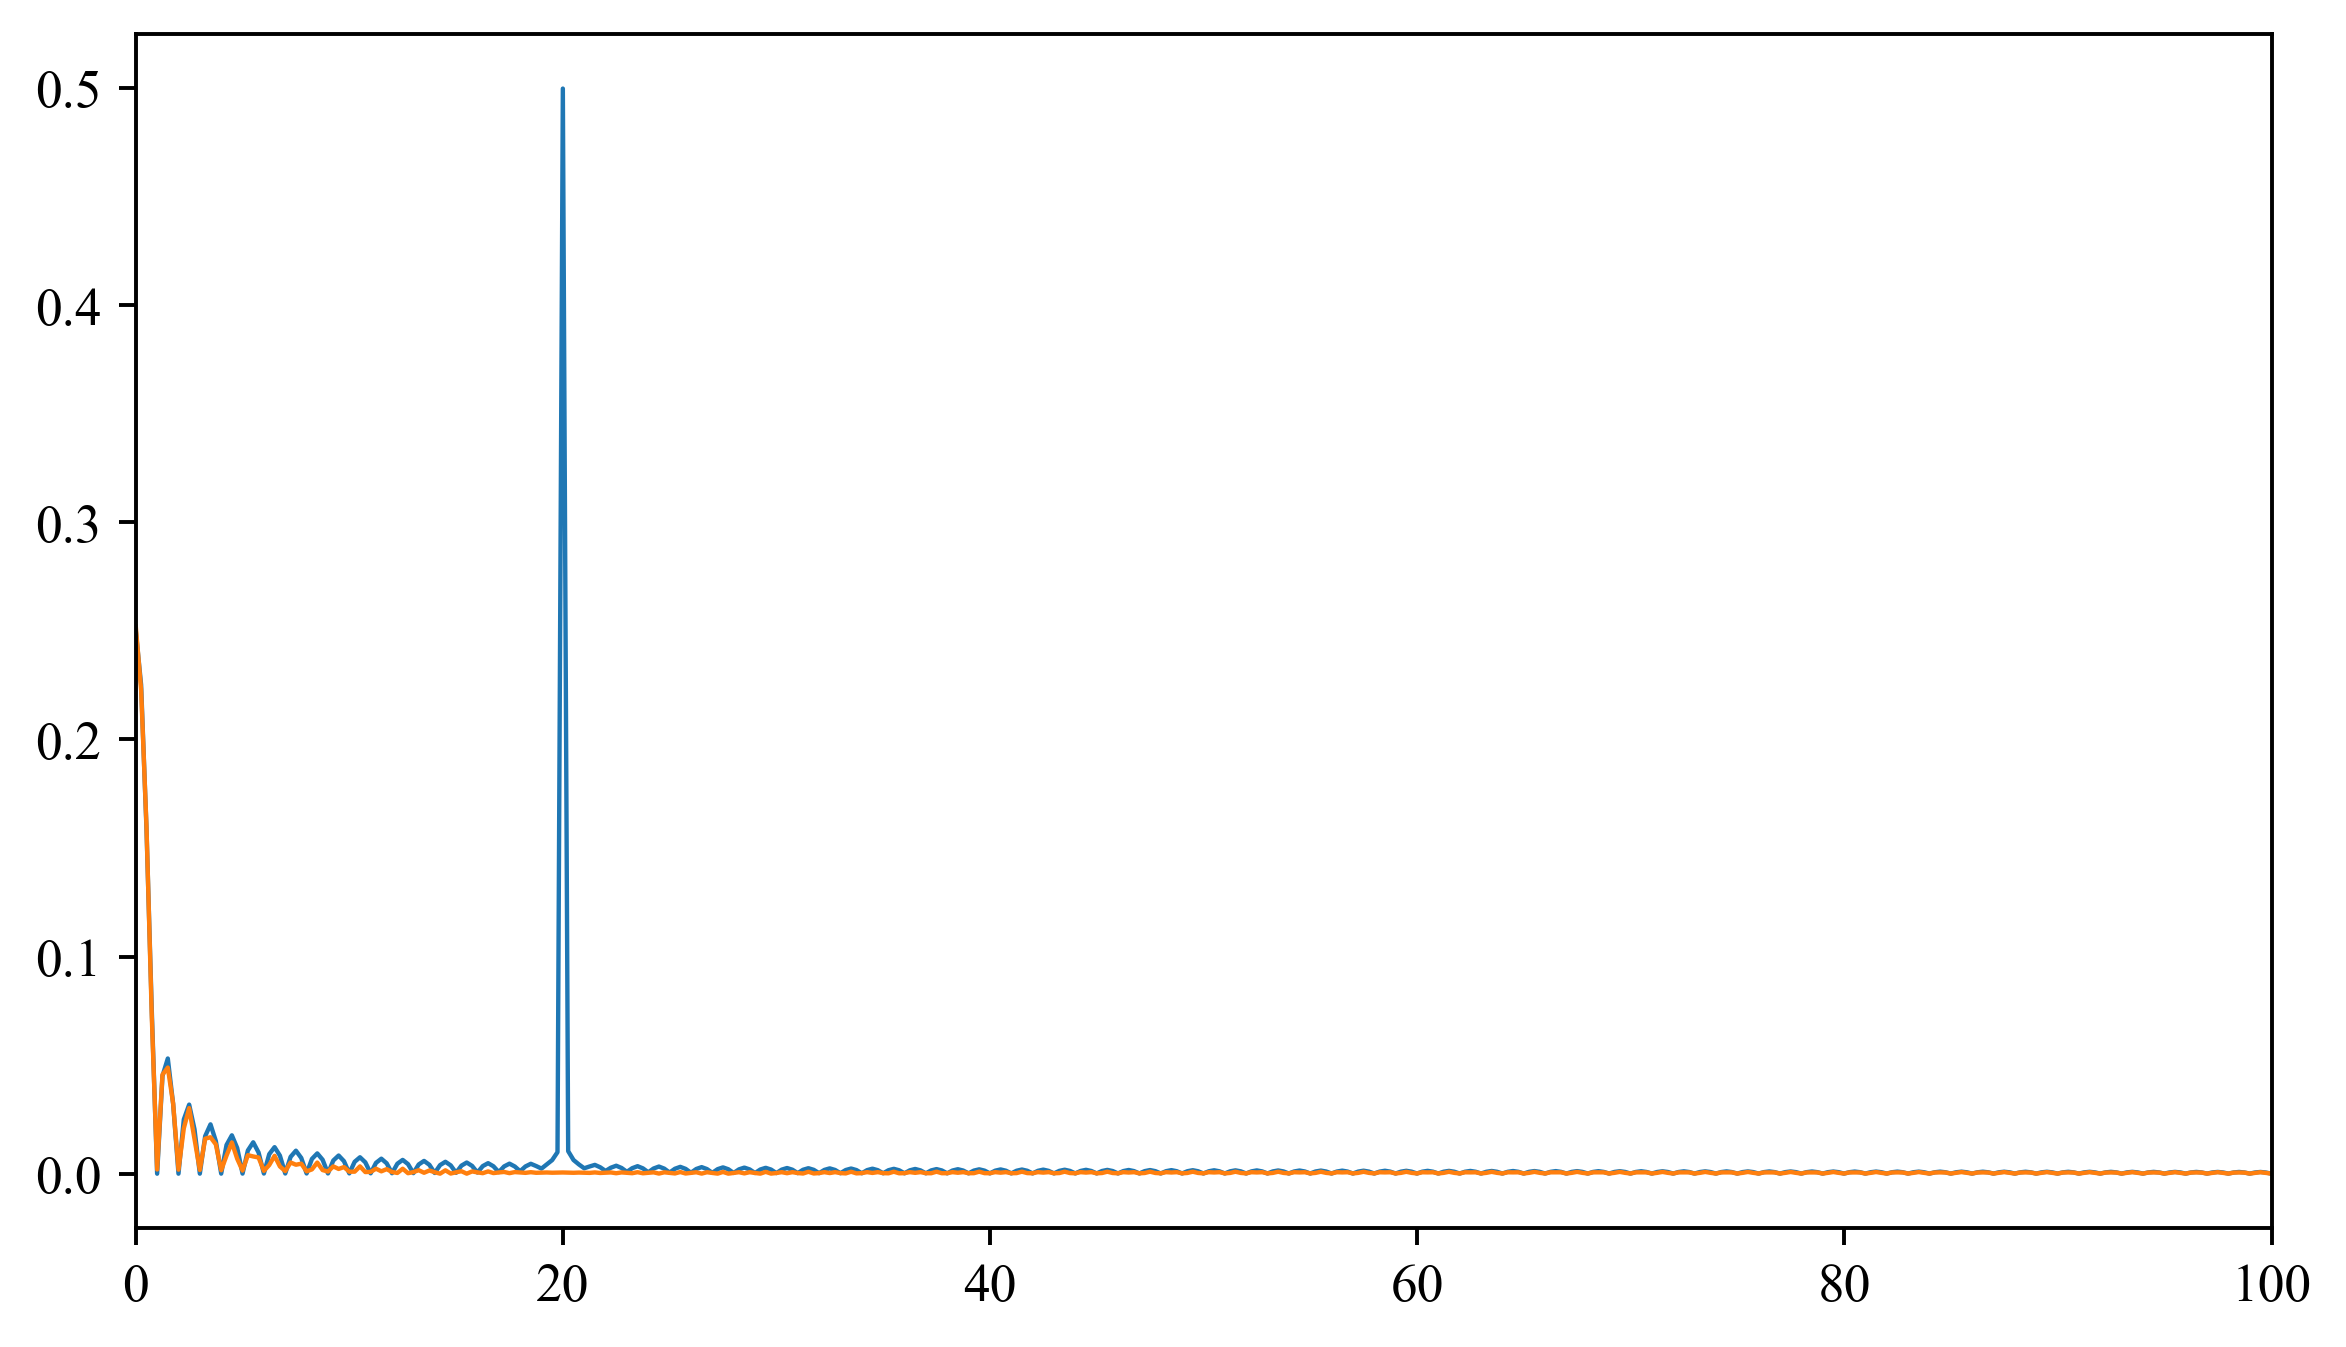

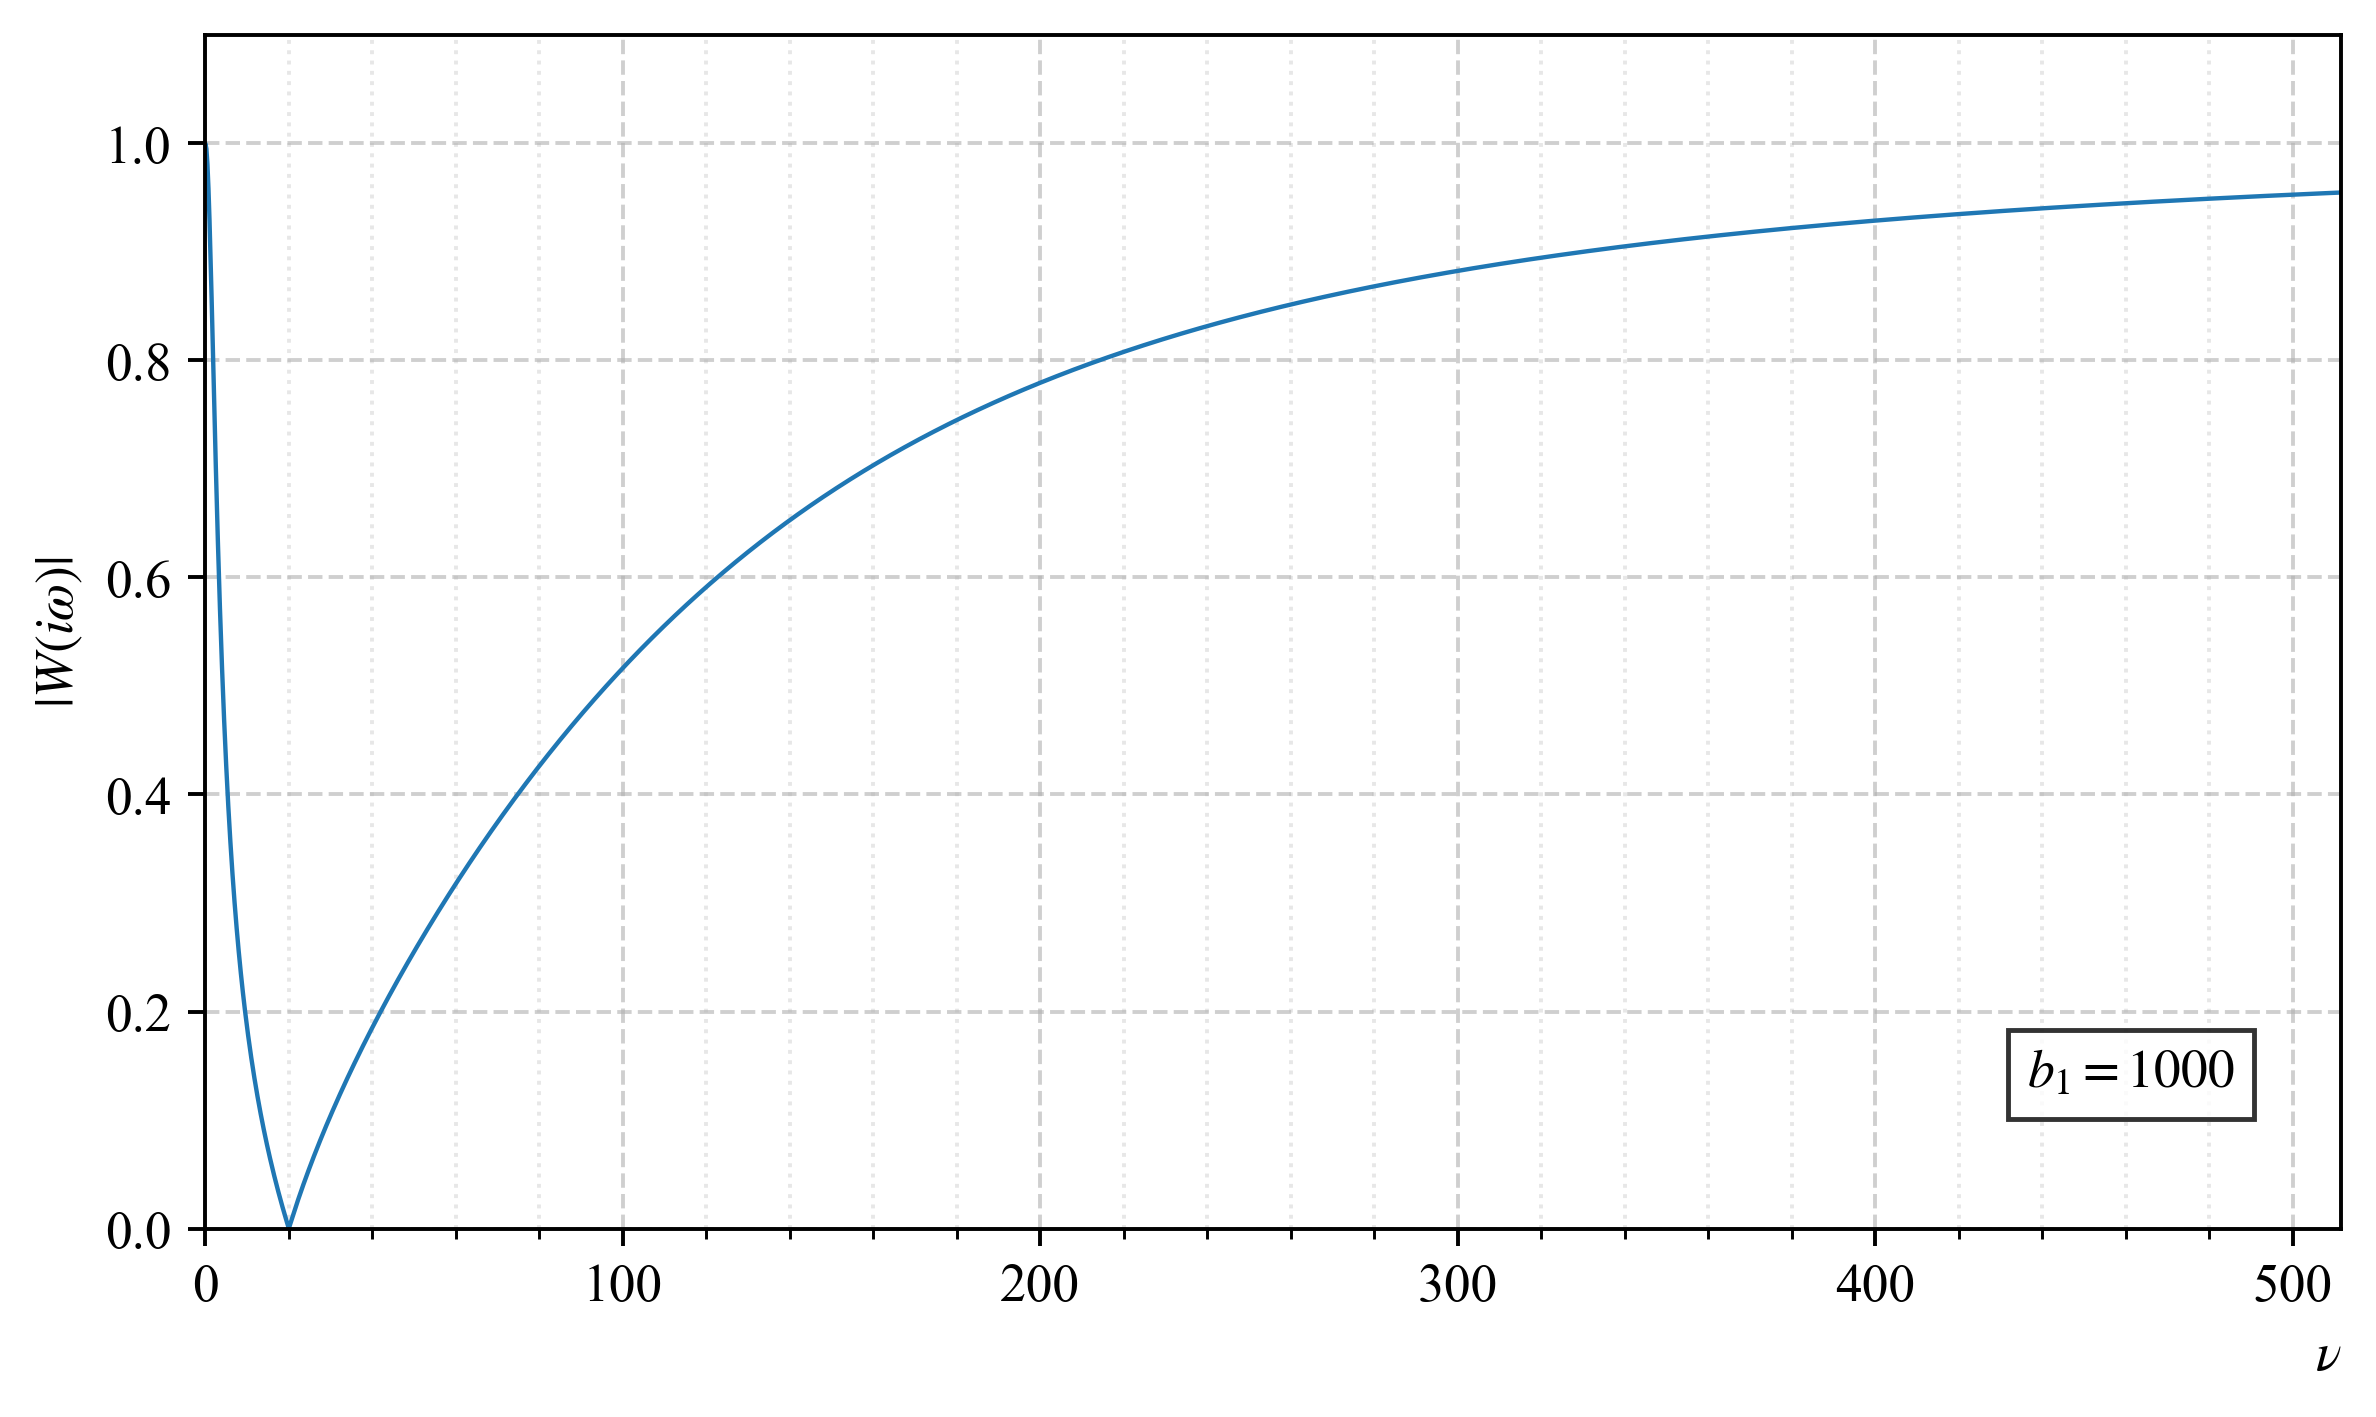

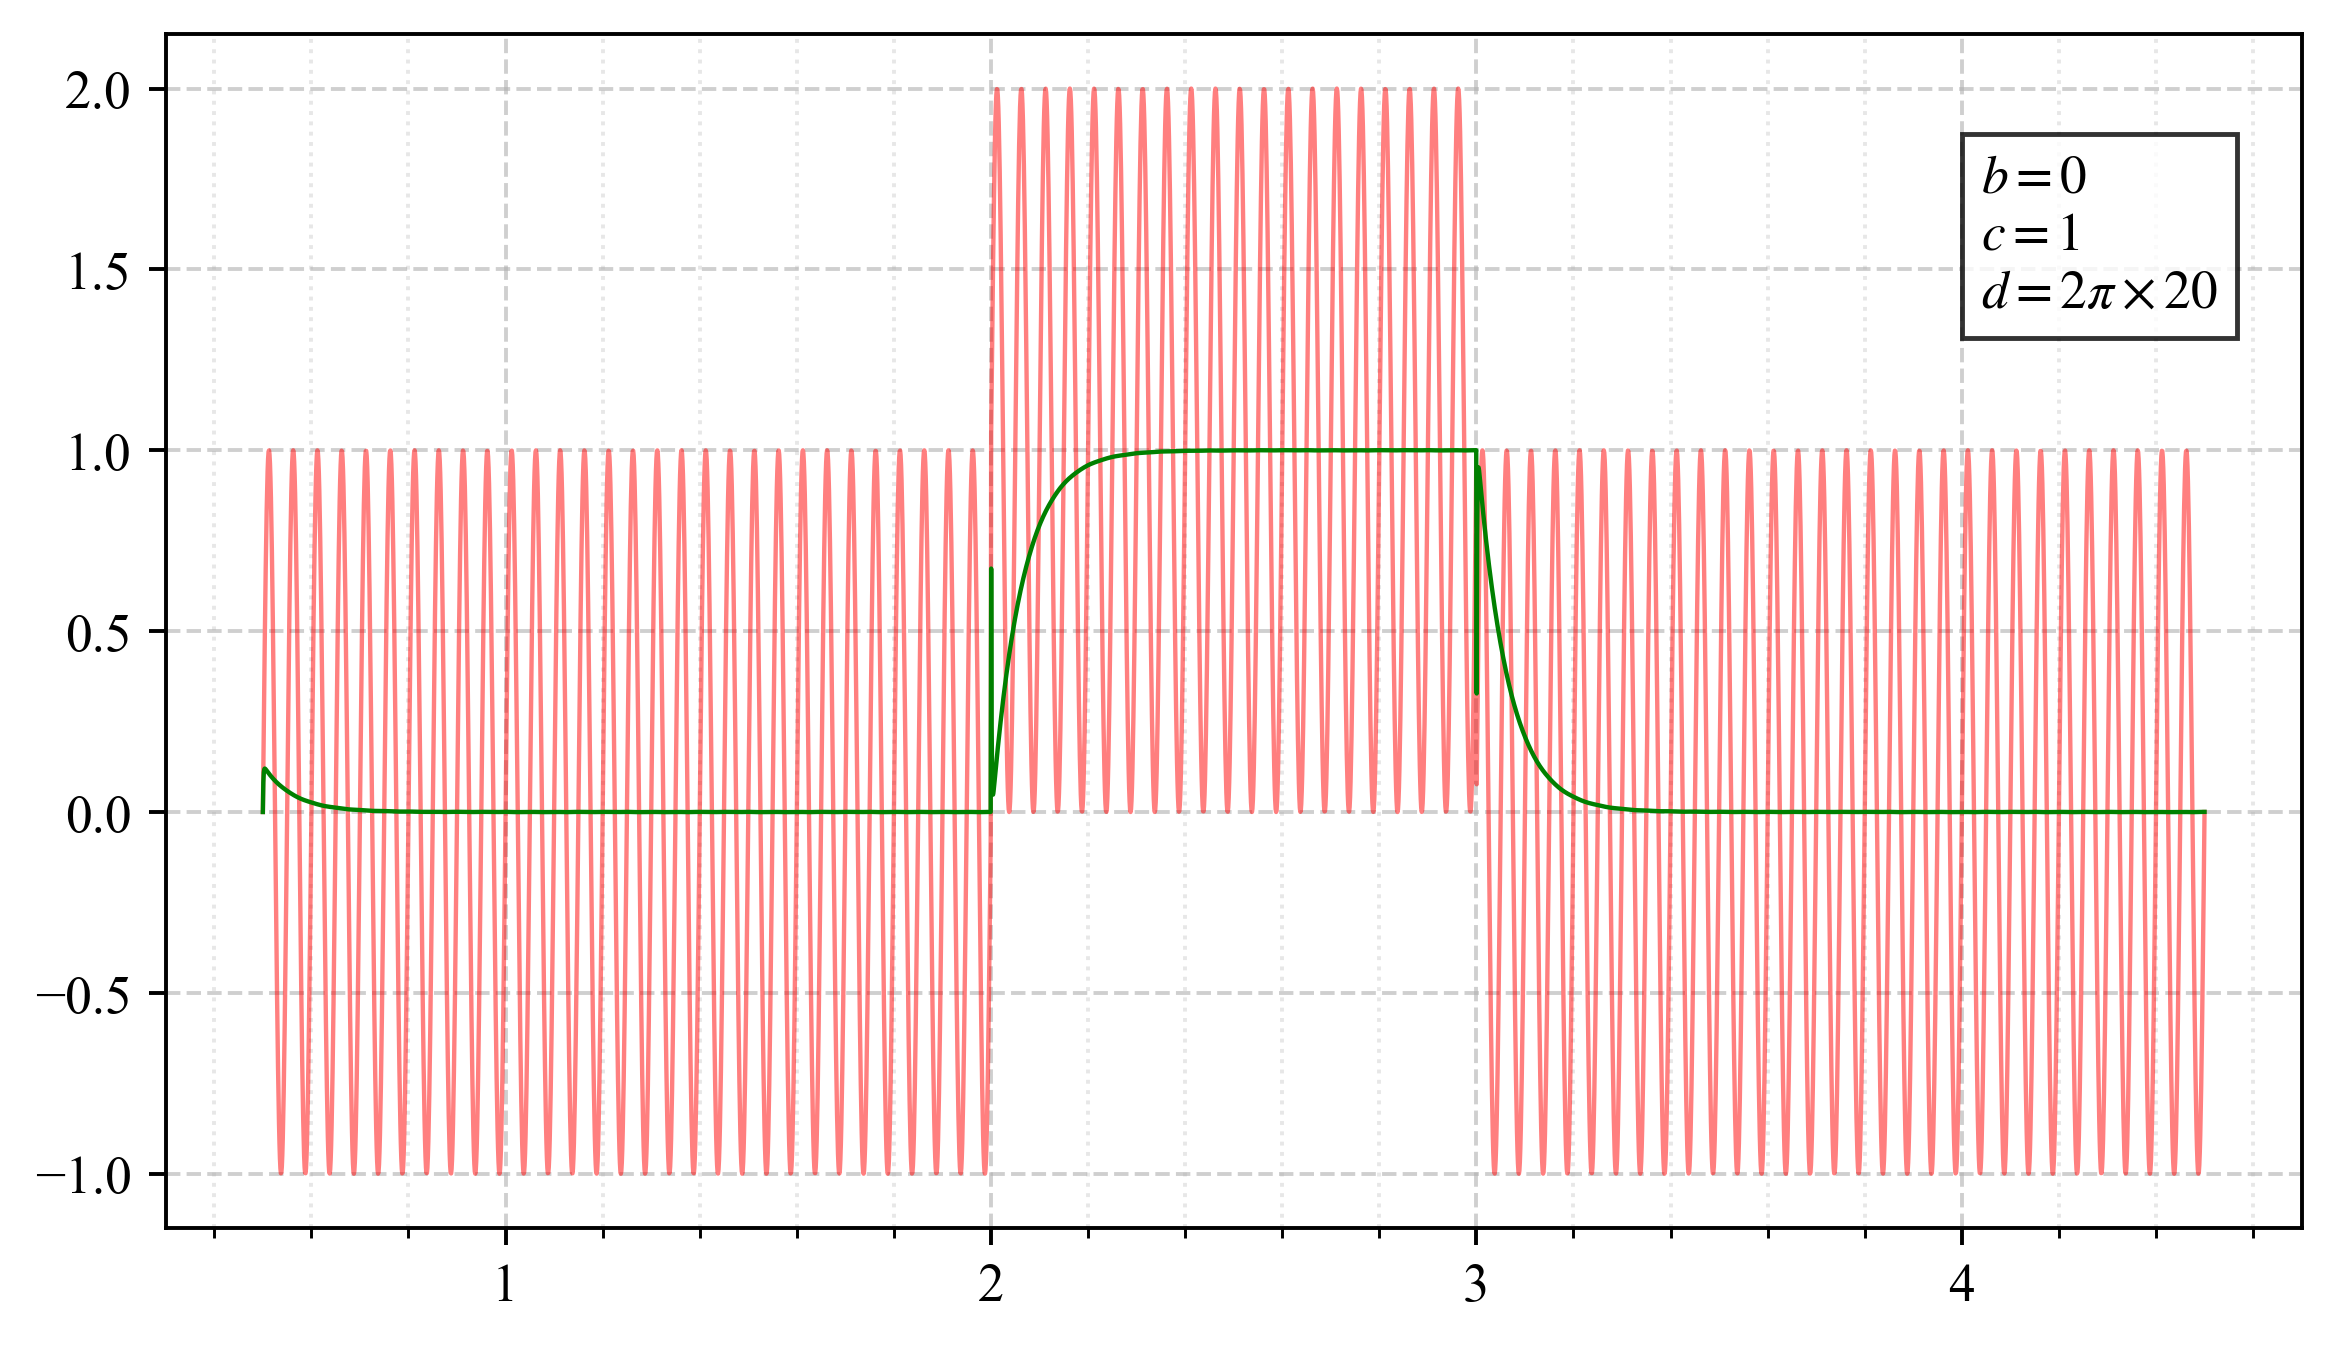

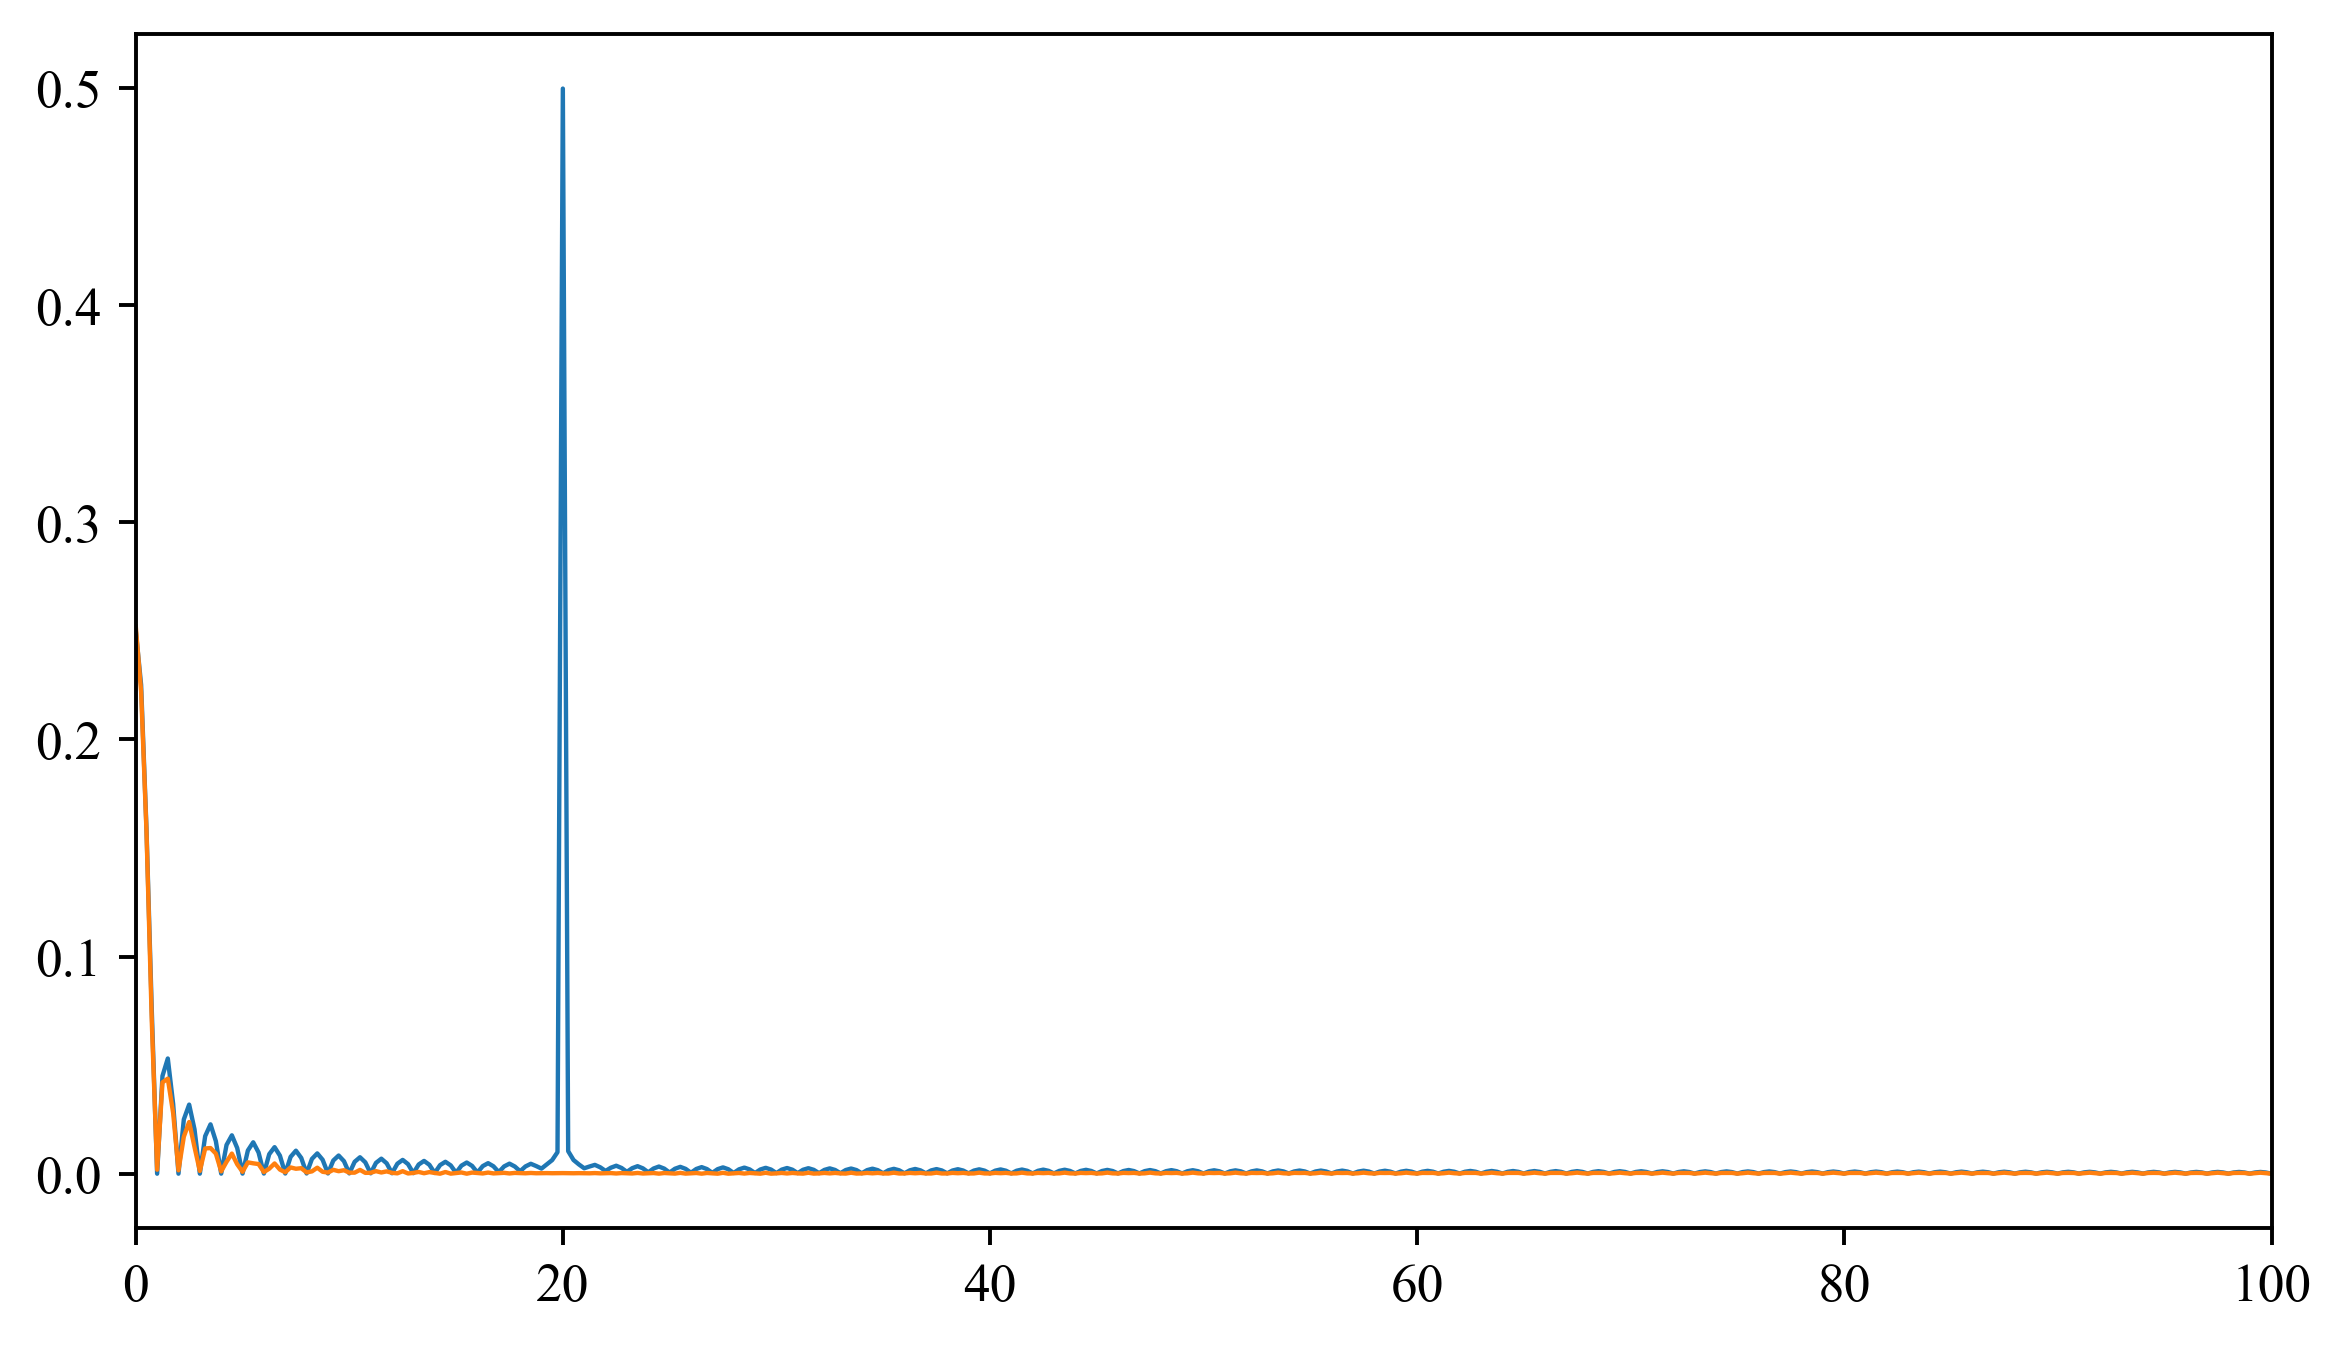

In [ ]:
%mkdir -p ../fig/1/2/b1

for i, _b1 in enumerate((10**2, 5*10**2, 10**3)):
    # -----------------------------------------------
    # АЧХ Фильтра
    # -----------------------------------------------
    plt.figure(num=3*i)
    ax = plt.gca()

    ax.xaxis.set_major_locator(plt.MultipleLocator(100))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(20))
    ax.grid(which='major', linestyle='--', alpha=0.6)
    ax.grid(which='minor', linestyle=':', alpha=0.3)

    ax.set_ylim(top=1.1)

    # См.:
    # https://en.wikipedia.org/wiki/Band-stop_filter

    omega0 = 2*np.pi * 20

    a1 = 0
    a2 = omega0**2
    b1 = _b1
    b2 = omega0**2

    _W = W2_tf(a1, a2, b1, b2)

    ax.text(0.95, 0.15, f"$b_1 = {b1}$", transform=ax.transAxes, 
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.8))

    plot_freq_response(_W, ax, t)

    plt.savefig(f"../fig/1/2/b1/{3*i}.png")

    # -----------------------------------------------
    # Cравнение зашумленного и фильтрованного сигнала
    # -----------------------------------------------
    plt.figure(num=3*i+1)
    ax = plt.gca()

    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.2))
    ax.grid(which='major', linestyle='--', alpha=0.6)
    ax.grid(which='minor', linestyle=':', alpha=0.3)

    out_signal = apply_W_dynamic(t, noisy_signal1, _W)

    ax.plot(t, noisy_signal1, 'r-', alpha=.5)
    ax.plot(t, out_signal, 'g-', alpha=1)

    ax.text(0.85, 0.90, f"$b=0$\n$c=1$\n$d=2\\pi\\times20$", transform=ax.transAxes, 
             verticalalignment='top', horizontalalignment='left',
             bbox=dict(facecolor='white', alpha=0.8))

    plt.savefig(f"../fig/1/2/b1/{3*i+1}.png")

    # -----------------------------------------------
    # Cравнение зашумленного и фильтрованного образа
    # -----------------------------------------------
    plt.figure(num=3*i+2)
    ax = plt.gca()

    ax.set_xlim(right=100)

    fr = np.fft.fftfreq(t.size, t[1] - t[0])[0:t.size//2]
    noisy_fft = np.abs(np.fft.fft(noisy_signal1)[0:t.size//2]) / t.size

    filtered_fr = np.fft.fftfreq(t.size, t[1] - t[0])[0:t.size//2]
    filtered_signal = np.abs((np.fft.fft(out_signal))[0:t.size//2]) / t.size

    plt.plot(fr, noisy_fft)
    plt.plot(filtered_fr, filtered_signal)

    plt.savefig(f"../fig/1/2/b1/{3*i+2}.png")

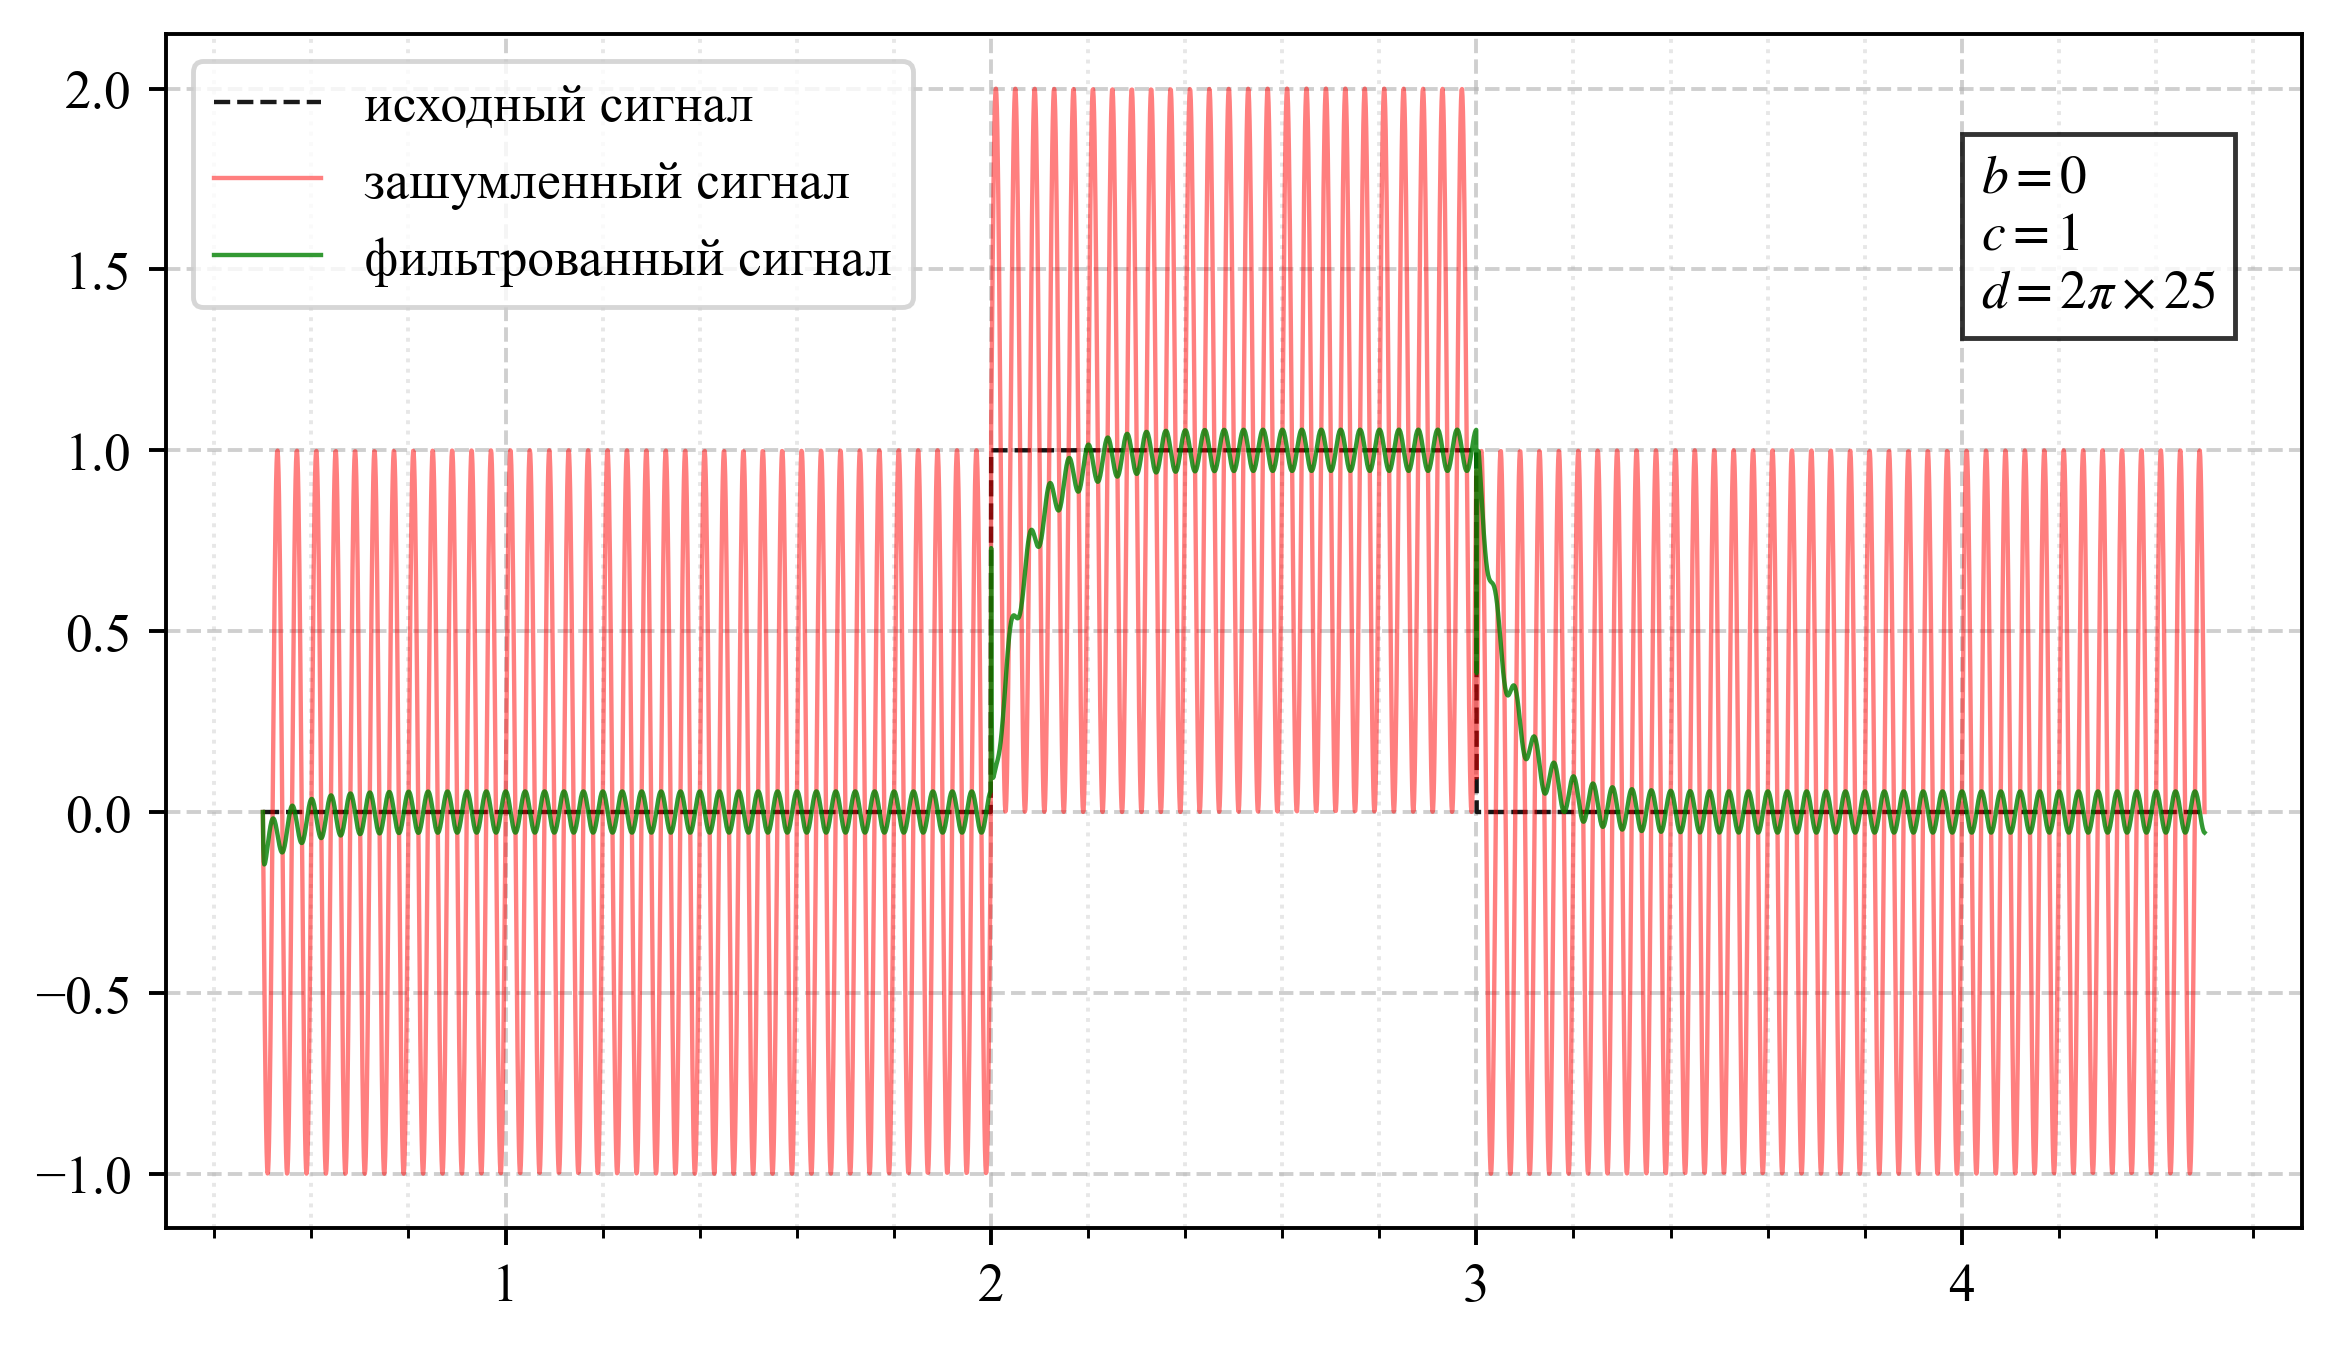

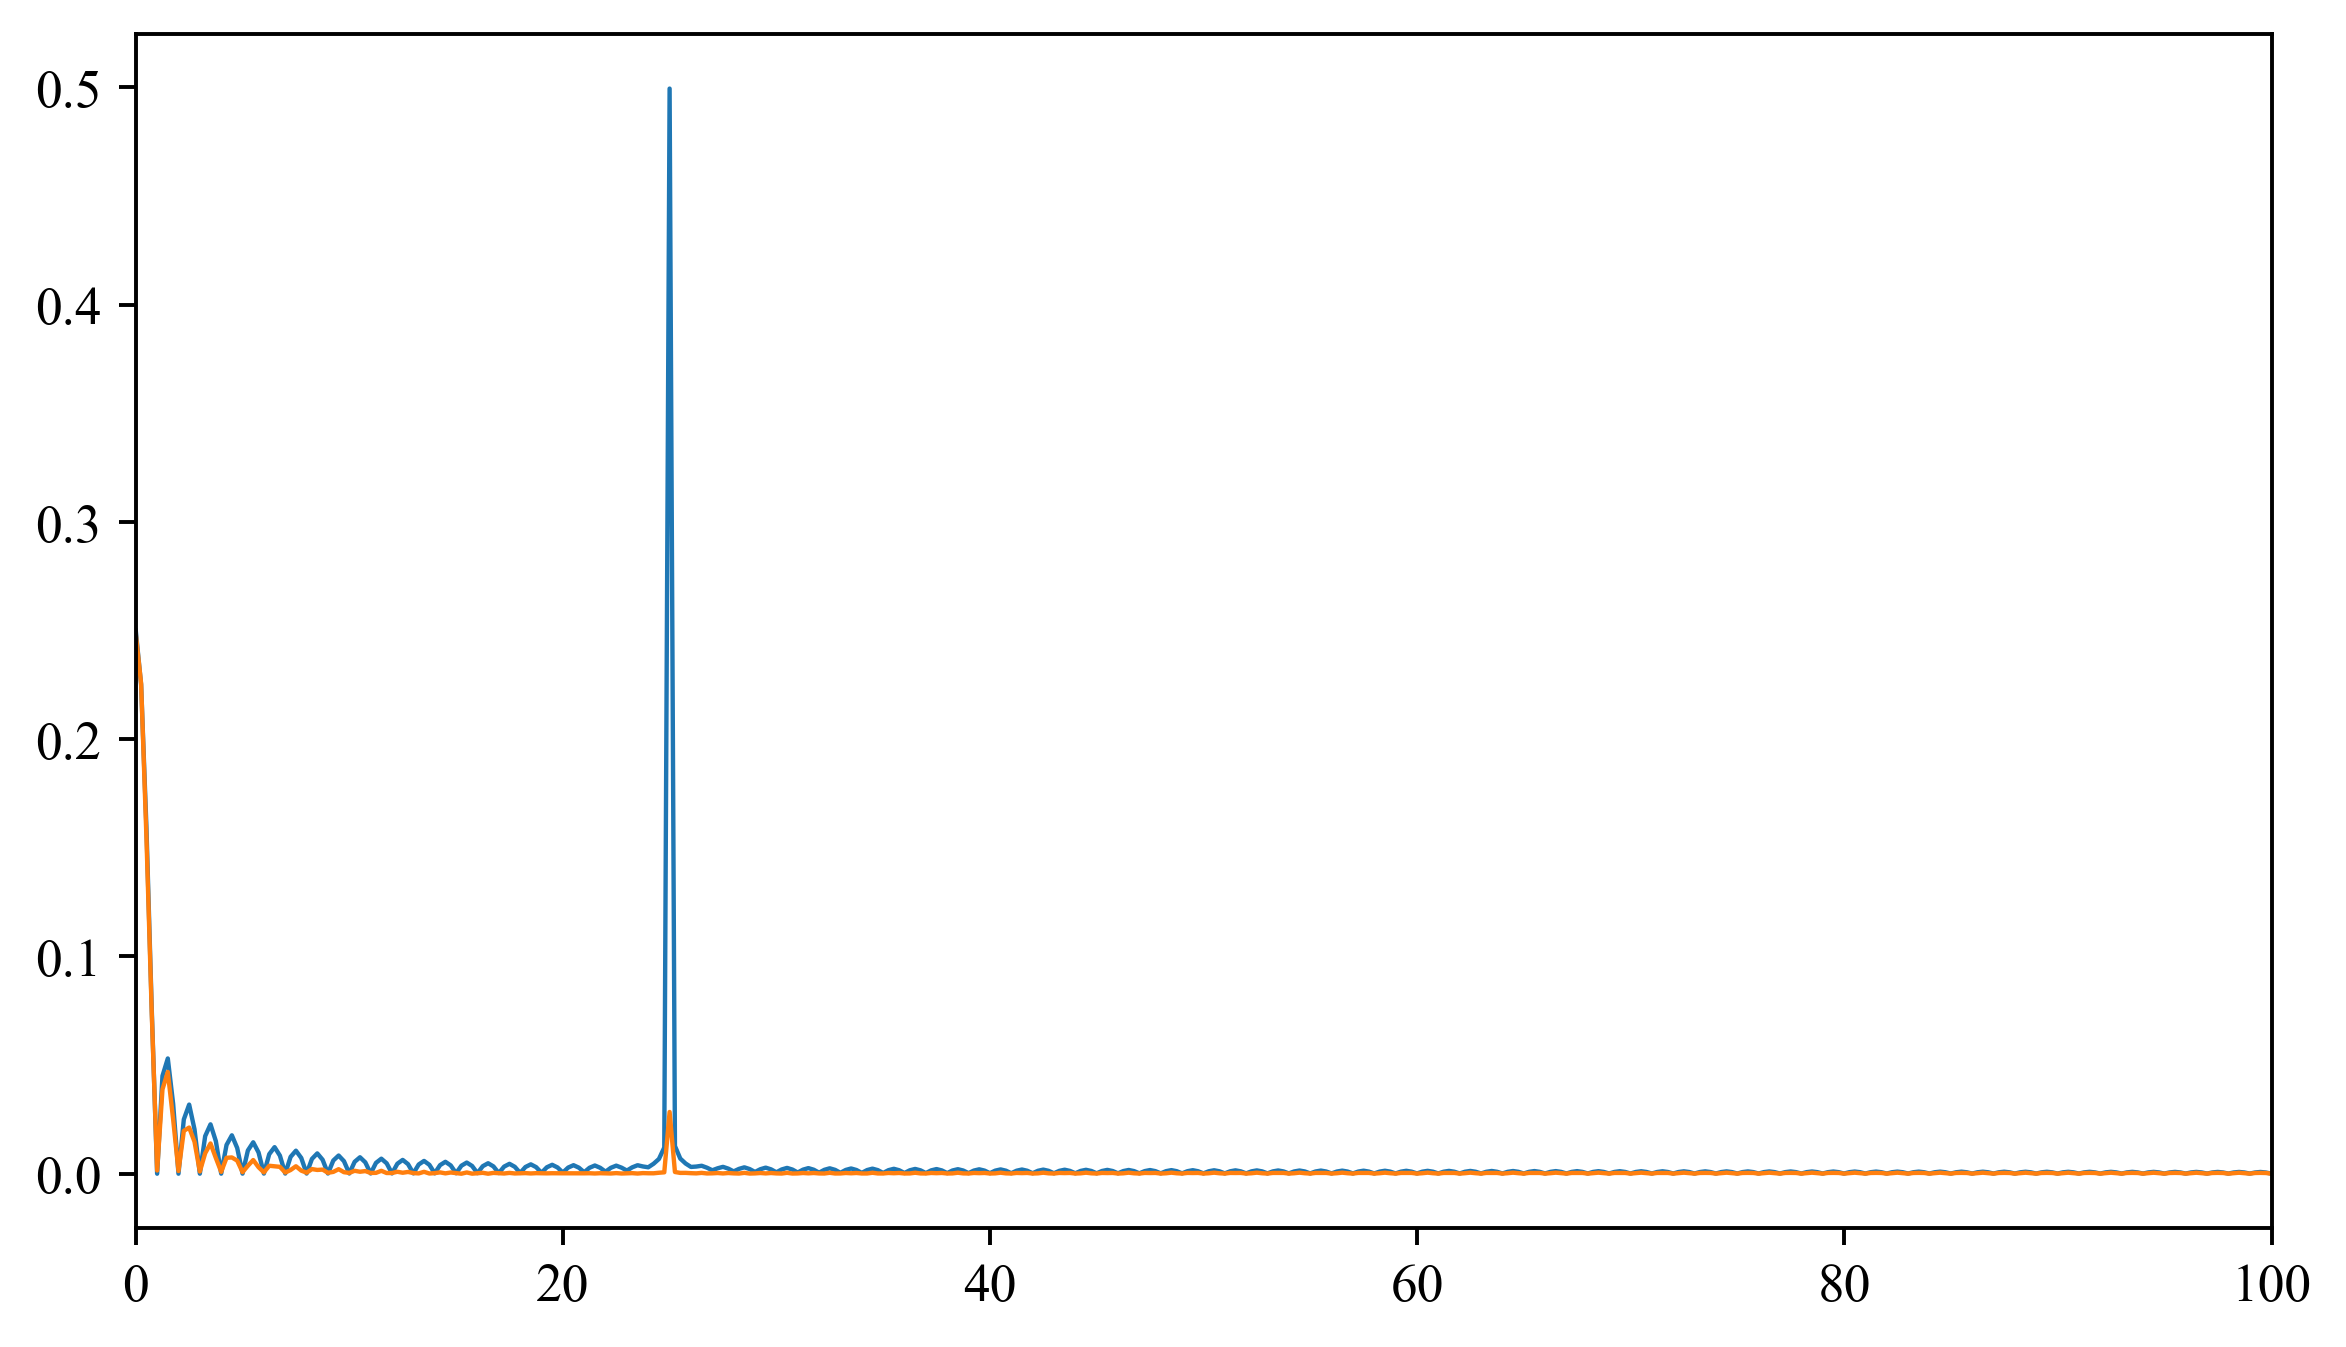

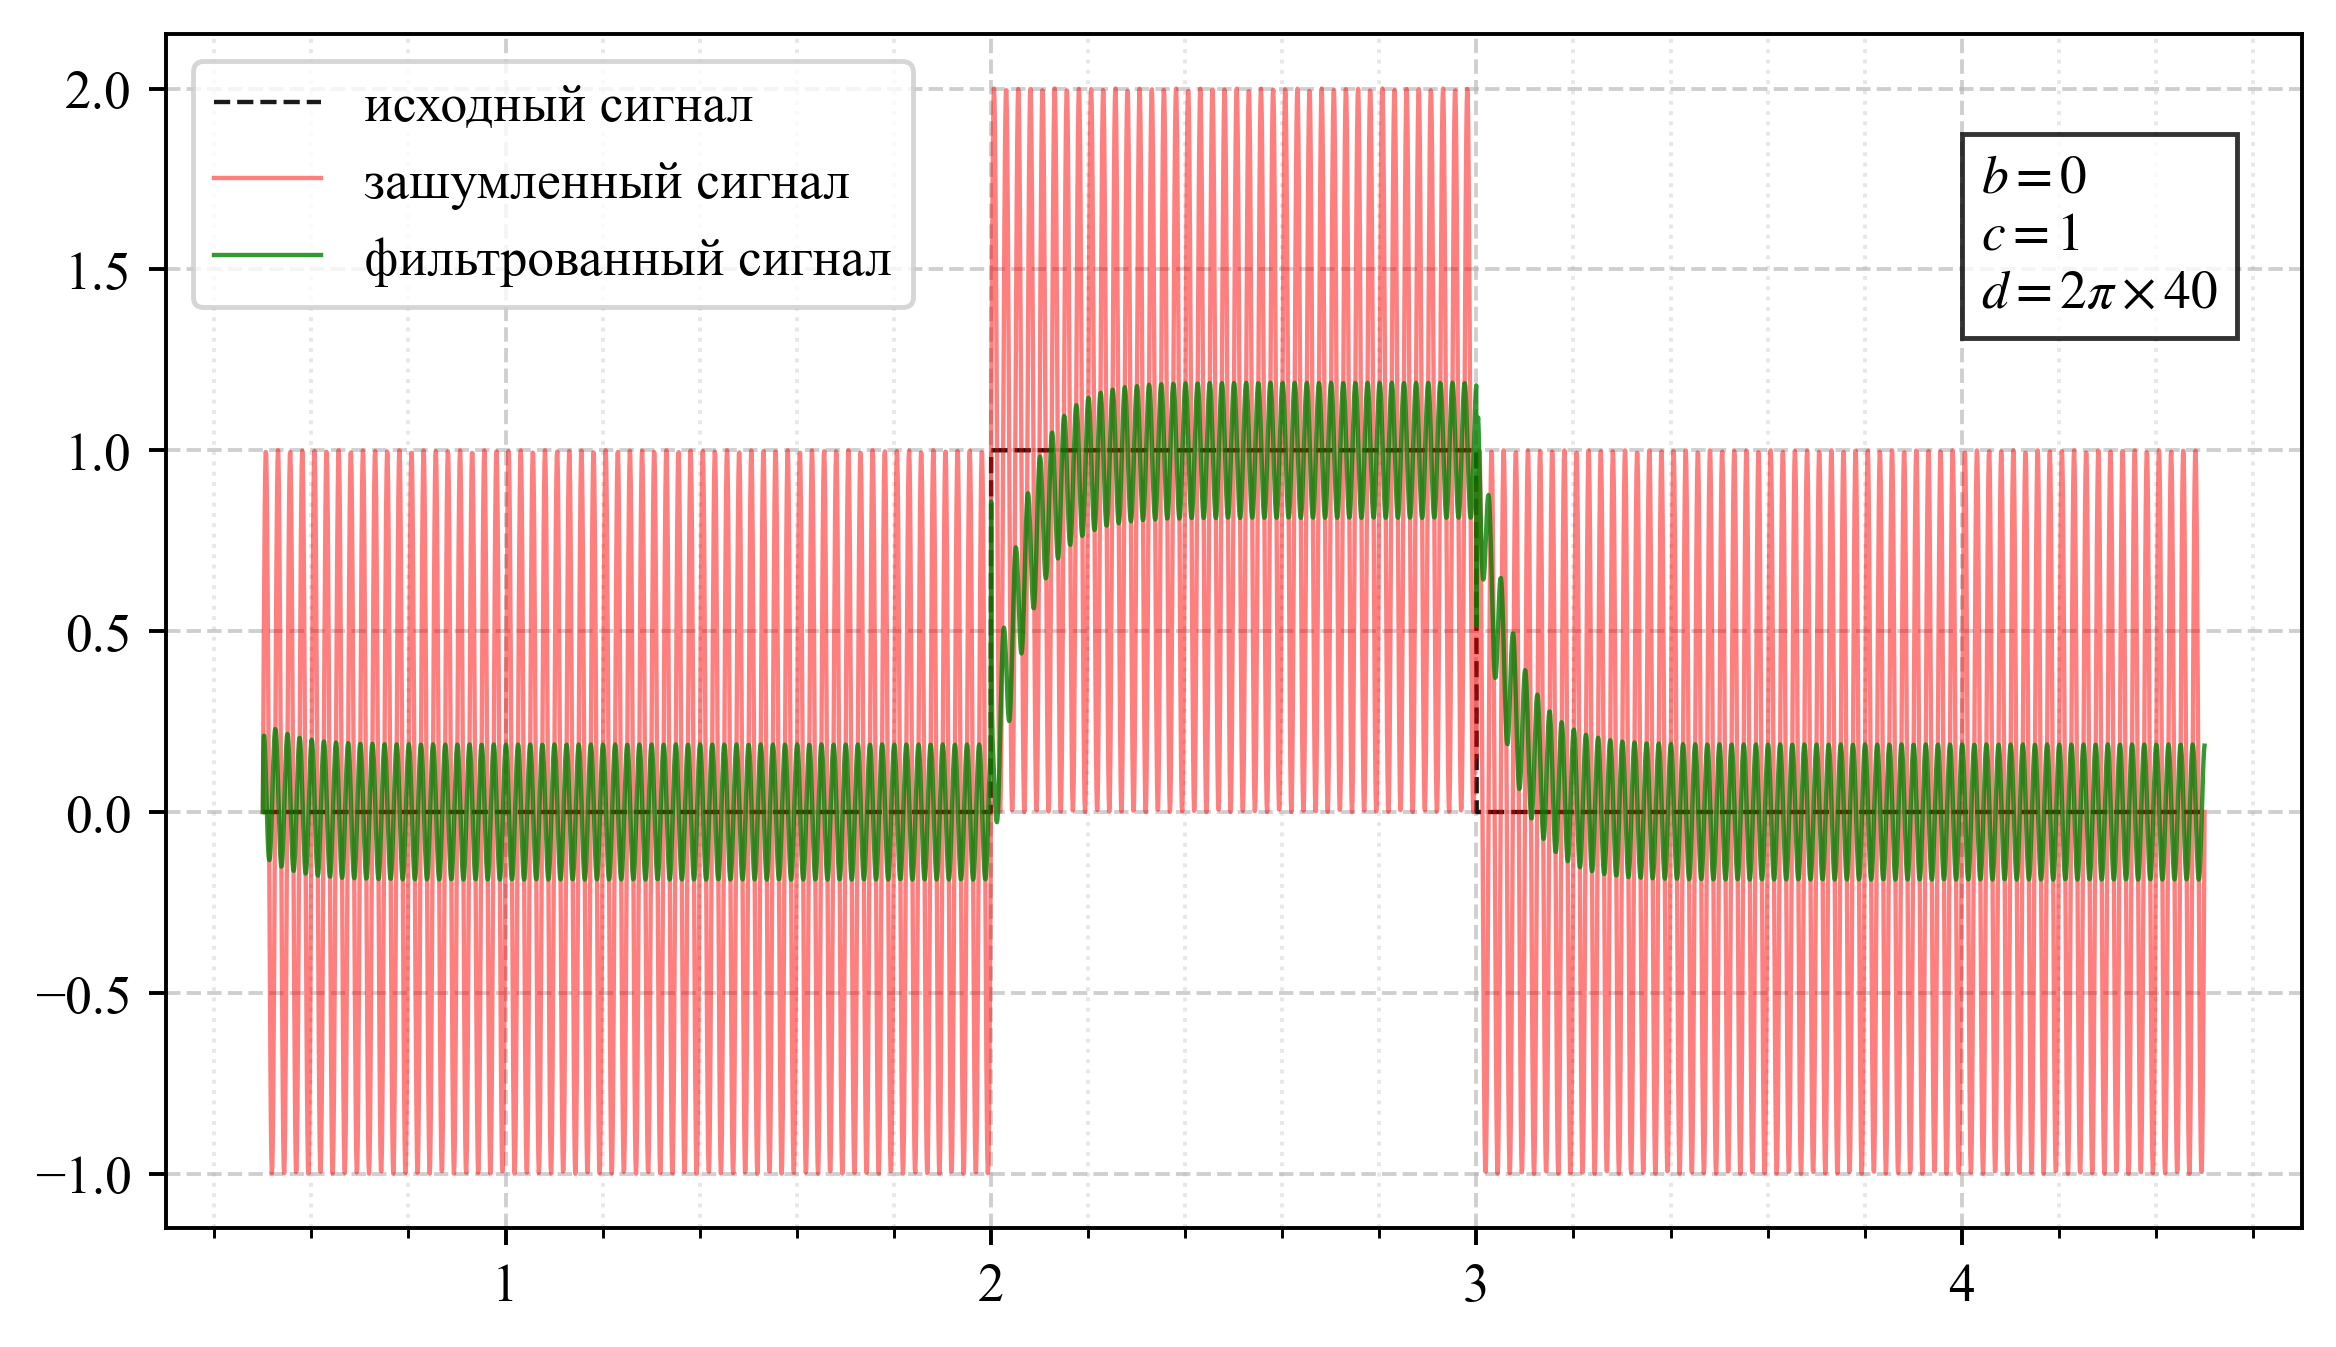

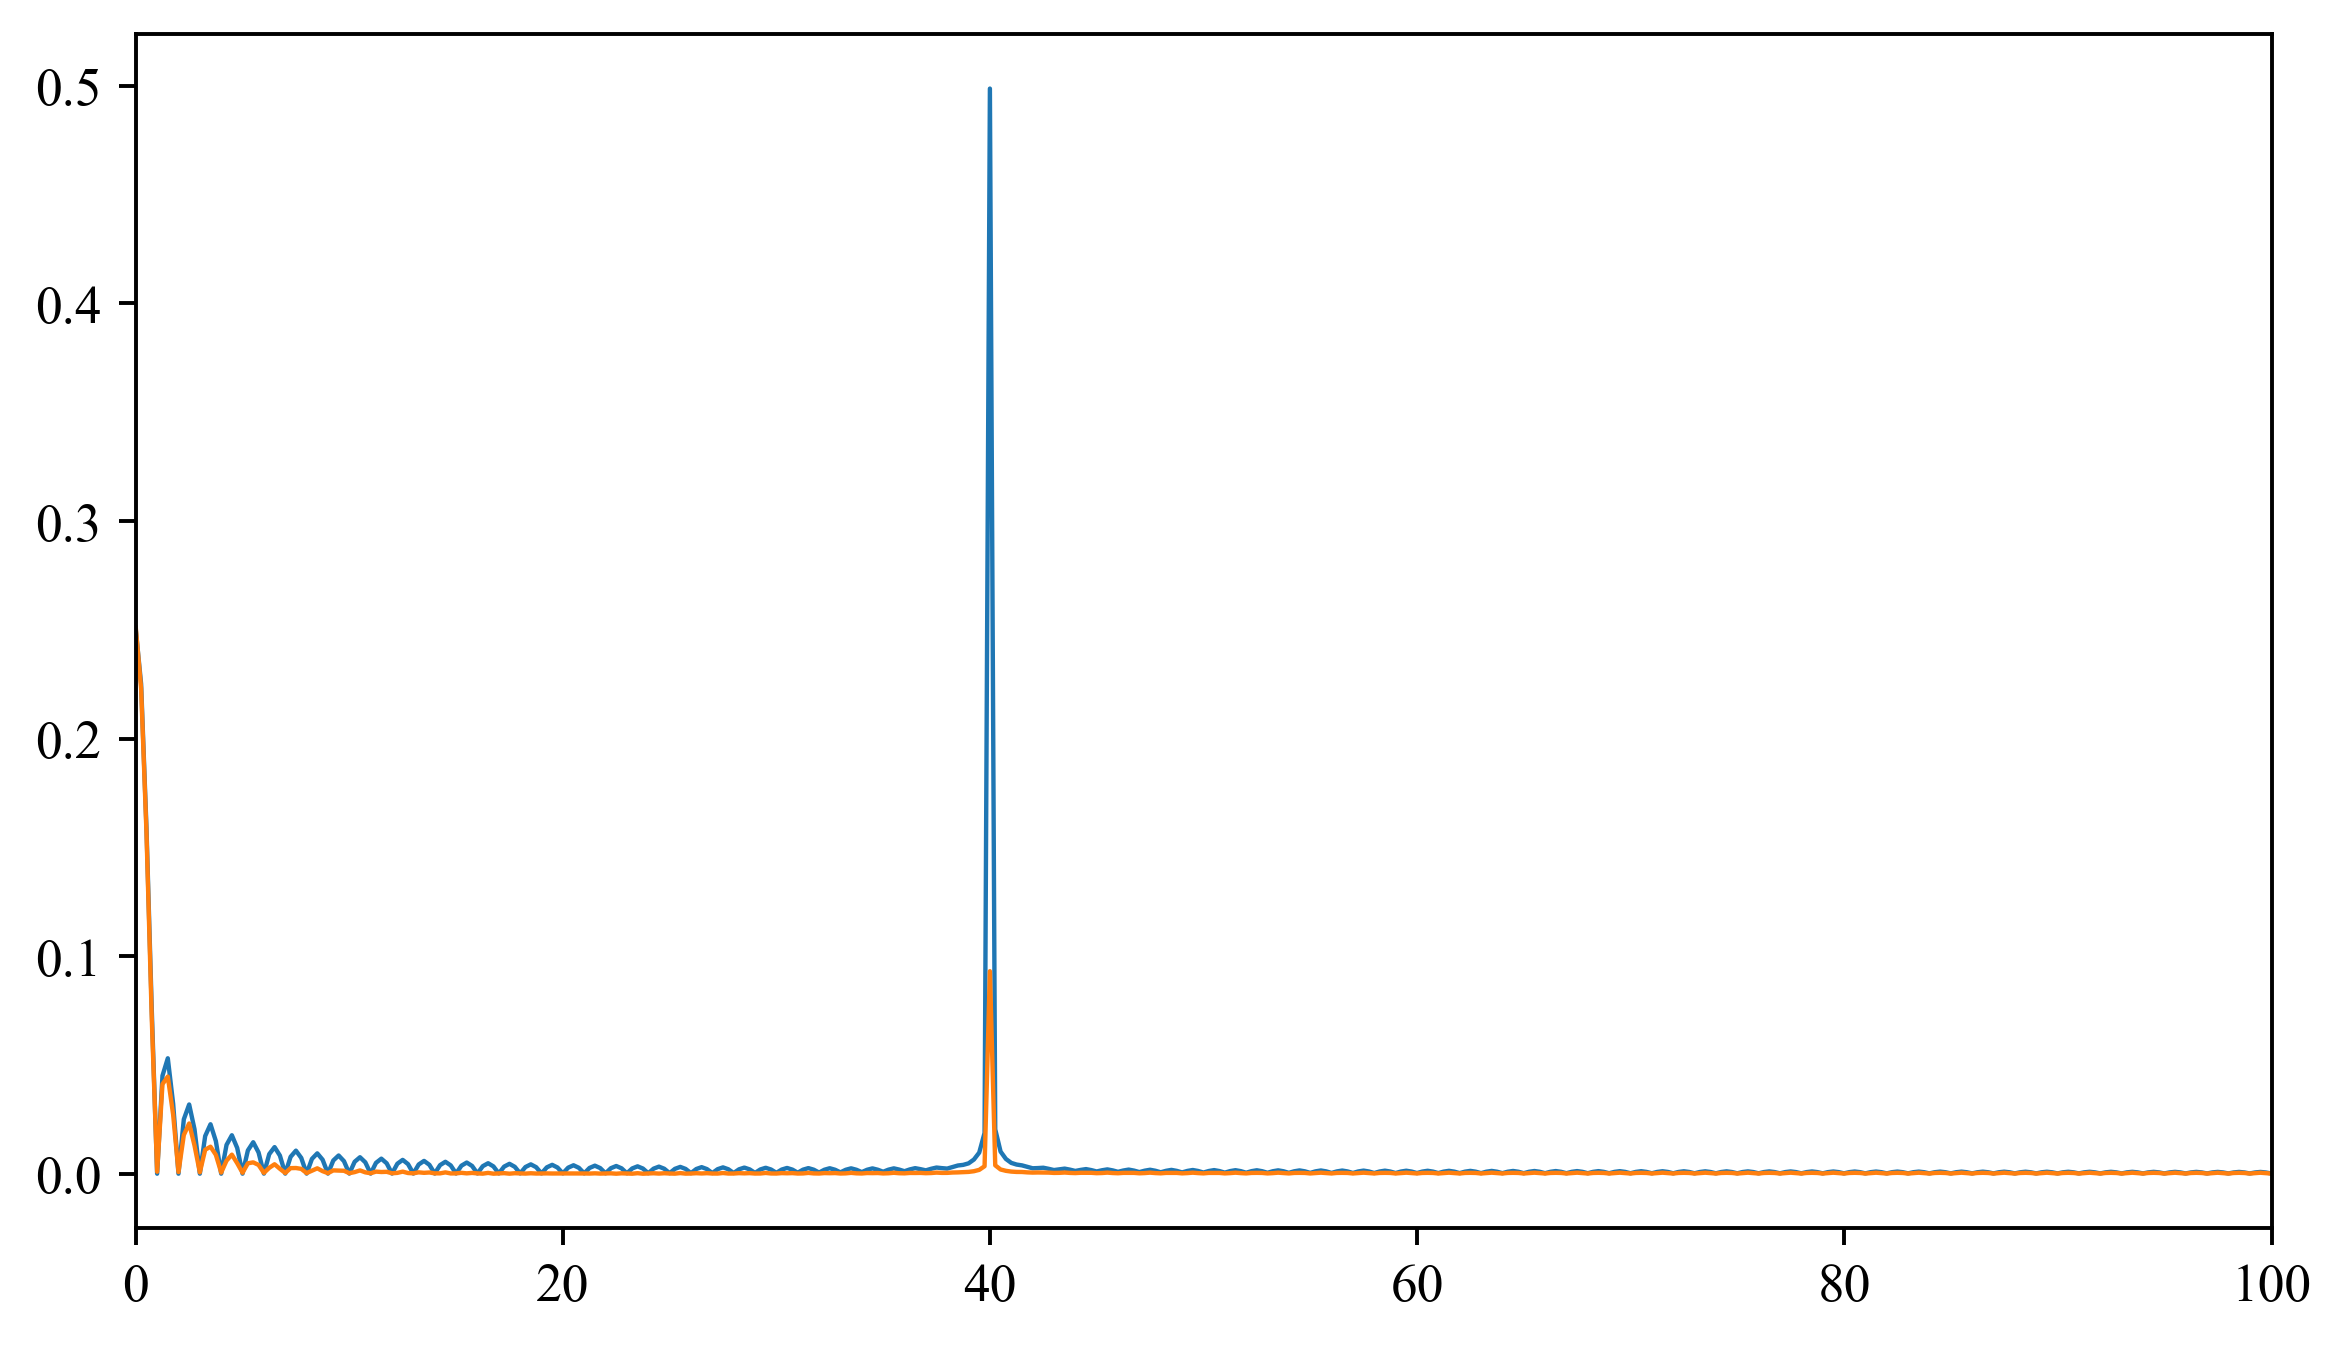

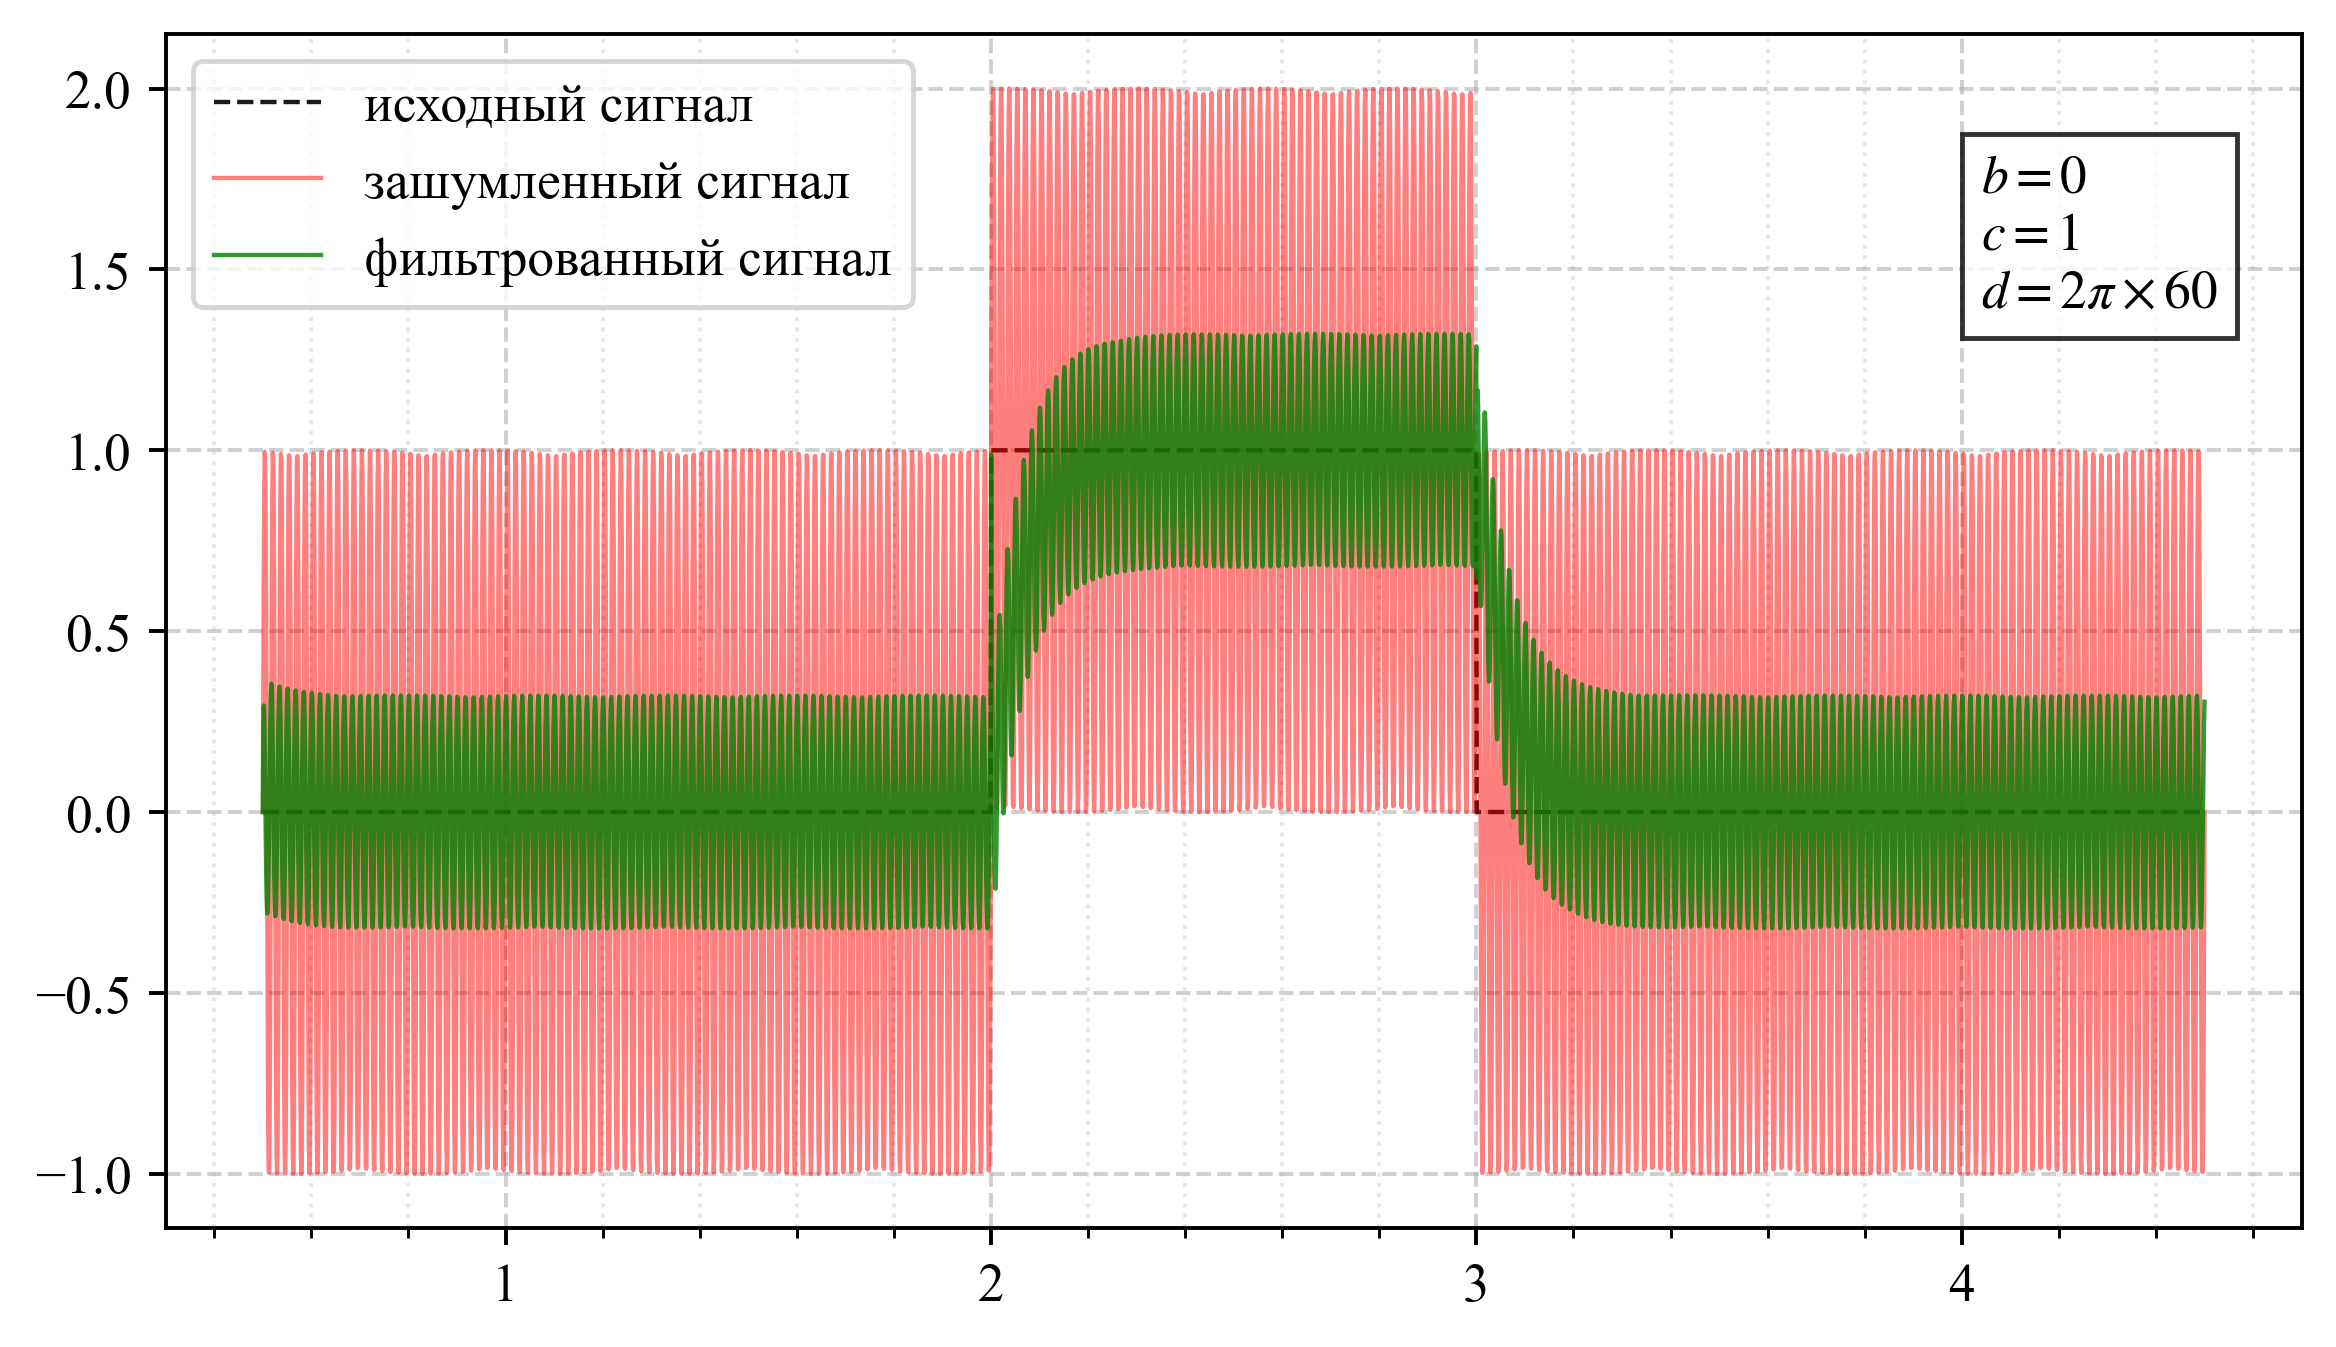

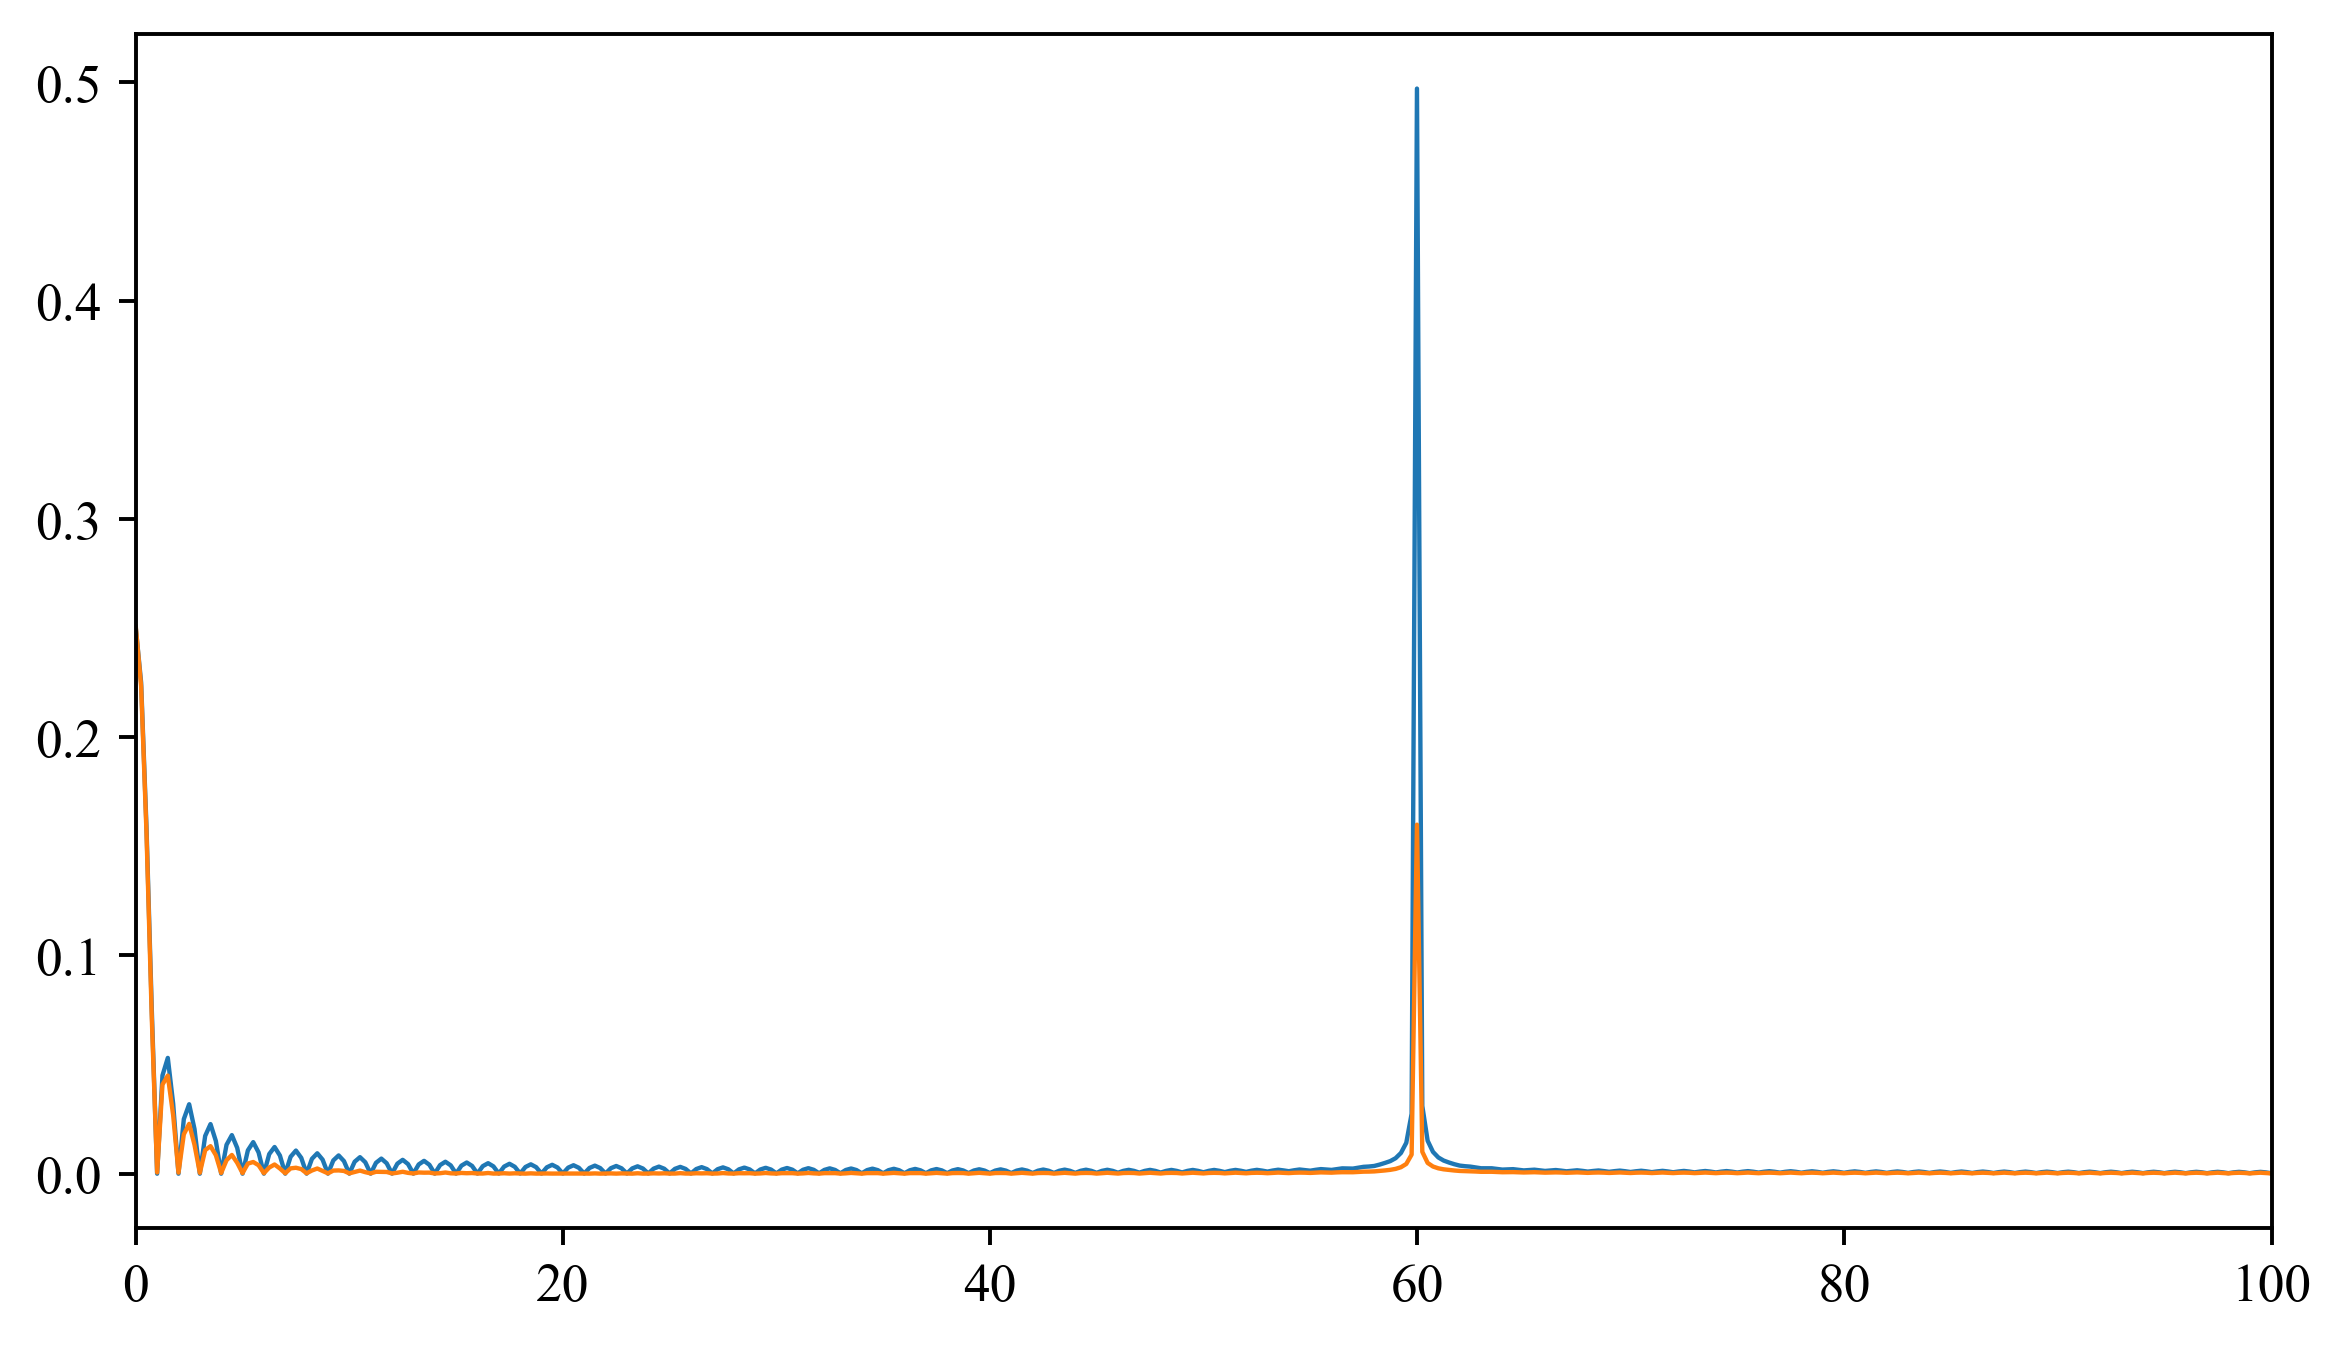

In [ ]:
%mkdir -p ../fig/1/2/d

# См.:
# https://en.wikipedia.org/wiki/Band-stop_filter

omega0 = 2*np.pi * 20

a1 = 0
a2 = omega0**2
b1 = 10**3
b2 = omega0**2

_W = W2_tf(a1, a2, b1, b2)


for i, _f0 in enumerate((25, 40, 60)):

    _wave = wave(t, 2*np.pi*_f0)
    _noisy_signal = clean_signal + _wave

    # -----------------------------------------------
    # Cравнение зашумленного и фильтрованного сигнала
    # -----------------------------------------------
    plt.figure(num=2*i)
    ax = plt.gca()

    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.2))
    ax.grid(which='major', linestyle='--', alpha=0.6)
    ax.grid(which='minor', linestyle=':', alpha=0.3)

    out_signal = apply_W_dynamic(t, _noisy_signal, _W)

    ax.plot(t, clean_signal,  'k--', alpha=.9, label='исходный сигнал')
    ax.plot(t, _noisy_signal,  'r-', alpha=.5, label='зашумленный сигнал')
    ax.plot(t, out_signal, 'g-', alpha=.8, label='фильтрованный сигнал')

    ax.text(0.85, 0.90, f"$b=0$\n$c=1$\n$d=2\\pi\\times{_f0}$", transform=ax.transAxes, 
             verticalalignment='top', horizontalalignment='left',
             bbox=dict(facecolor='white', alpha=0.8))

    plt.legend()
    plt.savefig(f"../fig/1/2/d/{2*i}.png")

    # -----------------------------------------------
    # Cравнение зашумленного и фильтрованного образа
    # -----------------------------------------------
    plt.figure(num=2*i+1)
    ax = plt.gca()

    ax.set_xlim(right=100)

    fr = np.fft.fftfreq(t.size, t[1] - t[0])[0:t.size//2]
    noisy_fft = np.abs(np.fft.fft(_noisy_signal)[0:t.size//2]) / t.size

    filtered_fr = np.fft.fftfreq(t.size, t[1] - t[0])[0:t.size//2]
    filtered_signal = np.abs((np.fft.fft(out_signal))[0:t.size//2]) / t.size

    plt.plot(fr, noisy_fft)
    plt.plot(filtered_fr, filtered_signal)

    plt.savefig(f"../fig/1/2/d/{2*i+1}.png")

- Построены сравнительные графики фильтрованного сигнала и сигнала, 
полученного после обратного преобразования Фурье произведения частотной 
передаточной функции фильтра и спектра зашумленного сигнала 
($W_2(i\omega)\cdot\hat{u}(\omega)$).


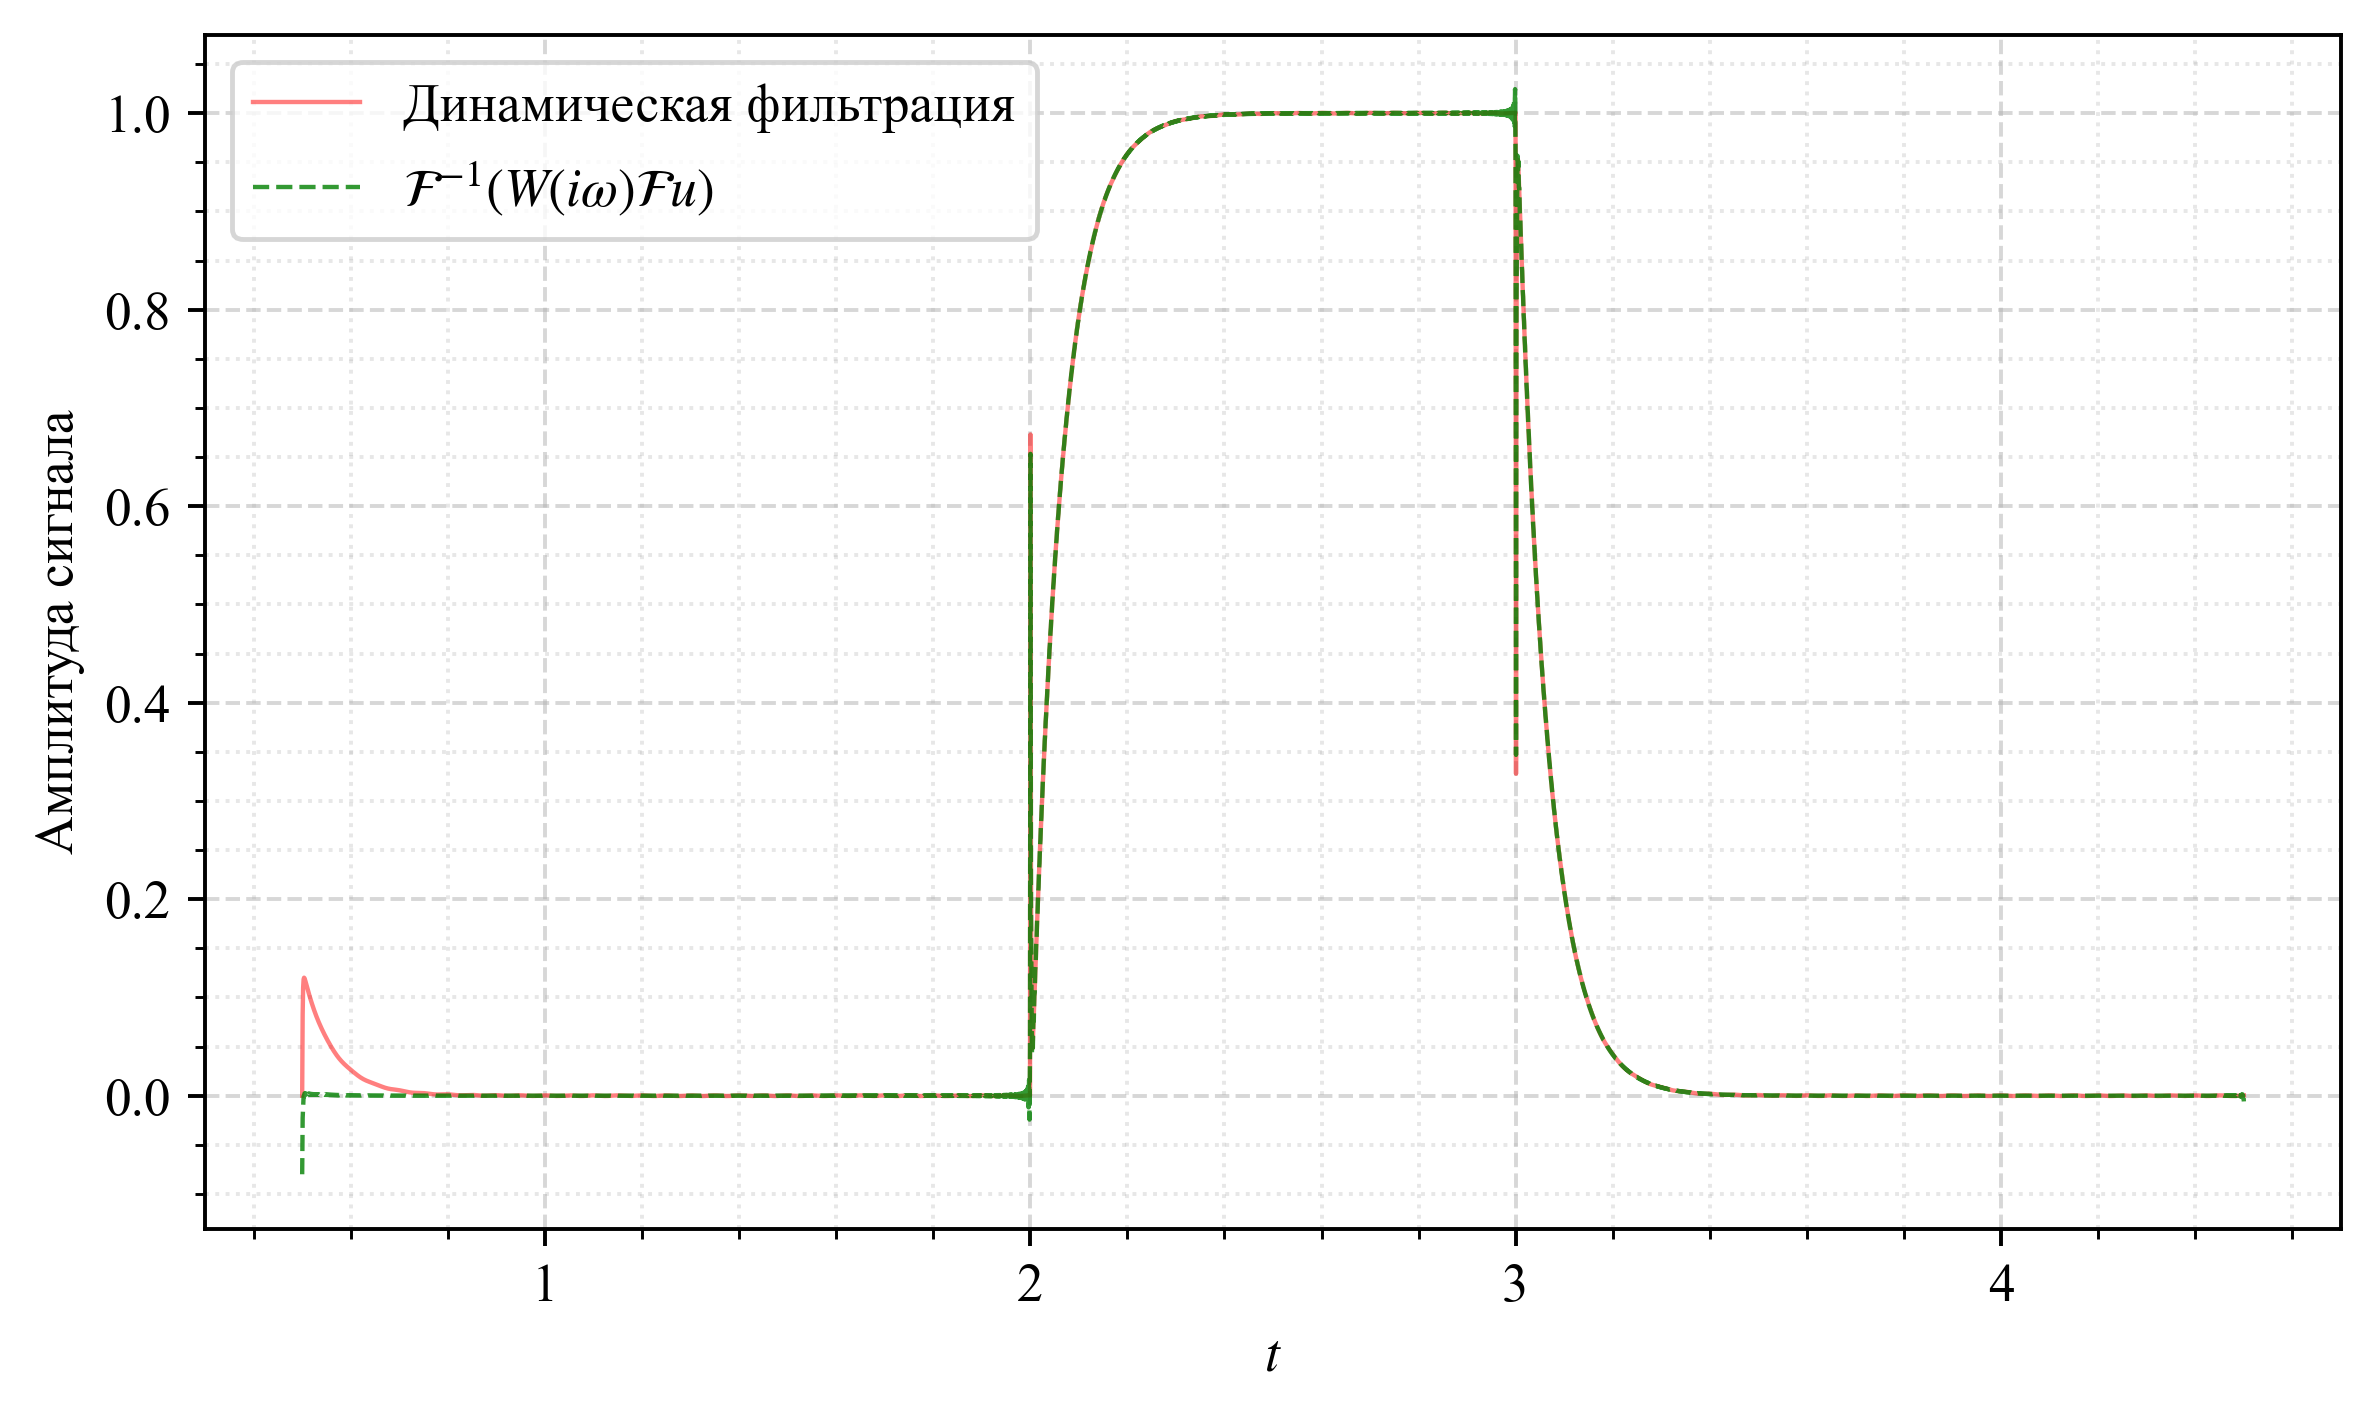

In [20]:
omega0 = 2*np.pi * 20

a1 = 0
a2 = omega0**2
b1 = 10**3
b2 = omega0**2

_W = W2_tf(a1, a2, b1, b2)

_noisy_signal = noisy_signal1

filtered_signal_nonfair = apply_W_nondynamic(t, _noisy_signal, _W)
filtered_signal_fair = apply_W_dynamic(t, _noisy_signal, _W)

plt.plot(t, filtered_signal_fair, 'r-', alpha=.5, label='Динамическая фильтрация')
plt.plot(t, filtered_signal_nonfair, 'g--', alpha=.8, label='$\\mathcal{F}^{-1}(W(i\\omega)\\mathcal{F}u)$')

plt.xlabel("$t$")
plt.ylabel("Амплитуда сигнала")

ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
plt.grid(which="major", linestyle="--", alpha=0.5)
plt.grid(which="minor", linestyle=":", alpha=0.3)
plt.legend()

%mkdir -p ../fig/1/2/comp

plt.savefig('../fig/1/2/comp/1.png')

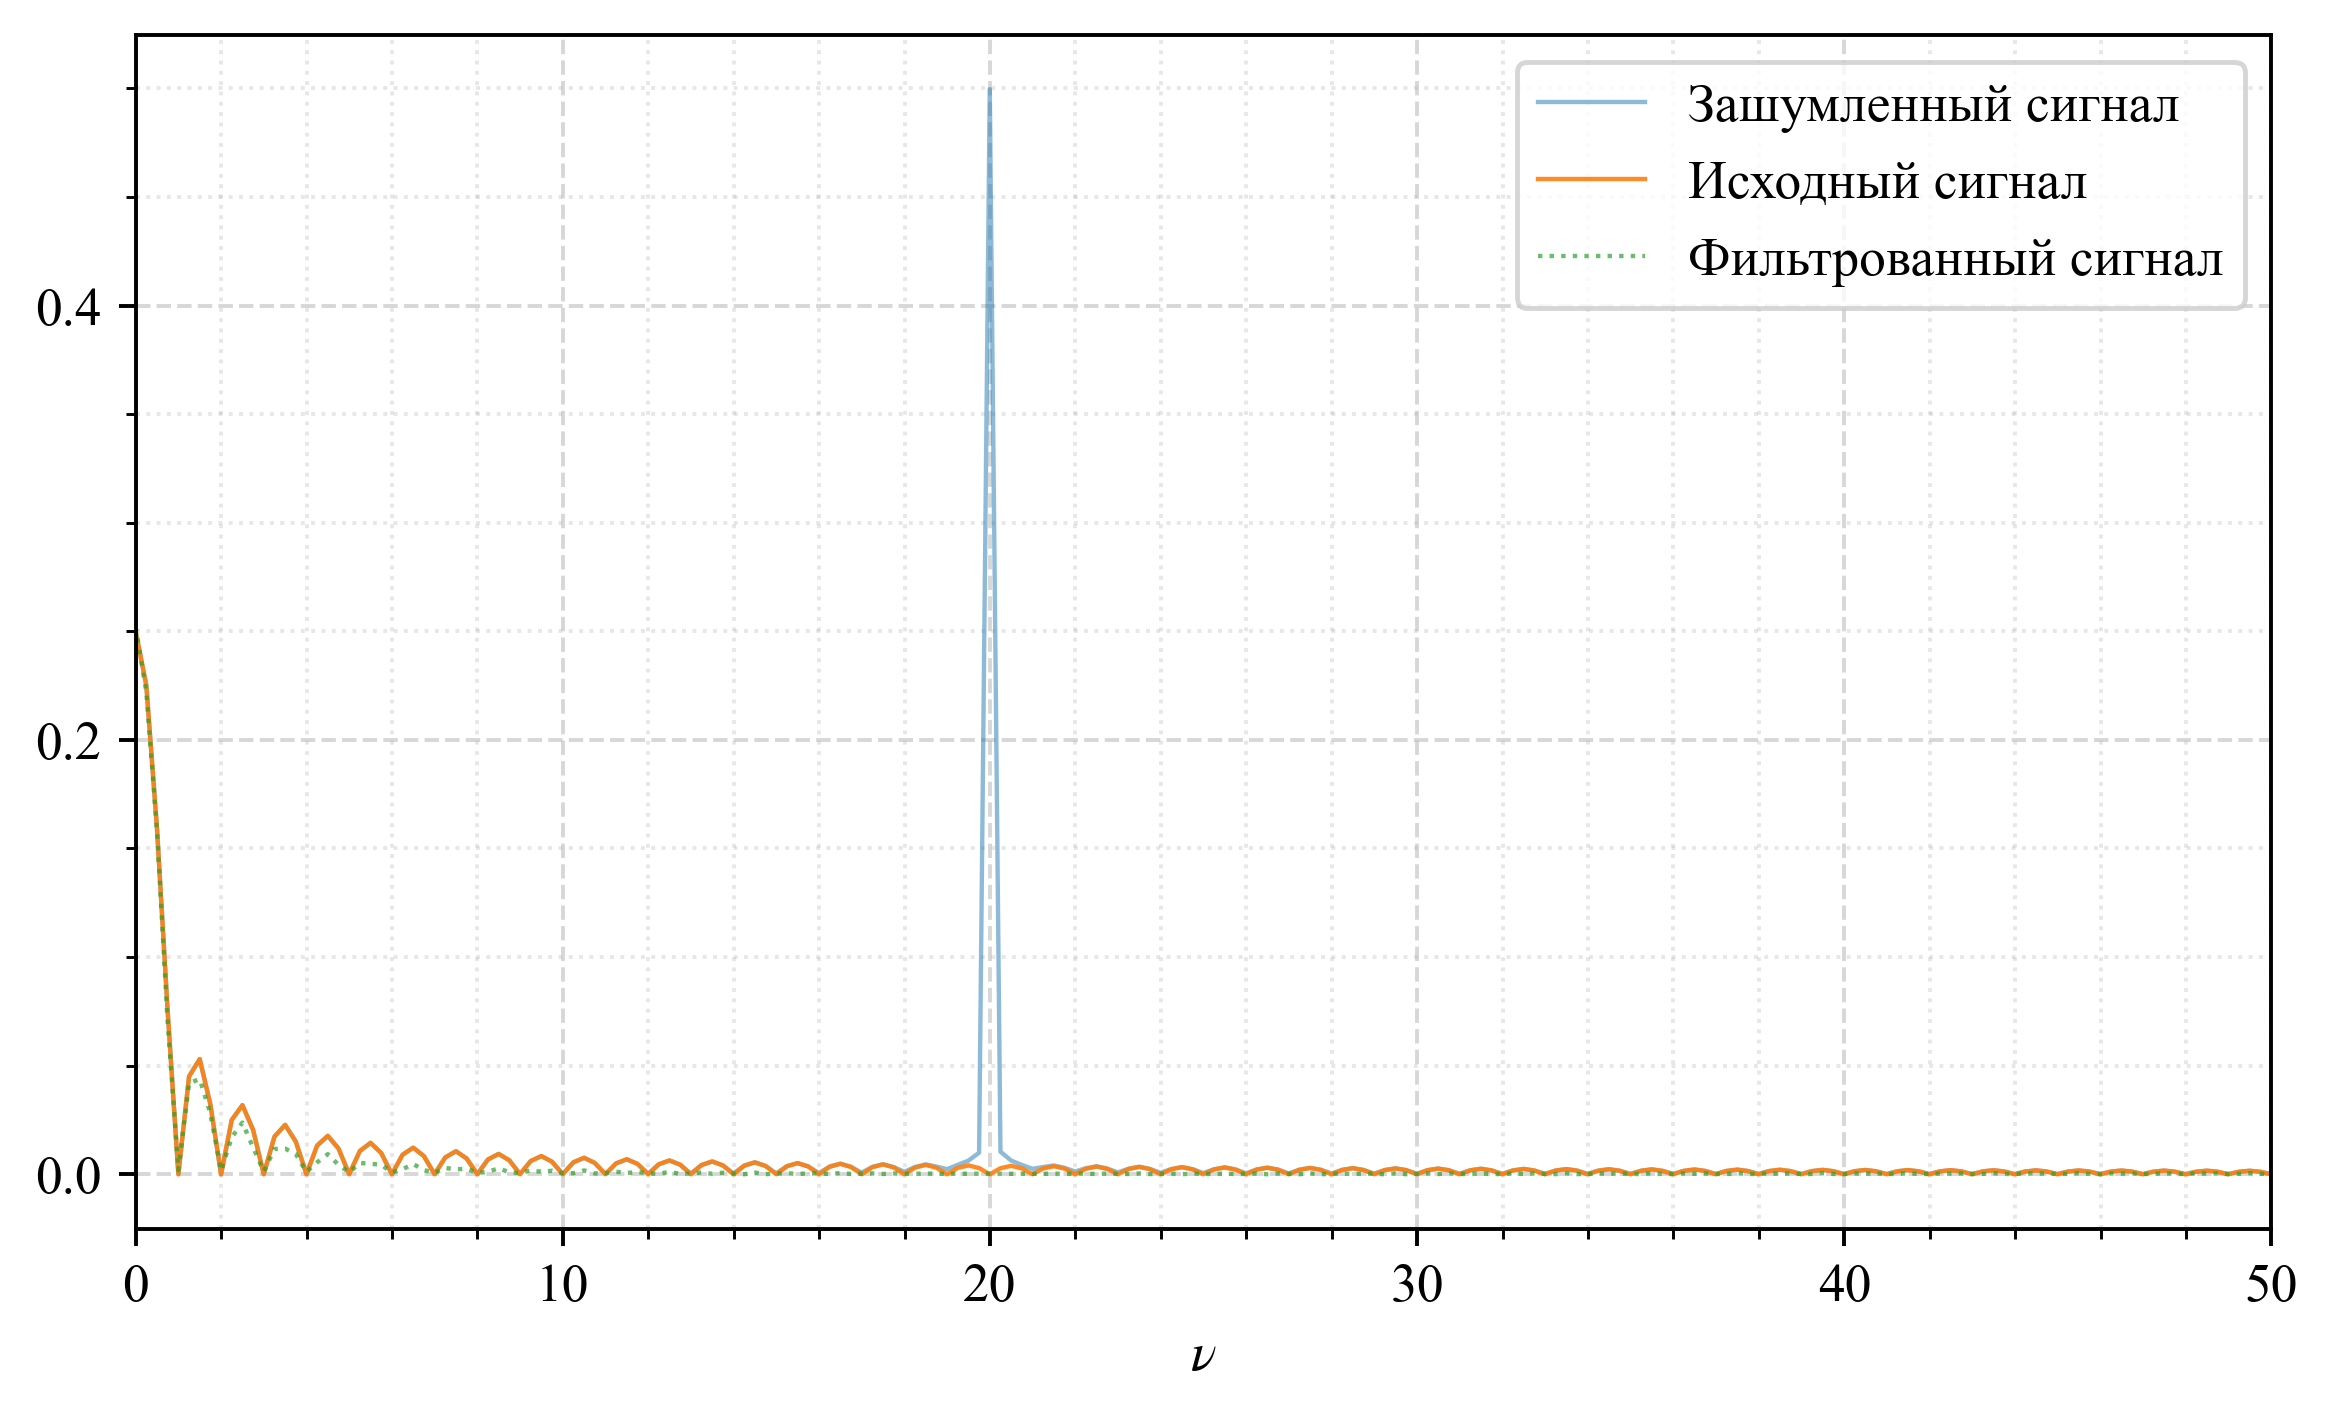

In [21]:
fr = np.fft.fftfreq(t.size, d=t[1]-t[0])[:t.size//2]
_noisy_fft = np.abs(np.fft.fft(_noisy_signal)[:t.size//2])/t.size
_clean_fft = np.abs(np.fft.fft(g(t))[:t.size//2])/t.size
_filtered_fft = np.abs(np.fft.fft(apply_W_dynamic(t, _noisy_signal, _W))[:t.size//2])/t.size

plt.plot(fr, _noisy_fft, alpha=0.5, label='Зашумленный сигнал')
plt.plot(fr, _clean_fft, alpha=0.9, label='Исходный сигнал')
plt.plot(fr, _filtered_fft, alpha=0.7, linestyle=':', label='Фильтрованный сигнал')

plt.xlabel('$\\nu$')
plt.legend()

plt.xlim(left=0, right=50)


ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
plt.grid(which="major", linestyle="--", alpha=0.5)
plt.grid(which="minor", linestyle=":", alpha=0.3)

plt.savefig('../fig/1/2/comp/2.png')

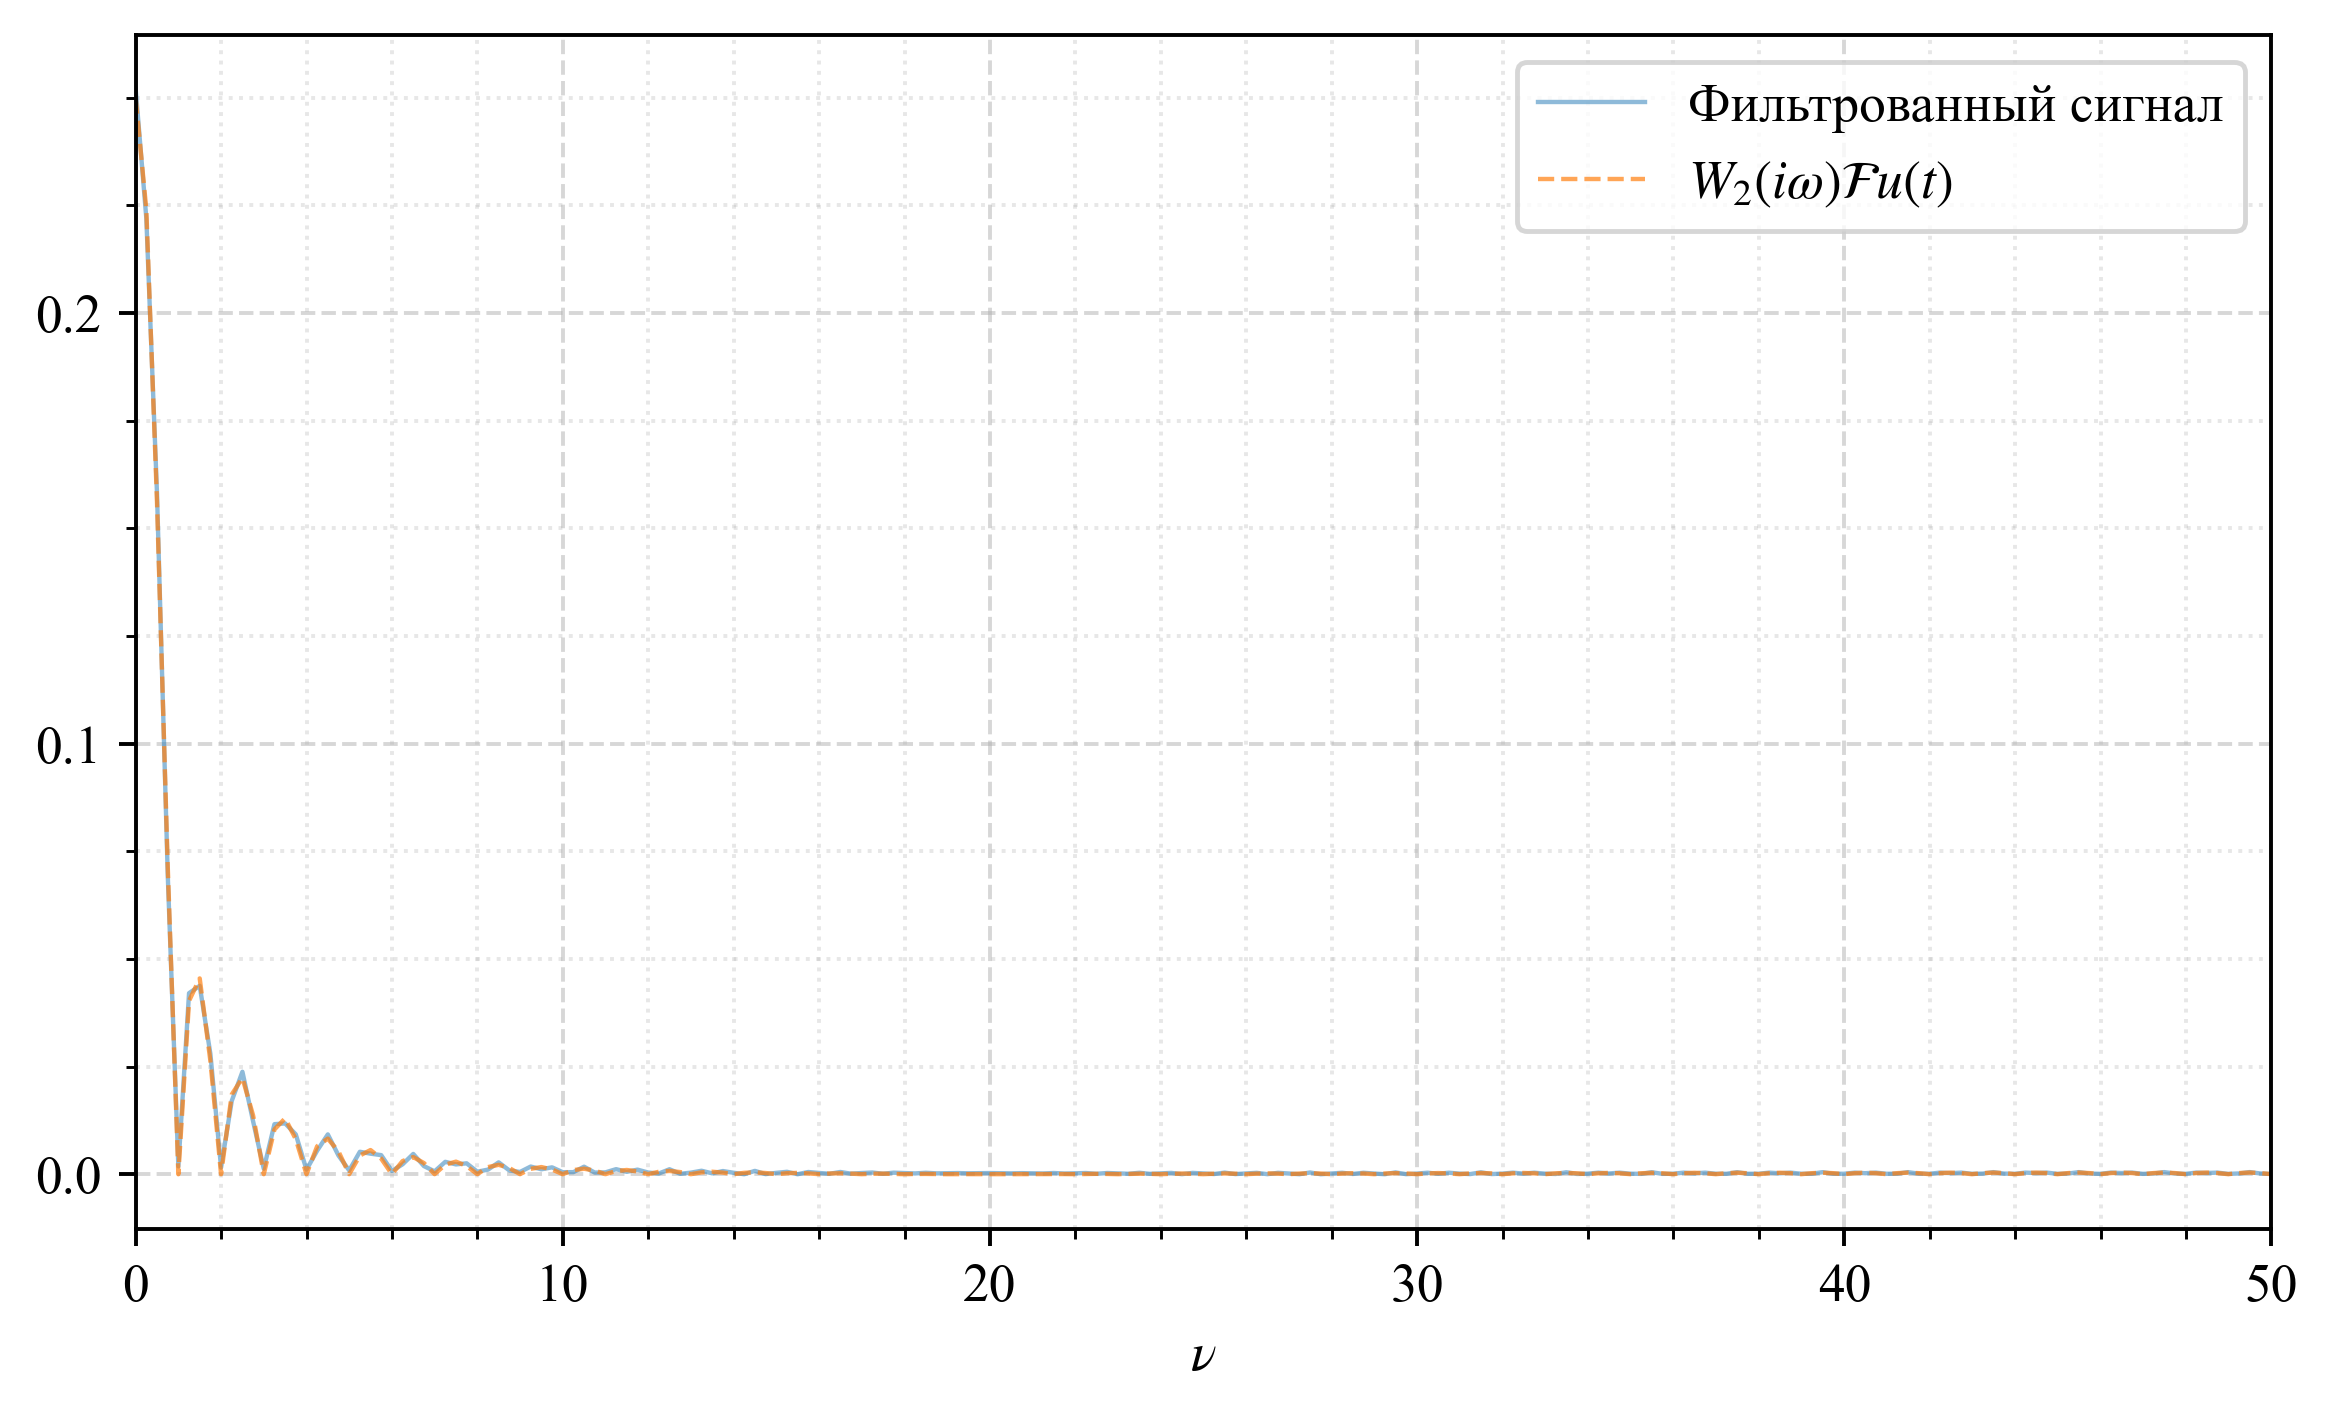

In [22]:

fr = np.fft.fftfreq(t.size, d=t[1]-t[0])
_fr = fr[:t.size//2]
_filtered_fft = np.abs(np.fft.fft(apply_W_dynamic(t, _noisy_signal, _W))[:t.size//2]) / t.size
_product_fft = np.abs( W_poly(_W)(1j * np.pi*2 * fr) * np.fft.fft(_noisy_signal) )[:t.size//2] / t.size

plt.plot(_fr, _filtered_fft, alpha=0.5, linestyle='-', label='Фильтрованный сигнал')
plt.plot(_fr, _product_fft, alpha=0.7, linestyle='--', label='$W_2(i\\omega)\\mathcal{F}u(t)$')

plt.xlabel('$\\nu$')
plt.legend()
plt.xlim(left=0, right=50)

ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.025))
plt.grid(which="major", linestyle="--", alpha=0.5)
plt.grid(which="minor", linestyle=":", alpha=0.3)


plt.savefig('../fig/1/2/comp/3.png')


In [ ]:
import pandas as pd

frame = pd.read_csv('../sup/data.csv')
frame["Date"] = pd.to_datetime(frame["Date"])
frame["Average"] = (frame['Open']+frame['Close']+frame['High']+frame['Low']) / 4
subset = frame[frame["Date"] > pd.to_datetime("2016-12-31")]

time = dict(
    minute=1,
    hour  =60,
    day   =60*24,
    week  =60*24*7,
    month =60*24*30,
    year  =60*24*365
)

Figure ../fig/2/1.png date range: 2016-09-09 to 2023-06-13
Figure ../fig/2/1.png date range: 2019-01-01 to 2022-01-01
Figure ../fig/2/1.png date range: 2021-01-01 to 2021-07-01


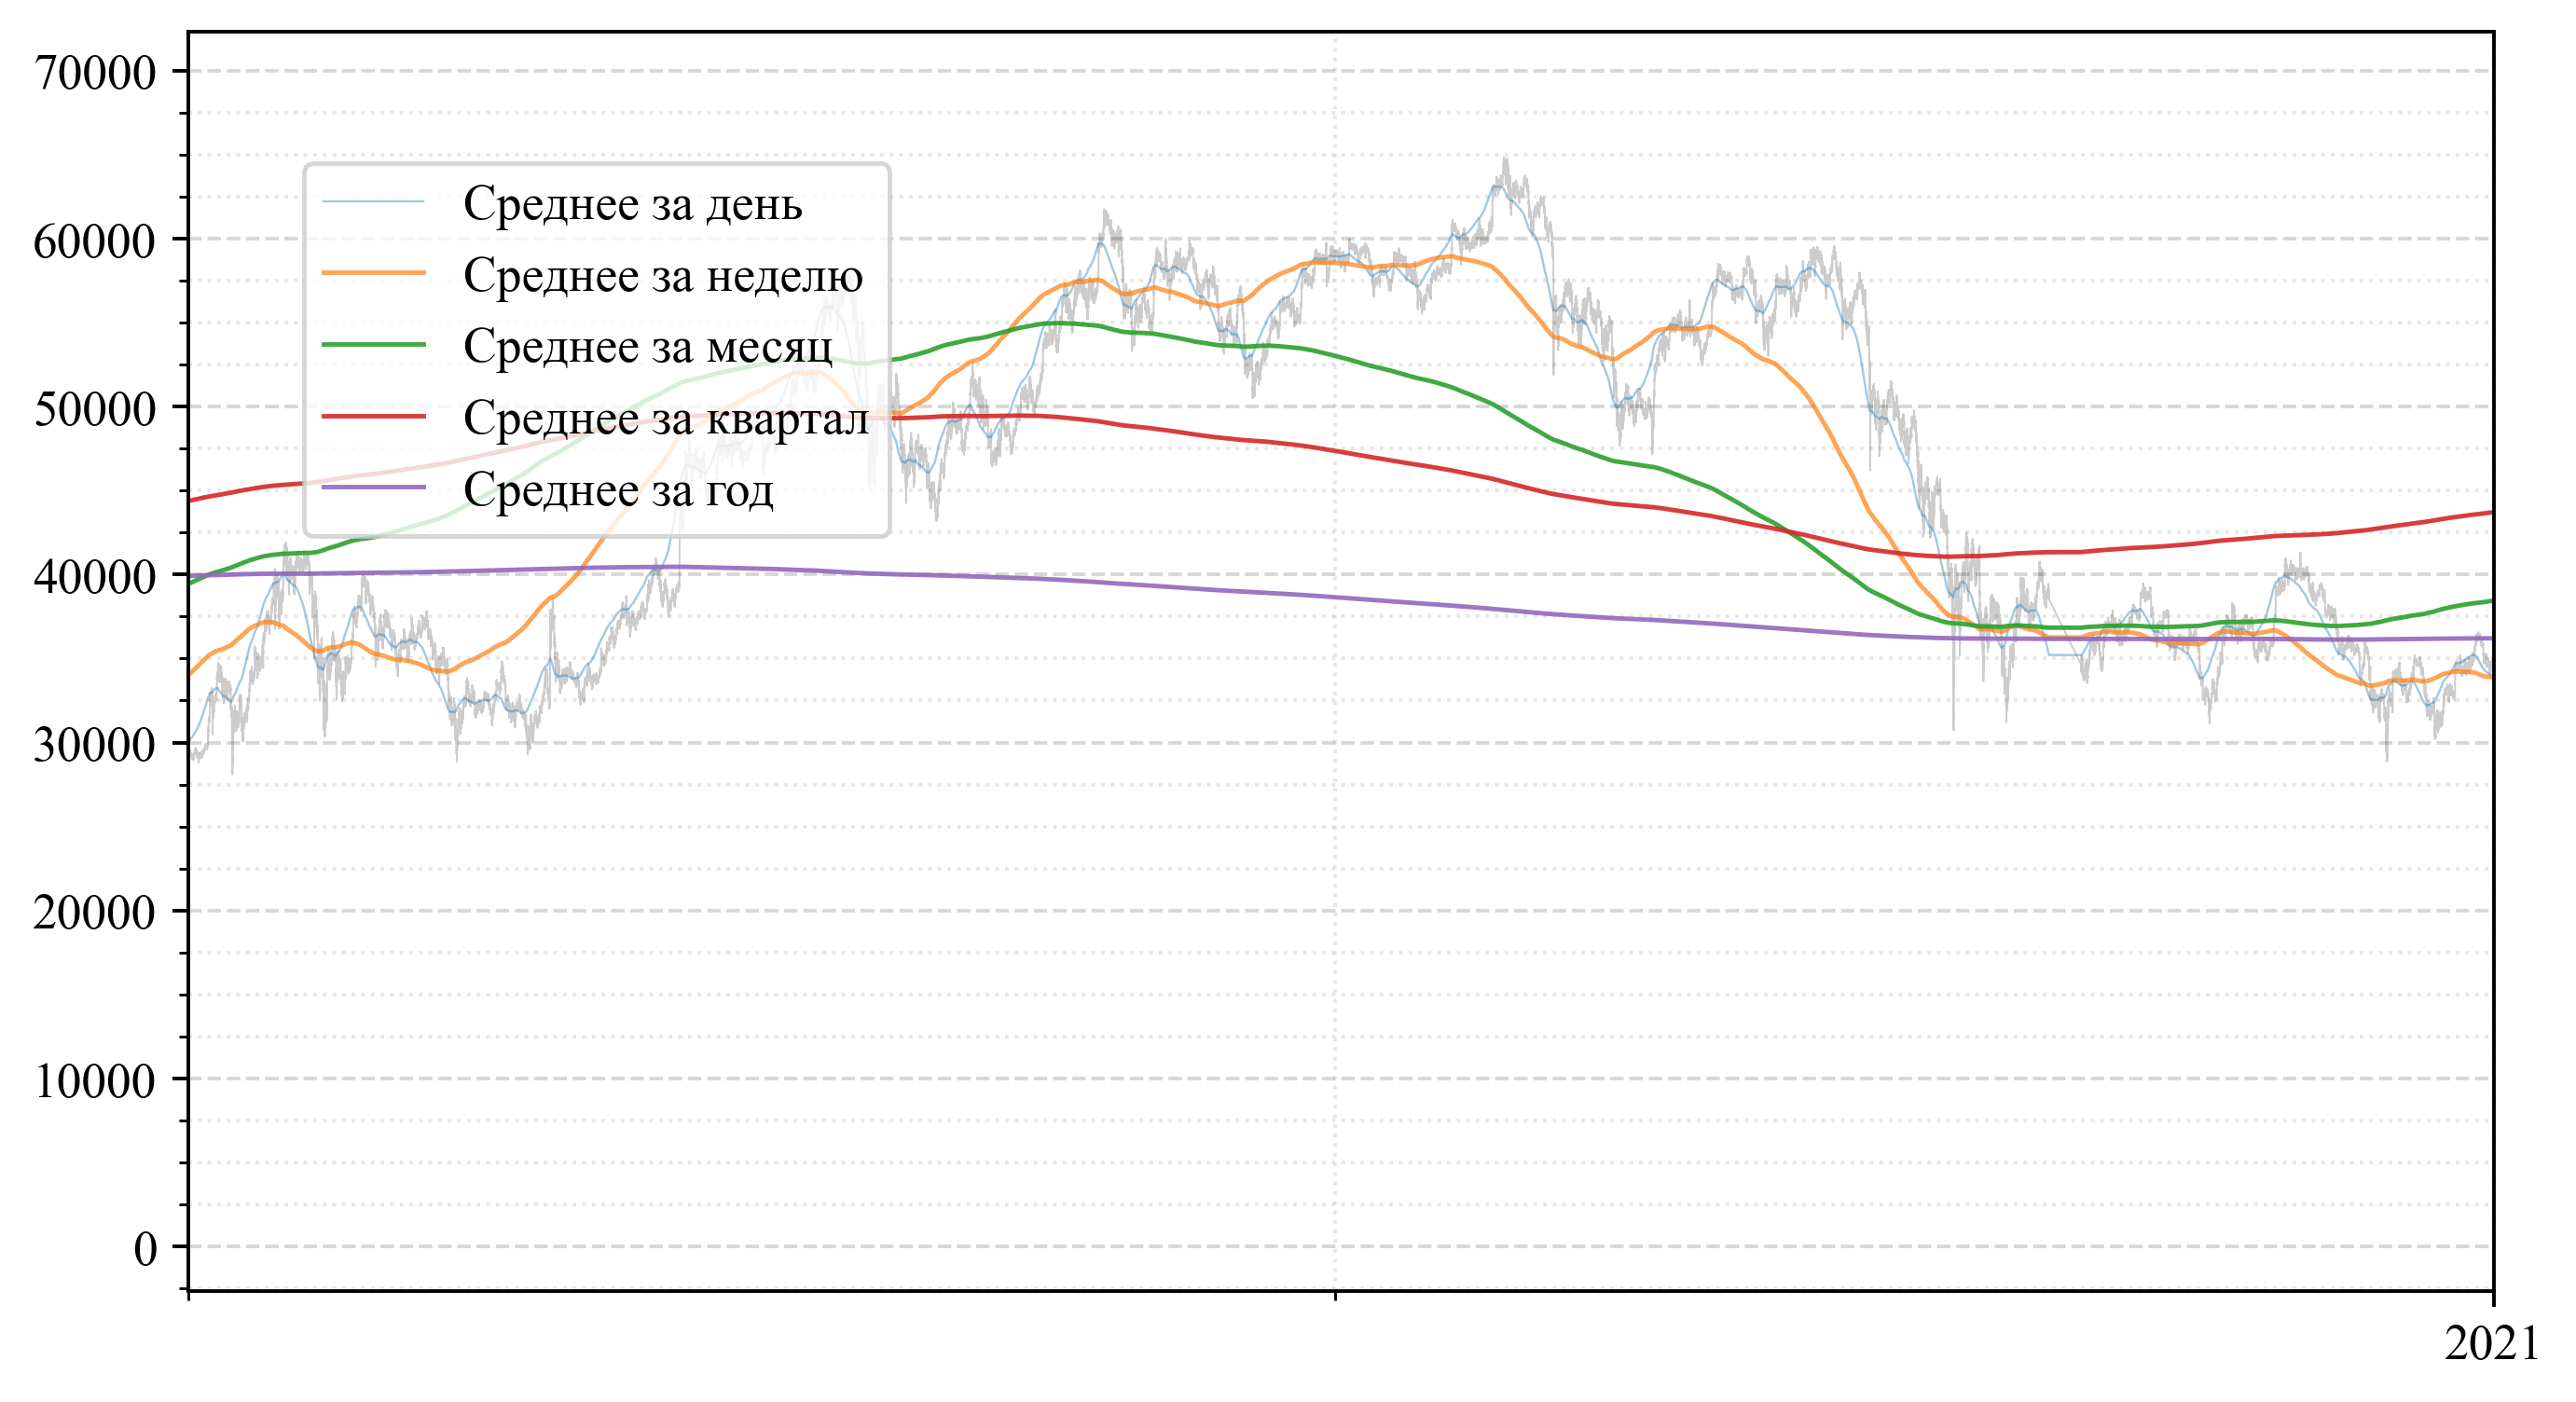

In [ ]:
# Исходные данные
average_orig = subset["Average"].to_numpy()
_average_orig = average_orig - average_orig[0]

average_day = apply_W_dynamic(None, _average_orig, W1_tf(time['day']), dt=1) + average_orig[0]
average_week = apply_W_dynamic(None, _average_orig, W1_tf(time['week']), dt=1) + average_orig[0]
average_month = apply_W_dynamic(None, _average_orig, W1_tf(time['month']), dt=1) + average_orig[0]
average_quarter = apply_W_dynamic(None, _average_orig, W1_tf(time['month']*3), dt=1) + average_orig[0]
average_year = apply_W_dynamic(None, _average_orig, W1_tf(time['year']), dt=1) + average_orig[0]


plt.plot(subset['Date'], average_orig, 'k-', linewidth=.4, alpha=.2)

plt.plot(subset['Date'], average_day, '-', linewidth=.5, alpha=.4, label='Среднее за день')
plt.plot(subset['Date'], average_week, '-', linewidth=1, alpha=.7, label='Среднее за неделю')
plt.plot(subset['Date'], average_month, '-', linewidth=1, alpha=.9, label='Среднее за месяц')
plt.plot(subset['Date'], average_quarter, '-', linewidth=1, alpha=.9, label='Среднее за квартал')
plt.plot(subset['Date'], average_year, '-', linewidth=1, alpha=.9, label='Среднее за год')

plt.legend(loc=(.05, .6))

ax = plt.gca()
ax.xaxis.set_major_locator(mpl.dates.MonthLocator(interval=12))  # каждые 3 месяца – квартал
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(interval=3))             # минорные – каждый месяц
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))


ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10000))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(2500))

ax.grid(which='major', linestyle='--', alpha=0.5)
ax.grid(which='minor', linestyle=':', alpha=0.3)

plt.margins(.05)
plt.tight_layout()

%mkdir -p ../fig/2
plt.savefig('../fig/2/1.png')
date_range = mpl.dates.num2date(ax.get_xlim())
print("Figure ../fig/2/1.png date range:", date_range[0].strftime('%Y-%m-%d'), "to", date_range[1].strftime('%Y-%m-%d'))
plt.savefig('../fig/2/1.png')

start_date = pd.to_datetime("2019-01-01")
end_date = pd.to_datetime("2022-01-01")

ax.set_xlim(start_date, end_date)
plt.savefig('../fig/2/2.png')
date_range = mpl.dates.num2date(ax.get_xlim())
print("Figure ../fig/2/1.png date range:", date_range[0].strftime('%Y-%m-%d'), "to", date_range[1].strftime('%Y-%m-%d'))

start_date = pd.to_datetime("2021-01-01")
end_date = pd.to_datetime("2021-07-01")

ax.set_xlim(start_date, end_date)
plt.savefig('../fig/2/3.png')
date_range = mpl.dates.num2date(ax.get_xlim())
print("Figure ../fig/2/1.png date range:", date_range[0].strftime('%Y-%m-%d'), "to", date_range[1].strftime('%Y-%m-%d'))